In [1]:

import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
import networkx as nx
import yfinance as yf
import sys
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')
sys.path.insert(0, 'C:/Users/User/Code/DyGraph/src')

import DyGraph as dg
import port_measures as pm
import matplotlib.pyplot as plt
import tqdm
import scipy
from scipy.optimize import minimize
from sklearn import linear_model

In [2]:
def cov_regression(X, Y, alpha, max_itr = 100, tol = 1e-5):
    
    d = Y.shape[1]
    n = X.shape[0]
    Y_tilde = np.vstack((Y, np.zeros((n,d))))

    r = X.shape[1]
    alpha = n*alpha
    iteration = 0
    max_itr = 100

    Psi_pre = np.identity(d)
    v = np.ones(n)
    m = np.ones(n)
    X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
    # The solution is evry sensitive to the inital matrix, the l2 regularization for B_pre effects alpha
    B_pre = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T, X_tilde) + alpha*np.identity(r)))




    def fun(param, X, Y,Psi_inv, d,r, alpha):
        
        B = np.reshape(param[:r*d]-param[r*d:],(d,r))
        obj =  np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T)))) + alpha*param.sum() #np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T))).dot(Psi_inv)) + alpha*param.sum()
        t_0 = Y.T-np.dot(B,X.T)
        grad = (-0.5*np.dot(t_0,X)).flatten()# (-0.5*np.dot(Psi_inv,t_0).dot(X) ).flatten() #  0.5*alpha*param[:r*d] 
        return obj, np.concatenate((grad + alpha , - grad + alpha ), axis=None) # np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T))).dot(Psi_inv)) + alpha*np.sum(np.abs(B))

    B_tmp = B_pre.flatten()
    B_vec = np.zeros(2*r*d)
    B_vec[:r*d] = np.abs(B_tmp) * (B_tmp>0)
    B_vec[r*d:] = np.abs(B_tmp) * (B_tmp<0)
    # B_pre = np.zeros((r,d))
    while iteration <max_itr:
        Psi_pre_inv = np.linalg.inv(Psi_pre)
        # print(np.linalg.cond(Psi_pre_inv))
        # E-step
        for i in range(n):
            v[i] = (1+np.dot(X[i].T, B_pre.T).dot(Psi_pre_inv).dot(B_pre).dot(X[i])) ** (-1)
            m[i] = v[i]*np.dot((Y[i]-0).T,Psi_pre_inv).dot(B_pre).dot(X[i])

        X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
        # M-step
        out = minimize(fun, B_vec, args = (X_tilde, Y_tilde, Psi_pre_inv,d,r, alpha), method='L-BFGS-B', jac=True, bounds = [(0.0,None)]*(2*r*d))
        B_vec = out.x
        B = np.reshape(out.x[:r*d] - out.x[r*d:], (d,r))
        #inv_m = np.linalg.inv(np.dot(X_tilde.T, X_tilde))
        #B = np.dot(Y_tilde.T,X_tilde).dot(inv_m)


        Psi = np.cov((Y-np.dot(X,B.T)).T)*(n-1)/n
        

        if np.linalg.norm(B-B_pre)<tol:
            break

        Psi_pre = Psi.copy()
        B_pre = B.copy()
        
        #print(scipy.linalg.norm(B_pre-B_true))
        iteration+=1

    return B, Psi

from sklearn import linear_model
def cov_regression_lasso(X, Y, alpha, max_itr = 100, tol = 1e-5):
    
    d = Y.shape[1]
    n = X.shape[0]
    Y_tilde = np.vstack((Y, np.zeros((n,d))))

    r = X.shape[1]
    alpha = n*alpha
    iteration = 0
    max_itr = 100

    Psi_pre = np.identity(d)
    v = np.ones(n)
    m = np.ones(n)
    X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
    # The solution is evry sensitive to the inital matrix, the l2 regularization for B_pre effects alpha
    B_pre = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T, X_tilde) + alpha*np.identity(r)))


    B_tmp = B_pre.flatten()
    B_vec = np.zeros(2*r*d)
    B_vec[:r*d] = np.abs(B_tmp) * (B_tmp>0)
    B_vec[r*d:] = np.abs(B_tmp) * (B_tmp<0)
    # B_pre = np.zeros((r,d))
    while iteration <max_itr:
        Psi_pre_inv = np.linalg.inv(Psi_pre)
        # print(np.linalg.cond(Psi_pre_inv))
        # E-step
        for i in range(n):
            v[i] = (1+np.dot(X[i].T, B_pre.T).dot(Psi_pre_inv).dot(B_pre).dot(X[i])) ** (-1)
            m[i] = v[i]*np.dot((Y[i]-0).T,Psi_pre_inv).dot(B_pre).dot(X[i])

        X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
        reg_lasso = linear_model.Lasso(alpha = alpha).fit(X_tilde,Y_tilde)
        B = reg_lasso.coef_.copy()

        Psi = np.cov((Y-np.dot(X,B.T)).T)*(n-1)/n
        

        if np.linalg.norm(B-B_pre)<tol:
            break

        Psi_pre = Psi.copy()
        B_pre = B.copy()

        iteration+=1

    return B, Psi




def cov_regression_t(X, Y, alpha, nu, max_itr = 100):
    
    d = Y.shape[1]
    n = X.shape[0]
    Y_tilde = np.vstack((Y, np.zeros((n,d))))

    r = X.shape[1]
    alpha = n*alpha
    iteration = 0
    max_itr = 100

    Psi_pre = np.identity(d)
    v = np.ones(n)
    m = np.ones(n)
    X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
    B_pre = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T, X_tilde) + 0.0001*np.identity(r)))




    def fun(param, X, Y,Psi_inv, d,r, alpha,):
        
        B = np.reshape(param[:r*d]-param[r*d:],(d,r))
        obj = np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T))).dot(Psi_inv)) + alpha*param.sum() #+ 0.5*alpha*np.sum(param**2)#  + alpha*np.sum(np.abs(B))
        t_0 = Y.T-np.dot(B,X.T)
        grad = (-np.dot(Psi_inv,t_0).dot(X) ).flatten() #  0.5*alpha*param[:r*d] 
        return obj, np.concatenate((grad + alpha , - grad + alpha ), axis=None) # np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T))).dot(Psi_inv)) + alpha*np.sum(np.abs(B))

    B_tmp = B_pre.flatten()
    B_vec = np.zeros(2*r*d)
    B_vec[:r*d] = np.abs(B_tmp) * (B_tmp>0)
    B_vec[r*d:] = np.abs(B_tmp) * (B_tmp<0)
    # B_pre = np.zeros((r,d))
    while iteration <max_itr:
        Psi_pre_inv = np.linalg.inv(Psi_pre)
        # print(np.linalg.cond(Psi_pre_inv))
        # E-step
        for i in range(n):
            v[i] = (1+np.dot(X[i].T, B_pre.T).dot(Psi_pre_inv).dot(B_pre).dot(X[i])) ** (-1)
            m[i] = v[i]*np.dot((Y[i]-0).T,Psi_pre_inv).dot(B_pre).dot(X[i])
        M = np.einsum('nj,jk,nk->n', (Y -np.dot(X, B_pre.T)), Psi_pre_inv, (Y -np.dot(X, B_pre.T)))  # Mahalanobis distance
        tau = (nu + d)/(nu  + M)

        X_tilde =  np.vstack((m[:,np.newaxis]*np.sqrt(tau[:,np.newaxis])*X,v[:,np.newaxis]*np.sqrt(tau[:,np.newaxis])*X))
        Y_tilde = np.vstack((Y*np.sqrt(tau[:,np.newaxis]), np.zeros((n,d))))
        # M-step
        out = minimize(fun, B_vec, args = (X_tilde, Y_tilde, Psi_pre_inv,d,r, alpha), method='L-BFGS-B', jac=True, bounds = [(0.0,None)]*(2*r*d))
        B_vec = out.x
        B = np.reshape(out.x[:r*d] - out.x[r*d:], (d,r))
        #inv_m = np.linalg.inv(np.dot(X_tilde.T, X_tilde))
        #B = np.dot(Y_tilde.T,X_tilde).dot(inv_m)


        Psi = np.cov((Y-np.dot(X,B.T)).T)*(n-1)/n
        

        Psi_pre = Psi.copy()
        B_pre = B.copy()
        

        #print(scipy.linalg.norm(B_pre-B_true))
        iteration+=1

    return B, Psi


def cov_regression_subgrad(X, Y, alpha, max_itr = 100, step_size = 0.05):
    
    d = Y.shape[1]
    n = X.shape[0]
    Y_tilde = np.vstack((Y, np.zeros((n,d))))

    r = X.shape[1]
    alpha = n*alpha
    iteration = 0
    max_itr = 100


    Psi_pre = np.identity(d)
    v = np.zeros(n)
    m = np.zeros(n)
    v = np.ones(n)
    m = np.ones(n)
    X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
    B_pre = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T, X_tilde) + 0.1*np.identity(r)))


    # B_pre = np.zeros((r,d))
    while iteration <max_itr:
        Psi_pre_inv = np.linalg.inv(Psi_pre)
        # print(np.linalg.cond(Psi_pre_inv))
        # E-step
        for i in range(n):
            v[i] = (1+np.dot(X[i].T, B_pre.T).dot(Psi_pre_inv).dot(B_pre).dot(X[i])) ** (-1)
            m[i] = v[i]*np.dot((Y[i]-0).T,Psi_pre_inv).dot(B_pre).dot(X[i])

        X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
        # M-step

        B=B_pre.copy()
        for sub_step in range(1,1000):
            B = B - (step_size/sub_step)* (-0.5*np.dot(Psi_pre_inv, Y_tilde.T -np.dot(B,X_tilde.T)).dot(X_tilde) + alpha*np.sign(B))
            # B = soft_threshold_odd(B,alpha)


        Psi = np.cov((Y-np.dot(X,B.T)).T)*(n-1)/n
            

        Psi_pre = Psi.copy()
        B_pre = B.copy()

        iteration+=1

    return B, Psi


def soft_threshold_odd( A, lamda):

    """
    diagonal lasso penalty

    Parameters
    ------------------
    A: np.array,
    
    lamda: float,
        regularization
    """
    opt_m = (A-lamda)*(A>=lamda) + (A+lamda)*(A<=-lamda)
    

    return opt_m


def cov_regression_gen_grad(X, Y, alpha, max_itr = 100, step_size = 0.05, grad_itr = 100):
    
    d = Y.shape[1]
    n = X.shape[0]
    Y_tilde = np.vstack((Y, np.zeros((n,d))))

    r = X.shape[1]
    alpha = n*alpha
    iteration = 0
    max_itr = 100


    Psi_pre = np.identity(d)
    v = np.zeros(n)
    m = np.zeros(n)
    v = np.ones(n)
    m = np.ones(n)
    X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
    B_pre = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T, X_tilde) + 0.1*np.identity(r)))


    # B_pre = np.zeros((r,d))
    while iteration <max_itr:
        Psi_pre_inv = np.linalg.inv(Psi_pre)
        # print(np.linalg.cond(Psi_pre_inv))
        # E-step
        for i in range(n):
            v[i] = (1+np.dot(X[i].T, B_pre.T).dot(Psi_pre_inv).dot(B_pre).dot(X[i])) ** (-1)
            m[i] = v[i]*np.dot((Y[i]-0).T,Psi_pre_inv).dot(B_pre).dot(X[i])

        X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
        # M-step
        alpha = 1
        B=B_pre.copy()
        # Gradient
        for sub_step in range(1,grad_itr+1):
            B = B - (step_size/sub_step)* (-0.5*np.dot(Psi_pre_inv, Y_tilde.T -np.dot(B,X_tilde.T)).dot(X_tilde))
            B = soft_threshold_odd(B,alpha)

        Psi = np.cov((Y-np.dot(X,B.T)).T)*(n-1)/n
            

        Psi_pre = Psi.copy()
        B_pre = B.copy()
        

        #print(scipy.linalg.norm(B_pre-B_true))
        iteration+=1

    return B, Psi


def dynamic_cov_regression(X, Y, obs_per_graph, alpha, rho, kappa, max_itr = 100):

    nr_graphs = int(X.shape[0]/obs_per_graph)
    
    d = Y.shape[1]
    n = X.shape[0]
    Y_tilde = np.vstack((Y, np.zeros((n,d))))

    r = X.shape[1]
    alpha = obs_per_graph*alpha
    rho = obs_per_graph*rho
    kappa = obs_per_graph*kappa
    iteration = 0
    max_itr = 100

    Psi_pre = np.identity(d)
    v = np.ones(n)
    m = np.ones(n)
    X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
    # The solution is evry sensitive to the inital matrix, the l2 regularization for B_pre effects alpha
    B_pre = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T, X_tilde) + 0.0001*np.identity(r)))
    u1 = np.zeros((nr_graphs, B_pre.shape[0], B_pre.shape[0]))
    u2 = np.zeros((nr_graphs, B_pre.shape[0], B_pre.shape[0]))
    z1 = np.zeros((nr_graphs, B_pre.shape[0], B_pre.shape[0]))
    z2 = np.zeros((nr_graphs, B_pre.shape[0], B_pre.shape[0]))
    Bs = np.array([B_pre for _ in range(nr_graphs)])
    Psis = np.array([Psi_pre for _ in range(nr_graphs)])

    


    def fun(param, X, Y,Psi_inv, d,r, alpha, A):
        
        B = np.reshape(param[:r*d]-param[r*d:],(d,r))
        obj = np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T))).dot(Psi_inv)) + alpha*param.sum() + (rho/2)*np.linalg.norm(B-A)**2 #+ 0.5*alpha*np.sum(param**2)#  + alpha*np.sum(np.abs(B))
        t_0 = Y.T-np.dot(B,X.T)
        grad = (-0.5*np.dot(Psi_inv,t_0).dot(X)).flatten() + rho*(B-A).flatten()
        return obj, np.concatenate((grad + alpha , - grad + alpha ), axis=None) # np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T))).dot(Psi_inv)) + alpha*np.sum(np.abs(B))

    B_tmp = B_pre.flatten()
    B_vec = np.zeros(2*r*d)
    B_vec[:r*d] = np.abs(B_tmp) * (B_tmp>0)
    B_vec[r*d:] = np.abs(B_tmp) * (B_tmp<0)
    # B_pre = np.zeros((r,d))
    while iteration <max_itr:

        # print(np.linalg.cond(Psi_pre_inv))

        for g_i in range(nr_graphs):
            Psi_pre_inv = np.linalg.inv(Psis[g_i])
            index = np.array(range(obs_per_graph*g_i, obs_per_graph*(g_i+1)))
    
        # E-step
            for i in index:
                v[i] = (1+np.dot(X[i].T, B_pre.T).dot(Psi_pre_inv).dot(B_pre).dot(X[i])) ** (-1)
                m[i] = v[i]*np.dot((Y[i]-0).T,Psi_pre_inv).dot(B_pre).dot(X[i])

            X_tilde =  np.vstack((m[index,np.newaxis]*X[index],v[index,np.newaxis]*X[index]))
            Y_tilde = np.vstack((Y[index], np.zeros((obs_per_graph,d))))
            # M-step
            if g_i == 0 or g_i == nr_graphs-1:
                A = (z1[g_i] + z2[g_i] - u1[g_i] - u2[g_i])/2.0
            else:
                A = (z1[g_i] + z2[g_i] - u1[g_i] - u2[g_i])/3.0



            B_tmp = Bs[g_i].flatten()
            B_vec[:r*d] = np.abs(B_tmp) * (B_tmp>0)
            B_vec[r*d:] = np.abs(B_tmp) * (B_tmp<0)
            out = minimize(fun, B_vec, args = (X_tilde, Y_tilde, Psi_pre_inv,d,r, alpha, A), method='L-BFGS-B', jac=True, bounds = [(0.0,None)]*(2*r*d))
            B_vec = out.x
            Bs[g_i] = np.reshape(out.x[:r*d] - out.x[r*d:], (d,r))



            Psis[g_i] = np.cov((Y[index]-np.dot(X[index],Bs[g_i].T)).T)*(n-1)/n
            
            B_pre = Bs[g_i].copy()


            for i in range(1,nr_graphs):
                A = Bs[i]-Bs[i-1]+u2[i]-u1[i-1]
                E = soft_threshold_odd(A, 2*kappa/rho)
                summ = 0.5*(Bs[i-1]+u1[i-1]+u2[i])
                z1[i-1] = summ - 0.5*E
                z2[i] = summ + 0.5*E
                

            u1[:(nr_graphs-1)] = u1[:(nr_graphs-1)] + Bs[:(nr_graphs-1)]-z1[:(nr_graphs-1)]
            u2[1:] = u2[1:] + Bs[1:] - z2[1:]
        


        #print(scipy.linalg.norm(B_pre-B_true))
        iteration+=1

    return Bs, Psis


In [899]:
def calc_shapley_value(B,X):
    Sigma = np.cov(X.T)
    val_y = np.dot(B, Sigma).dot(B.T)

    shapleys = dict()
    d = val_y.shape[0]
    index = np.arange(X.shape[1])

    for i in range(d):
        for j in range(i,d):
            shapleys[str(i)+','+ str(j)] = []
            for k in range(X.shape[1]):
                t1 = B[i,k]*B[j,k]*Sigma[k,k]
                t2 = 0.5*np.sum(B[i,index != k]*B[j,k]*Sigma[k,index != k])
                t3 = 0.5*np.sum(B[j,index != k]*B[i,k]*Sigma[k,index != k])
                shapleys[str(i)+','+ str(j)].append(t1+t2+t3)

    return shapleys


# CCC test

In [10]:
from sklearn.datasets import make_sparse_spd_matrix
rnd = np.random.RandomState(2)
R = make_sparse_spd_matrix(dim=3, alpha = 0.5,random_state=42,norm_diag=True)
print(R)

alpha_1 = 0.5*rnd.uniform(size = R.shape[0] )
alpha_1[1] = 0.2
#alpha_1[2] = 0
#alpha_1[3] = 0
alpha_0 = 0.5
beta_1 = 0.1
print(beta_1 + np.dot(alpha_1, R).dot(alpha_1))
assert beta_1 + np.dot(alpha_1, R).dot(alpha_1)<1

# Generate a path
T = 10000
x = []
sigmas = np.zeros(T+1)
sigmas[0] = 0.1
for i in range(T):
    x.append(rnd.multivariate_normal(mean = np.zeros(R.shape[0]), cov = R*sigmas[i]))
    sigmas[i+1] = alpha_0+np.dot(alpha_1, np.outer(x[i],x[i])).dot(alpha_1) + beta_1*sigmas[i]

x = np.array(x)




[[ 1.         -0.45741283 -0.65889983]
 [-0.45741283  1.          0.        ]
 [-0.65889983  0.          1.        ]]
0.1442164806537668


Estimate the CC model

In [13]:
def log_lik(param, x, R, R_inv, sigma_start, mean_vec):
    d = R.shape[0]
    T = x.shape[0]
    alpha_0 = param[0]
    alpha_1 = param[1:(d+1)]
    beta_1 = param[-1]#param[-1]
    sigmas = np.zeros((T+1))
    sigmas[0] = sigma_start
    for t in range(T):
        # print(alpha_0 + np.dot(alpha_1, np.outer(x[t], x[t])).dot(alpha_1) + beta_1*sigmas[t])
        sigmas[t+1] = alpha_0 + np.inner(alpha_1,x[t])**2 + beta_1*sigmas[t]


    
    Ms = np.einsum('nj,jk,nk->n', (x-mean_vec), R_inv, (x-mean_vec)  )

    # obj = 0.0
    # for t in range(T):
    #     obj +=  0.5*d*np.log(sigmas[t+1]) + 0.5*np.dot((x[t]-mean_vec), R_inv*(1/sigmas[t+1])).dot((x[t]-mean_vec))
    obj = 0.5*d*np.sum(np.log(sigmas[1:T])) + 0.5*np.sum(Ms[1:]*np.reciprocal(sigmas[1:T])) # minimize this

    grad_2 = np.zeros(d)
    for t in range(1,T):
        grad_2 += d*np.reciprocal(sigmas[t])*np.inner(alpha_1, x[t-1])*x[t-1] - Ms[t]*np.reciprocal(sigmas[t])**2*np.inner(alpha_1, x[t-1])*x[t-1]

    

    grad_1 = 0.5*d*np.sum(np.reciprocal(sigmas[1:T])) - 0.5*np.sum(Ms[1:]* np.reciprocal(sigmas[1:T])**2 )  # grad w.r.t. alpha_0
    #grad_2 = d*np.sum((np.reciprocal(sigmas[1:T]) * np.dot(x[1:],alpha_1))[:, np.newaxis] * x[1:], axis = 0) - np.sum((Ms[1:]* np.reciprocal(sigmas[1:T])**2 * np.dot(x[1:],alpha_1))[:,np.newaxis]*x[1:], axis=0 )  # grad w.r.t. alpha_1
    grad_3 = 0.5*d*np.sum(np.reciprocal(sigmas[1:T])*sigmas[:T-1]) - 0.5*np.sum(Ms[1:]* np.reciprocal(sigmas[1:T])**2*sigmas[:T-1] )    # grad w.r.t. beta_1
    #if np.any(sigmas)<= 0:
    #    obj = 1
    # print(np.sum(np.reciprocal(sigmas[1:])**2))

    return obj, np.concatenate(([grad_1], grad_2, [grad_3]))
    



# Assume we know R
params =  np.ones(R.shape[1]+2)*0.1
params[0] = 0.2
params[-1] = 0.5
# params = 0.5
R_inv = np.linalg.inv(R)
sigma_start = 0.1
mean_vec = np.zeros(R.shape[1])
out = minimize(log_lik, params, args = (x, R, R_inv, sigma_start, mean_vec), jac=True, method = 'L-BFGS-B', bounds = [(1e-6,1)] + [(1e-6,1)] + [(-1,1)]*(R.shape[0]-1) + [(1e-6,1)]) #
# out = minimize(log_lik, params, args = (x, R, R_inv, sigma_start, mean_vec), jac=True, method = 'Nelder-Mead', options = {'maxls':20}, bounds = [(1e-6,1)] + [(1e-6,1)] + [(-1,1)]*(R.shape[0]-1) + [(1e-6,1)])
print(out.message)
print(out.success)


# for it in range(nr_its):
    
    #params


print(np.round(out.x,3))
print(np.round(np.concatenate(([alpha_0], alpha_1, [beta_1])),2))

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
True
[0.445 0.236 0.209 0.269 0.195]
[0.5  0.22 0.2  0.27 0.1 ]


In [351]:
nr_its = 10

# Try estimation, everything unknown

d = x.shape[1]
params =  np.ones(d+2)*0.1
params[0] = 0.2
params[-1] = 0.5
sigma_start = 0.1

R_est = np.identity(d)
R_est_inv = np.linalg.inv(R)


nr_its = 5
for it in range(nr_its):

    out = minimize(log_lik, params, args = (x, R_est, R_est_inv, sigma_start, mean_vec), jac=True, method = 'L-BFGS-B', bounds = [(1e-6,1)] + [(1e-6,1)] + [(-1,1)]*(d-1) + [(1e-6,1)]) #

    old_params = params.copy()
    params = out.x
    sigmas = np.zeros((T+1))
    sigmas[0] = sigma_start
    for t in range(T):
        sigmas[t+1] = params[0] + np.inner(params[1:(d+1)],x[t])**2 + params[-1]*sigmas[t]


    R_est = np.einsum('ki,kj->ij', x*(1/sigmas[:T, np.newaxis]), x)/T
    R_est_inv = np.linalg.inv(R)

    print(np.linalg.norm(params-old_params))
    




0.14255539268109288
0.0030382822118749262
0.0
0.0
0.0


In [258]:
print(np.round(R,2))
print(np.round(R_est,2))

[[ 1.   -0.46 -0.66]
 [-0.46  1.    0.  ]
 [-0.66  0.    1.  ]]
[[ 0.98 -0.45 -0.68]
 [-0.45  0.99  0.01]
 [-0.68  0.01  1.05]]


In [352]:
print(np.round(params,2))
print(np.round(np.concatenate(([alpha_0], alpha_1, [beta_1])),2))

[0.28 0.15 0.13 0.2  0.51]
[0.5  0.22 0.2  0.27 0.1 ]


# Test GGP

## Covariance only

403.4287934927404


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


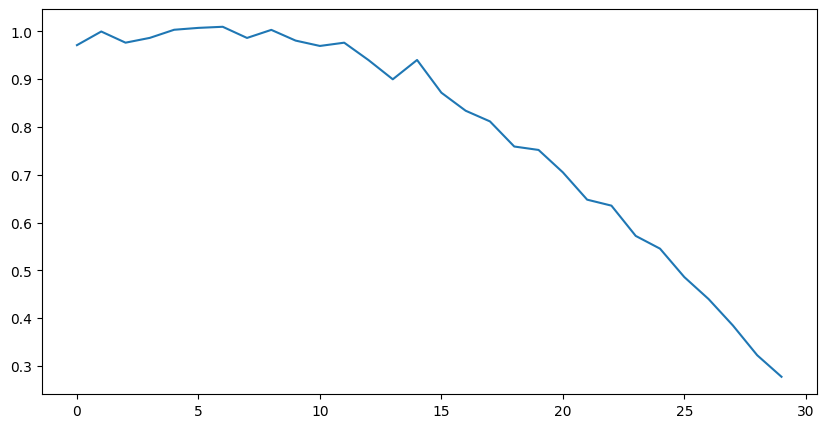

In [437]:
n = 30
d = 3
r = 6
X = np.random.normal(loc = 0, scale = 1, size = (n,r))
from scipy.stats import matrix_normal, multivariate_normal
from sklearn.metrics.pairwise import rbf_kernel

import networkx as nx

G = nx.fast_gnp_random_graph(r, 3/r)

v, u = np.linalg.eigh(nx.laplacian_matrix(G).todense())

H = np.array(np.dot(u, np.diag(np.exp(-0.5*v))).dot(u.T))
print(np.linalg.cond(np.dot(H,H)))


T = np.linspace(1,10,n).reshape(-1,1)
K = rbf_kernel(T,T, gamma = 0.01) + 0.001*np.identity(n)
# print(K[:,0])

omega = 1
F = matrix_normal.rvs(np.zeros((n,r)), rowcov = K, colcov = np.dot(H,H)*(1/omega))

scale = 1
psi = scale*np.identity(d)
psi_inv = np.linalg.inv(psi)

gamma = np.random.normal(loc = 0, scale = 1, size = (n))
epsilon= np.random.normal(loc = 0, scale = scale, size = (n,d))
B_true = np.random.normal(loc = 0.8, scale = 1, size = (d,r))
# B_true = B_true*(np.random.uniform(size = (d,r) ) <0.5)

y = gamma[:, np.newaxis]*np.dot(F, B_true.T) + epsilon

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(F[:,0])
#ax.plot(multivariate_normal.rvs(cov = rbf_kernel(np.linspace(1,10,100).reshape(-1,1),np.linspace(1,10,100).reshape(-1,1), gamma = 0.1)))



F estimators

In [443]:
def F_via_woodbury(n,r,B_true, m,v,psi, K_inv, H, omega, n1 = 2, n2=5, smooth = True):
    from scipy import ndimage
    I_n = np.identity(n)
    I_r = np.identity(r)
    psi_inv = np.linalg.inv(psi)
    B_quad = np.dot(B_true.T, psi_inv).dot(B_true)
    B_quad_pinv = np.linalg.pinv(B_quad )
    #l_b, u_b = eigsh(B_quad,6)
    #B_quad_pinv = np.dot(u_b, np.diag(l_b)).dot(u_b.T)

    M = np.diag(m)
    M_inv = np.diag(1/m)
    S = np.diag(v)
    S_inv = np.diag(1/v)
    MS_inv = np.diag(1/(m**2+v**2))


    H_sq = np.dot(H,H)
    H_sq_inv = np.linalg.inv(H_sq )

    D = np.dot(M,y).dot(psi_inv).dot(B_true).flatten()
    A1 = np.dot(B_quad, H_sq_inv*omega)
    u1, l1, v1t = randomized_svd(A1, n_components =n1)

    A2 = np.dot(K_inv, MS_inv)
    u2, l2, v2t = randomized_svd(A2, n_components =n2)


    im1 = np.kron(np.diag(np.reciprocal(l1)), np.diag(np.reciprocal(l2)))
    # print(np.linalg.cond(im1 + np.matmul(np.kron(v1t, v2t),np.kron(u1, u2))))
    im2 = np.linalg.inv(im1 + np.matmul(np.kron(v1t, v2t),np.kron(u1, u2))) 
    left = np.kron(MS_inv, B_quad_pinv)
    right = np.dot(np.kron(u1,u2), im2).dot(np.kron(v1t,v2t))
    inv_mat = left + np.dot(np.kron(MS_inv,I_r), right).dot(np.kron(I_n,B_quad_pinv))



    F_vec = np.dot(inv_mat, D)
    F_est = np.array(np.reshape(F_vec, (n, r)))

    # Smooth Estimate
    if smooth:
        for j in range(r):
            F_est[:,j] = ndimage.median_filter(F_est[:,j], size=13)

    return F_est


def F_via_woodbury2(n,r,B_true, m,v,psi, K, H, omega, n1 = 2, n2=5, smooth = True):
    from scipy import ndimage
    I_n = np.identity(n)
    I_r = np.identity(r)
    psi_inv = np.linalg.inv(psi)
    B_quad = np.dot(B_true.T, psi_inv).dot(B_true)
    #B_quad_pinv = np.linalg.pinv(B_quad )
    #l_b, u_b = eigsh(B_quad,6)
    #B_quad_pinv = np.dot(u_b, np.diag(l_b)).dot(u_b.T)

    M = np.diag(m)
    #M_inv = np.diag(1/m)
    S = np.diag(v)
    #S_inv = np.diag(1/v)
    #MS_inv = np.diag(1/(m**2+v**2))
    MS = np.diag(m**2+v**2)
    H_sq = np.dot(H,H)
    #H_sq_inv = np.linalg.inv(H_sq )

    D = np.dot(M,y).dot(psi_inv).dot(B_true).flatten()


    A1 = np.dot(H_sq/omega, B_quad)
    u1, l1, v1t = randomized_svd(A1, n_components =n1)

    A2 = np.dot(MS, K)
    u2, l2, v2t = randomized_svd(A2, n_components =n2)


    im1 = np.kron(np.diag(np.reciprocal(l1)), np.diag(np.reciprocal(l2)))
    #print(np.linalg.cond(im1 + np.matmul(np.kron(v1t, v2t),np.kron(u1, u2))))
    im2 = np.linalg.inv(im1 + np.matmul(np.kron(v1t, v2t),np.kron(u1, u2))) 
    left = np.kron(K, H_sq/omega)
    right = np.dot(np.kron(u1,u2), im2).dot(np.kron(v1t,v2t))
    inv_mat = left + np.dot(np.kron(K,I_r), right).dot(np.kron(I_n,H_sq/omega)) + 0.001*np.identity(r*n)
    #print(np.linalg.cond(inv_mat))


    F_vec = np.dot(inv_mat, D)
    F_est = np.array(np.reshape(F_vec, (n, r)))

    # Smooth Estimate
    if smooth:
        for j in range(r):
            F_est[:,j] = ndimage.median_filter(F_est[:,j], size=13)

    return F_est



def F_via_direct_smart(n,r,B_true, m,v,psi, K, H, omega, smooth = True):
    from scipy import ndimage
    I_n = np.identity(n)
    I_r = np.identity(r)
    psi_inv = np.linalg.inv(psi)
    B_quad = np.dot(B_true.T, psi_inv).dot(B_true)
    #B_quad_pinv = np.linalg.pinv(B_quad )
    #l_b, u_b = eigsh(B_quad,6)
    #B_quad_pinv = np.dot(u_b, np.diag(l_b)).dot(u_b.T)

    M = np.diag(m)
    #M_inv = np.diag(1/m)
    S = np.diag(v)
    #S_inv = np.diag(1/v)
    #MS_inv = np.diag(1/(m**2+v**2))
    MS = np.diag(m**2+v**2)
    H_sq = np.dot(H,H)
    #H_sq_inv = np.linalg.inv(H_sq )

    D = np.dot(M,y).dot(psi_inv).dot(B_true).flatten()


    
    A1 = np.dot(H_sq/omega, B_quad)
    A2 = np.dot(MS, K)
    inv_mat = np.dot(np.kron(K,I_r),np.identity(r*n) + np.kron(A1, A2)).dot(np.kron(I_n, H_sq/omega))



    F_vec = np.dot(inv_mat, D)
    F_est = np.array(np.reshape(F_vec, (n, r)))

    # Smooth Estimate
    if smooth:
        for j in range(r):
            F_est[:,j] = ndimage.median_filter(F_est[:,j], size=13)

    return F_est

def F_direct(y,n,r,B_true, m,v,psi_inv, K_inv, H, reg, omega, smooth = True):
    from scipy import ndimage


    B_quad = np.dot(B_true.T, psi_inv).dot(B_true)


    M = np.diag(m)
    #M_inv = np.diag(1/m)
    #S = np.diag(v)
    #S_inv = np.diag(1/v)
    #MS_inv = np.diag(1/(m**2+v**2))
    MS=np.diag(m**2+v**2)
    

    H_sq = np.dot(H,H)
    H_sq_inv = np.linalg.inv(H_sq)

    D = np.dot(M,y).dot(psi_inv).dot(B_true).flatten()


    print(np.linalg.cond(np.kron(B_quad, MS)+ np.kron(omega*H_sq_inv, K_inv))) 
    inv_mat = np.linalg.inv(np.kron(B_quad, MS)+ np.kron(omega*H_sq_inv, K_inv) + reg*np.identity(n*r))
    # print(np.kron(B_quad, MS)+ np.kron(omega*H_sq_inv, K_inv))
    
    F_vec = np.dot(inv_mat, D)
    F_est = np.array(np.reshape(F_vec, (n, r)))


    # Smooth Estimate
    if smooth:
        for j in range(r):
            F_est[:,j] = ndimage.median_filter(F_est[:,j], size=13)

    return F_est, MS, B_quad



def F_optim(Y, n,r,B_true, m,v,psi_inv, K_inv, H, omega):


    
    H_sq = np.dot(H,H)
    H_sq_inv = np.linalg.inv(H_sq)

    K_inv = np.linalg.inv(K)
    Y_tilde = np.vstack((Y, np.zeros((n,d))))
    def objective(param, r, T, m, v, Y_tilde, psi_inv, B, K_inv, omega, H_sq_inv):

        F = np.reshape(param,(T,r))
    
        F_tilde =  np.vstack((m[:,np.newaxis]*F,v[:,np.newaxis]*F))

        obj = 0.5*np.trace(np.dot((Y_tilde-np.dot(F_tilde, B.T)).T, (Y_tilde-np.dot(F_tilde, B.T))).dot(psi_inv))  + 0.5*omega*np.trace(np.dot(K_inv, F).dot(H_sq_inv).dot(F.T))

        return obj
    

    out = minimize(objective, np.ones(n*r), args = (r, n, m, v, Y_tilde, psi_inv, B_true, K_inv, omega, H_sq_inv))




    return np.reshape(out.x,(n,r))



def F_optim_with_grad(Y, n,r,B_true, m,v,psi_inv, K_inv, H, omega):


    
    H_sq = np.dot(H,H)
    H_sq_inv = np.linalg.inv(H_sq)

    K_inv = np.linalg.inv(K)
    Y_tilde = np.vstack((Y, np.zeros((n,d))))
    def objective(param, r, T, m, v, Y_tilde, psi_inv, B, K_inv, omega, H_sq_inv):

        M = np.diag(m)
        S = np.diag(v)

        F = np.reshape(param,(T,r))
    
        F_tilde =  np.vstack((m[:,np.newaxis]*F,v[:,np.newaxis]*F))

        obj = 0.5*np.trace(np.dot((Y_tilde-np.dot(F_tilde, B.T)).T, (Y_tilde-np.dot(F_tilde, B.T))).dot(psi_inv))  + 0.5*omega*np.trace(np.dot(K_inv, F).dot(H_sq_inv).dot(F.T))
        grad = -(np.dot(M,Y).dot(psi_inv).dot(B) - np.dot(M**2+S**2, F).dot(B.T).dot(psi_inv).dot(B) - omega*np.dot(K_inv, F).dot(H_sq_inv)).flatten()

        return obj, grad
    

    out = minimize(objective, np.ones(n*r), args = (r, n, m, v, Y_tilde, psi_inv, B_true, K_inv, omega, H_sq_inv), jac=True, method= 'L-BFGS-B')#, bounds = [(-10, 0)] + [(None, None)]*(n*r-1))




    return np.reshape(out.x,(n,r))

def F_direct_spectral_trim(y,n,r,B_true, m,v,psi_inv, K_inv, H, omega, k, smooth = True):
    from scipy import ndimage
    from scipy.sparse.linalg import eigsh


    B_quad = np.dot(B_true.T, psi_inv).dot(B_true)


    M = np.diag(m)
    #M_inv = np.diag(1/m)
    #S = np.diag(v)
    #S_inv = np.diag(1/v)
    #MS_inv = np.diag(1/(m**2+v**2))
    MS=np.diag(m**2+v**2)
    

    H_sq = np.dot(H,H)
    H_sq_inv = np.linalg.inv(H_sq)

    D = np.dot(M,y).dot(psi_inv).dot(B_true).flatten()


    print(np.linalg.cond(np.kron(B_quad, MS)+ np.kron(omega*H_sq_inv, K_inv))) 
    mat = np.kron(B_quad, MS)+ np.kron(omega*H_sq_inv, K_inv) 

    #l, u = eigsh(inv_mat, k = k)
    l, u = np.linalg.eigh(mat)
    l[l<k] = 0
    inv_l = 1/l
    inv_l[np.isnan(inv_l)] = 0
    inv_l[np.isinf(inv_l)] = 0

    inv_mat = np.dot(u, np.diag(inv_l)).dot(u.T)


    # print(np.kron(B_quad, MS)+ np.kron(omega*H_sq_inv, K_inv))
    
    F_vec = np.dot(inv_mat, D)
    F_est = np.array(np.reshape(F_vec, (n, r)))


    # Smooth Estimate
    if smooth:
        for j in range(r):
            F_est[:,j] = ndimage.median_filter(F_est[:,j], size=13)

    return F_est, u, l, mat



def F_direct_tikanov(y,n,r,B_true, m,v,psi_inv, K_inv, H, omega, k, smooth = True):
    from scipy import ndimage
    from scipy.sparse.linalg import eigsh


    B_quad = np.dot(B_true.T, psi_inv).dot(B_true)


    M = np.diag(m)
    #M_inv = np.diag(1/m)
    #S = np.diag(v)
    #S_inv = np.diag(1/v)
    #MS_inv = np.diag(1/(m**2+v**2))
    MS=np.diag(m**2+v**2)
    

    H_sq = np.dot(H,H)
    H_sq_inv = np.linalg.inv(H_sq)

    D = np.dot(M,y).dot(psi_inv).dot(B_true).flatten()


    print(np.linalg.cond(np.kron(B_quad, MS)+ np.kron(omega*H_sq_inv, K_inv))) 
    mat = np.kron(B_quad, MS)+ np.kron(omega*H_sq_inv, K_inv) 

    #l, u = eigsh(inv_mat, k = k)
    l, u = np.linalg.eigh(mat)
    inv_l = 1/(l+k)

    inv_mat = np.dot(u, np.diag(inv_l)).dot(u.T)


    # print(np.kron(B_quad, MS)+ np.kron(omega*H_sq_inv, K_inv))
    
    F_vec = np.dot(inv_mat, D)
    F_est = np.array(np.reshape(F_vec, (n, r)))


    # Smooth Estimate
    if smooth:
        for j in range(r):
            F_est[:,j] = ndimage.median_filter(F_est[:,j], size=13)

    return F_est, u, l, mat





one EM step

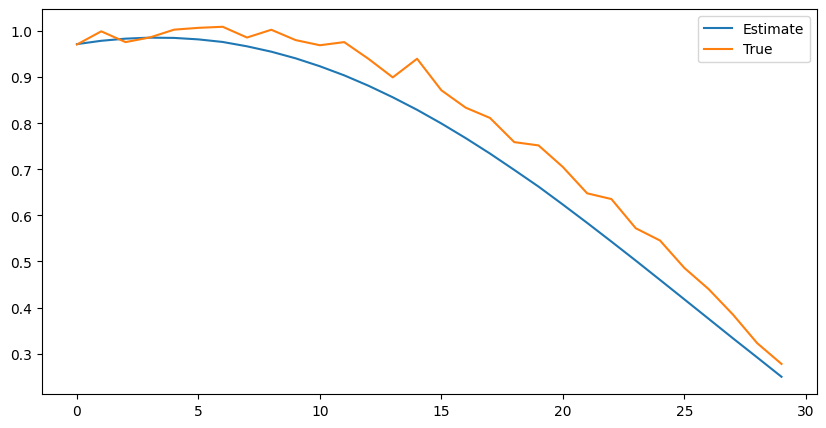

In [439]:
K_inv = np.linalg.inv(K)

d = y.shape[1]
n = X.shape[0]
Y_tilde = np.vstack((y, np.zeros((n,d))))

r = H.shape[1]
iteration = 0
v = np.ones(n)
m = np.ones(n)

for i in range(n):
    v[i] = (1+np.dot(F[i].T, B_true.T).dot(psi_inv).dot(B_true).dot(F[i])) ** (-1)
    m[i] = v[i]*np.dot((y[i]-0).T,psi_inv).dot(B_true).dot(F[i])


#F_est = F_via_woodbury(n,r,B_true, m,v,psi, K_inv, H, omega, n1 = 1, n2=1, smooth = False)
# F_est, MS, B_quad = F_direct(y,n,r,B_true, m,v,psi_inv, K_inv, H, 1, omega, smooth = False)
# F_est = F_via_woodbury2(n,r,B_true, m,v,psi, K, H, omega, n1 = 1, n2=2, smooth = False)
#F_est = F_via_direct_smart(n,r,B_true, m,v,psi, K, H, omega, smooth = False)
#F_est = F_optim(y, n,r,B_true, m,v,psi_inv, K_inv, H, omega)
F_est = F_optim_with_grad(y, n,r,B_true, m,v,psi_inv, K_inv, H, omega)
# F_est, u, l, mat = F_direct_spectral_trim(y,n,r,B_true, m,v,psi_inv, K_inv, H, omega, 3, smooth = True)
# F_est, u, l, mat = F_direct_tikanov(y,n,r,B_true, m,v,psi_inv, K_inv, H, omega, 0.1, smooth = True)
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(F_est[:,0], label = 'Estimate')
ax.plot(F[:,0], label = 'True')
ax.legend()
fig.canvas.draw()
#ax.set_ylim((-5,5))





Multiple EM steps


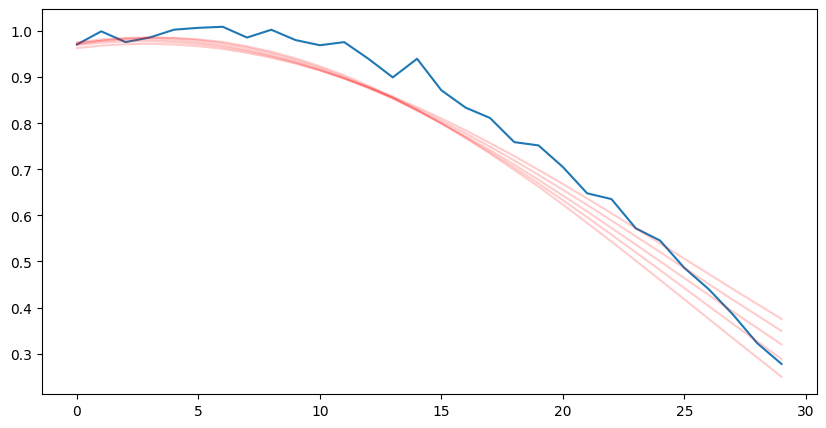

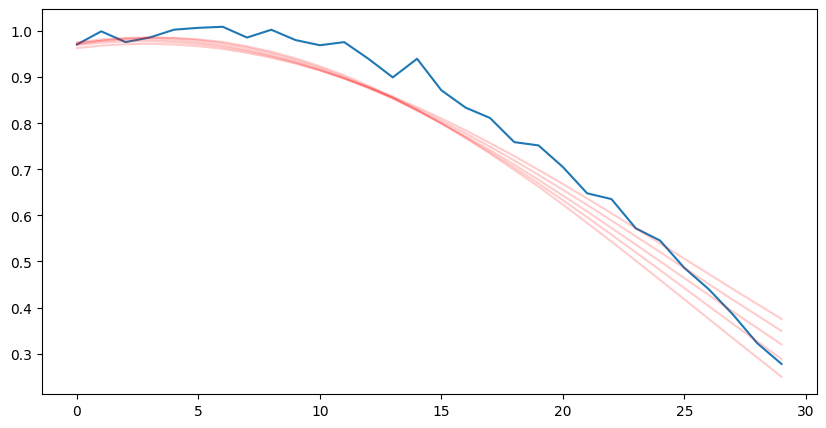

In [445]:
import time
from IPython import display
import pylab as pl
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(F[:,0], label = 'True')
F_est = F.copy()#np.zeros((n,r))#F.copy()
v = np.zeros(n)
m = np.zeros(n)
for j in range(5):
    for i in range(n):
        v[i] = (1+np.dot(F_est[i].T, B_true.T).dot(psi_inv).dot(B_true).dot(F_est[i])) ** (-1)
        m[i] = v[i]*np.dot((y[i]-0).T,psi_inv).dot(B_true).dot(F_est[i])


    #F_est = F_via_woodbury(n,r,B_true, m,v,psi, K_inv, H, omega, n1 = 1, n2=1, smooth = False)
    #F_est, MS, B_quad = F_direct(n,r,B_true, m,v,psi, K_inv, H, 300, omega, smooth = False)
    # F_est = F_via_woodbury2(n,r,B_true, m,v,psi, K, H, omega, n1 = 1, n2=2, smooth = False)
    #F_est = F_via_direct_smart(n,r,B_true, m,v,psi, K, H, omega, smooth = False)
    # F_est = F_optim(y, n,r,B_true, m,v,psi_inv, K_inv, H, omega)
    F_est = F_optim_with_grad(y, n,r,B_true, m,v,psi_inv, K_inv, H, omega)


    ax.plot(F_est[:,0], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    # ax.legend()
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.1)
    #ax.set_ylim((-5,5))


Multiple EM steps, nothing known

In [446]:
def cov_regression_ggp(K, H, omega, Y, alpha, max_itr = 100, tol = 1e-5):
    
    d = Y.shape[1]
    n = X.shape[0]
    Y_tilde = np.vstack((Y, np.zeros((n,d))))

    r = X.shape[1]
    alpha = n*alpha
    iteration = 0

    Psi_pre = np.identity(d)
    v = np.ones(n)
    m = np.ones(n)
    F_pre =  np.ones((n, r))
    F_tilde =np.vstack((m[:,np.newaxis]*F_pre,v[:,np.newaxis]*F_pre))
    # The solution is evry sensitive to the inital matrix, the l2 regularization for B_pre effects alpha
    B_pre = np.ones((d,r))#np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T, X_tilde) + alpha*np.identity(r)))
    K_inv = np.linalg.inv(K)
    H_sq_inv = omega*np.linalg.inv(np.dot(H,H))





    def fun(param, X, Y,Psi_inv, d,r, alpha):
        
        B = np.reshape(param[:r*d]-param[r*d:],(d,r))
        obj =  np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T)))) + alpha*param.sum() #np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T))).dot(Psi_inv)) + alpha*param.sum()
        t_0 = Y.T-np.dot(B,X.T)
        grad = (-0.5*np.dot(t_0,X)).flatten()# (-0.5*np.dot(Psi_inv,t_0).dot(X) ).flatten() #  0.5*alpha*param[:r*d] 
        return obj, np.concatenate((grad + alpha , - grad + alpha ), axis=None) # np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T))).dot(Psi_inv)) + alpha*np.sum(np.abs(B))

    B_tmp = B_pre.flatten()
    B_vec = np.zeros(2*r*d)
    B_vec[:r*d] = np.abs(B_tmp) * (B_tmp>0)
    B_vec[r*d:] = np.abs(B_tmp) * (B_tmp<0)
    # B_pre = np.zeros((r,d))
    while iteration <max_itr:
        Psi_pre_inv = np.linalg.inv(Psi_pre)
        # print(np.linalg.cond(Psi_pre_inv))
        # E-step
        for i in range(n):
            v[i] = (1+np.dot(F_pre[i].T, B_pre.T).dot(Psi_pre_inv).dot(B_pre).dot(F_pre[i])) ** (-1)
            m[i] = v[i]*np.dot((Y[i]-0).T,Psi_pre_inv).dot(B_pre).dot(F_pre[i])

        F_tilde =  np.vstack((m[:,np.newaxis]*F_pre,v[:,np.newaxis]*F_pre))
        # M-step
        out = minimize(fun, B_vec, args = (F_tilde, Y_tilde, Psi_pre_inv,d,r, alpha), method='L-BFGS-B', jac=True, bounds = [(0.0,None)]*(2*r*d))
        B_vec = out.x
        B = np.reshape(out.x[:r*d] - out.x[r*d:], (d,r))
        #inv_m = np.linalg.inv(np.dot(X_tilde.T, X_tilde))
        #B = np.dot(Y_tilde.T,X_tilde).dot(inv_m)

        # Estimate F

        F_new = F_optim_with_grad(y, n,r,B, m,v,Psi_pre_inv, K_inv, H, omega)


        #Psi = np.cov((Y-np.dot(F_new,B.T)).T)*(n-1)/n
        Psi = Psi_pre

        

        if np.linalg.norm(B-B_pre)<tol:
            break

        Psi_pre = Psi.copy()
        B_pre = B.copy()
        F_pre = F_new.copy()
        
        #print(scipy.linalg.norm(B_pre-B_true))
        iteration+=1

    return B, Psi, F_new


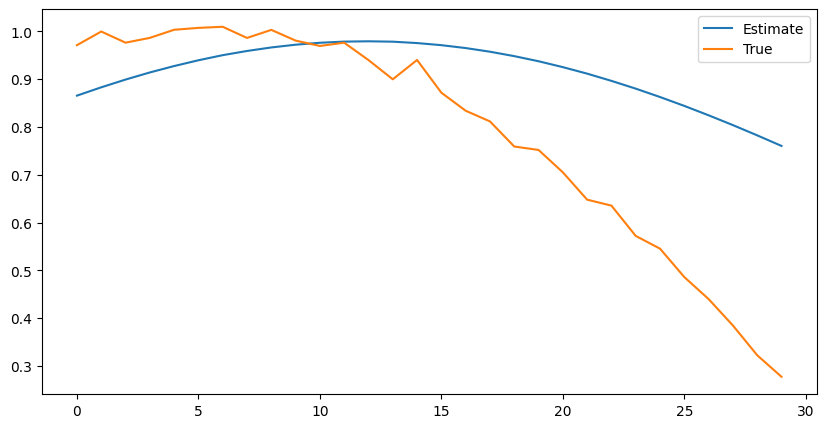

In [447]:
B_est, psi_est, F_est = cov_regression_ggp(K, H, omega, y, 0.001, max_itr = 10, tol = 1e-3)
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(F_est[:,0], label = 'Estimate')
ax.plot(F[:,0], label = 'True')
ax.legend()
fig.canvas.draw()

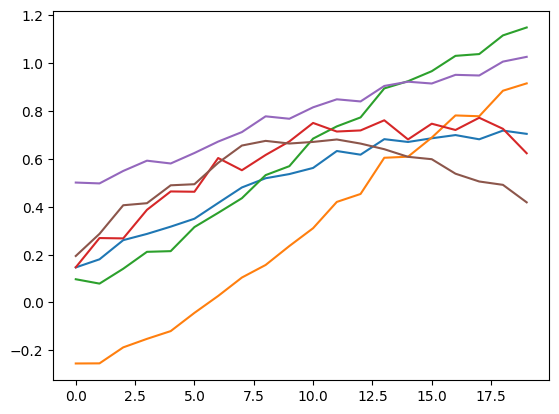

In [331]:
plt.plot(F)

## mean and covariance

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


2.783354272208199


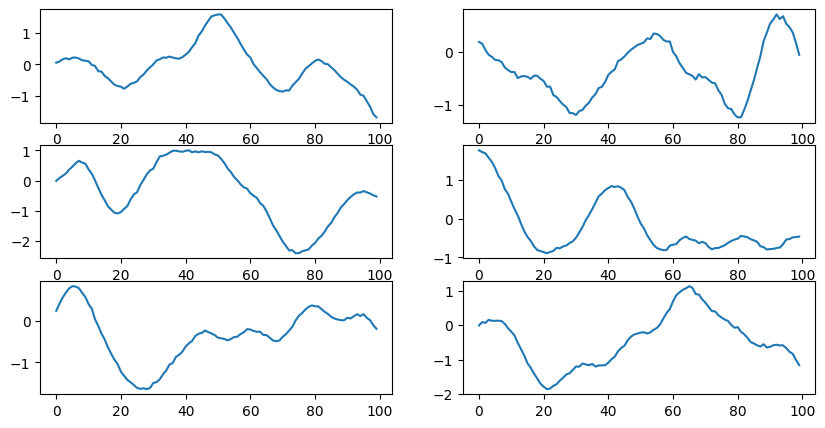

In [3]:


n = 100
d = 3
r = 6
X = np.random.normal(loc = 0, scale = 1, size = (n,r))
from scipy.stats import matrix_normal, multivariate_normal
from sklearn.metrics.pairwise import rbf_kernel

import networkx as nx

G = nx.fast_gnp_random_graph(r, 3/r)

v, u = np.linalg.eigh(nx.laplacian_matrix(G).todense())

H = np.array(np.dot(u, np.diag(np.exp(-0.1*v))).dot(u.T))
print(np.linalg.cond(np.dot(H,H)))


#T  = np.random.normal(loc = 0, scale = 1, size = (n,r)) 
T = np.linspace(1,10,n).reshape(-1,1)
K = rbf_kernel(T,T, gamma = 1) + 0.001*np.identity(n)
# print(K[:,0])

omega = 1
F_true = matrix_normal.rvs(np.zeros((n,r)), rowcov = K, colcov = np.dot(H,H)*(1/omega))

scale = 0.1
psi = scale*np.identity(d)
psi_inv = np.linalg.inv(psi)

gamma = np.random.normal(loc = 0, scale = 1, size = (n))
epsilon= np.random.normal(loc = 0, scale = scale, size = (n,d))
#B_true = np.random.normal(loc = 0, scale = 0, size = (d,r))
#A_true = np.random.normal(loc = 0, scale = 0, size = (d,r))
A_true = np.random.uniform(-0.01,0.01,size = (d,r))
B_true = np.random.uniform(-1,1,size = (d,r))#*0
B_true = B_true*(np.random.uniform(size = (d,r) ) <0.5)
A_true = A_true*(np.random.uniform(size = (d,r) ) <0.5)

y = np.dot(F_true, A_true.T) +  gamma[:, np.newaxis]*np.dot(F_true, B_true.T) + epsilon

fig, ax = plt.subplots(3,2, figsize = (10,5))
ax[0,0].plot(F_true[:,0])
ax[0,1].plot(F_true[:,1])
ax[1,0].plot(F_true[:,2])
ax[1,1].plot(F_true[:,3])
ax[2,0].plot(F_true[:,4])
ax[2,1].plot(F_true[:,5])
#ax.plot(multivariate_normal.rvs(cov = rbf_kernel(np.linspace(1,10,100).reshape(-1,1),np.linspace(1,10,100).reshape(-1,1), gamma = 0.1)))



In [1283]:
x = np.array(([[1,2,3], 
           [1,2,3]])).flatten('F')
print(x)
np.reshape(x,(2,3), 'F')

[1 1 2 2 3 3]


array([[1, 2, 3],
       [1, 2, 3]])

In [5]:
def F_with_mean_cov_optim(Y, n,r,B_true, A_true, m,v,psi_inv, K_inv, H, omega):


    
    H_sq = np.dot(H,H)
    H_sq_inv = np.linalg.inv(H_sq)

    K_inv = np.linalg.inv(K)
    Y_tilde = np.vstack((Y, np.zeros((n,d))))
    def objective(param, r, T, m, v, Y_tilde, psi_inv, B,A, K_inv, omega, H_sq_inv):

        F = np.reshape(param,(T,r))
    
        
        F_tilde =  np.vstack((np.hstack((F, m[:,np.newaxis]*F)),np.hstack((np.zeros((T, r)),v[:,np.newaxis]*F))))
        C = np.hstack((A,B))


        obj = 0.5*np.trace(np.dot((Y_tilde-np.dot(F_tilde, C.T)).T, (Y_tilde-np.dot(F_tilde, C.T))).dot(psi_inv))  + 0.5*omega*np.trace(np.dot(K_inv, F).dot(H_sq_inv).dot(F.T))

        return obj
    

    out = minimize(objective, np.ones(n*r), args = (r, n, m, v, Y_tilde, psi_inv, B_true, A_true, K_inv, omega, H_sq_inv))




    return np.reshape(out.x,(n,r))



def F_with_mean_cov_optim_with_grad(Y, n,r,B_true, A_true, m,v,psi_inv, K_inv, H, omega):


    
    H_sq = np.dot(H,H)
    H_sq_inv = np.linalg.inv(H_sq)

    K_inv = np.linalg.inv(K)
    Y_tilde = np.vstack((Y, np.zeros((n,d))))
    def objective(param, r, T, m, v, Y_tilde, psi_inv, B,A, K_inv, omega, H_sq_inv):

        M = np.diag(m)
        S = np.diag(v)

        F = np.reshape(param,(T,r), order='F')
    
        F_tilde =  np.vstack((np.hstack((F, m[:,np.newaxis]*F)),np.hstack((np.zeros((T, r)),v[:,np.newaxis]*F))))
        C = np.hstack((A,B))

        obj = 0.5*np.trace(np.dot((Y_tilde-np.dot(F_tilde, C.T)).T, (Y_tilde-np.dot(F_tilde, C.T))).dot(psi_inv))  + 0.5*omega*np.trace(np.dot(K_inv, F).dot(H_sq_inv).dot(F.T))
        
        grad1 = -np.dot(M,Y).dot(psi_inv).dot(B) -np.dot(Y,psi_inv).dot(A) 
        grad2 = np.dot(F,A.T).dot(psi_inv).dot(A)
        grad3 = np.dot(M, F).dot(A.T).dot(psi_inv).dot(B) + np.dot(M, F).dot(B.T).dot(psi_inv).dot(A)
        grad4 = np.dot(M**2+S**2,F).dot(B.T).dot(psi_inv).dot(B)

        grad = (grad1 +grad2+grad3+grad4+ omega*np.dot(K_inv, F).dot(H_sq_inv)).flatten(order='F')

        return obj, grad
    

    out = minimize(objective, np.ones(n*r), args = (r, n, m, v, Y_tilde, psi_inv, B_true, A_true, K_inv, omega, H_sq_inv), jac=True, method= 'L-BFGS-B')#, bounds = ([(0, 10)] + [(None, None)]*(n*r-1))




    return np.reshape(out.x,(n,r), order='F')



def F_ls(y, A, psi_inv):

    A_quad = np.dot(A.T, psi_inv).dot(A)
    F_ls_no_graph = np.dot(y, psi_inv).dot(A).dot(np.linalg.pinv(A_quad)) # 0.000001*np.identity(A.shape[1])


    return F_ls_no_graph

def F_ls_kron(y,A,psi_inv):
    A_quad = np.dot(A.T, psi_inv).dot(A)
    inv_mat = np.linalg.inv(np.kron(A_quad, np.identity(y.shape[0])))
    F =  np.dot( inv_mat, np.dot(y, psi_inv).dot(A).flatten())
    return F
    

def F_ls_reg(y, A, psi_inv, K, H, omega, reg, type_reg ):
    # n = y.shape[0]
    # r = H.shape[0]
    # H_sq = np.dot(H,H)
    # H_sq_inv = omega*np.linalg.inv(H_sq)
    # K_inv = np.linalg.inv(K)
    # A_quad = np.dot(A.T, psi_inv).dot(A)

    # # mat = np.kron(H_sq_inv+0.1*np.identity(r), K_inv+0.1*np.identity(n)) + np.kron(A_quad+0.1*np.identity(r), np.identity(n))
    # mat = np.kron(H_sq_inv, K_inv) + np.kron(A_quad, np.identity(n))
    # l, u = np.linalg.eigh(mat)
    # if type_reg == 'Tikanov':
    #     inv_mat = np.dot(u, np.diag(1/(l+reg))).dot(u.T)
    # elif type_reg == 'spectral':
    #     l_inv = 1/l
    #     l_inv[l<reg] = 0
    #     inv_mat = np.dot(u, np.diag(l_inv)).dot(u.T)
    # F_ls = np.dot( inv_mat, np.dot(y, psi_inv).dot(A).flatten(order='F'))
    # F_ls = np.reshape(F_ls,(n,r), order='F')


    n = y.shape[0]
    r = H.shape[0]
    I_n = np.identity(n)
    I_r = np.identity(r)

    H_sq = np.dot(H,H)
    H_sq_inv = omega*np.linalg.inv(H_sq)
    K_inv = np.linalg.inv(K)
    A_quad = np.dot(A.T, psi_inv).dot(A)

    mat = np.kron(A_quad, I_n) + np.kron(H_sq_inv,K_inv)
    l, u = np.linalg.eigh(mat)
    if type_reg == 'Tikanov':
        inv_mat = np.dot(u, np.diag(1/(l+reg))).dot(u.T)
    elif type_reg == 'spectral':
        l_inv = 1/l
        l_inv[l<reg] = 0
        inv_mat = np.dot(u, np.diag(l_inv)).dot(u.T)

    F = np.dot(inv_mat, np.dot(y, psi_inv).dot(A).flatten(order='F'))
    return np.reshape(F,(n,r), order='F')



def F_cov_no_graph(Y, B, m,v,psi_inv):

    M = np.diag(m)
    S = np.diag(v)
    inv_em = np.linalg.inv(M**2+S**2)
    B_quad = np.dot(B.T, psi_inv).dot(B)

    F = np.dot(inv_em, M).dot(Y).dot(psi_inv).dot(B).dot(np.linalg.pinv(B_quad))
    return F


def F_cov_reg(y, B, m,v, psi_inv, K, H, omega, reg, type_reg ):
    n = y.shape[0]
    r = H.shape[0]
    M = np.diag(m)
    S = np.diag(v)
    H_sq = np.dot(H,H)
    H_sq_inv = omega*np.linalg.inv(H_sq)
    K_inv = np.linalg.inv(K)
    B_quad = np.dot(B.T, psi_inv).dot(B)

    # mat = np.kron(H_sq_inv+0.1*np.identity(r), K_inv+0.1*np.identity(n)) + np.kron(A_quad+0.1*np.identity(r), np.identity(n))
    mat = np.kron(H_sq_inv, K_inv) + np.kron(B_quad, M**2+S**2)
    l, u = np.linalg.eigh(mat)
    if type_reg == 'Tikanov':
        inv_mat = np.dot(u, np.diag(1/(l+reg))).dot(u.T)
    elif type_reg == 'spectral':
        l_inv = 1/l
        l_inv[l<reg] = 0
        inv_mat = np.dot(u, np.diag(l_inv)).dot(u.T)
    F_ls = np.dot( inv_mat, np.dot(M, y).dot(psi_inv).dot(B).flatten())
    F_ls = np.reshape(F_ls,(n,r))

    return F_ls


def F_direct(Y, n,r,B, A, m,v,psi_inv, K_inv, H, omega, reg, type_reg):
    n = y.shape[0]
    r = H.shape[0]
    I_n = np.identity(n)
    I_r = np.identity(r)
    M = np.diag(m)
    S = np.diag(v)

    H_sq = np.dot(H,H)
    H_sq_inv = omega*np.linalg.inv(H_sq)
    K_inv = np.linalg.inv(K)
    B_quad = np.dot(B.T, psi_inv).dot(B)
    A_quad = np.dot(A.T, psi_inv).dot(A)
    AB_quad = np.dot(A.T, psi_inv).dot(B)

    mat = np.kron(A_quad, I_n) + np.kron(AB_quad+AB_quad.T, M) + np.kron(B_quad, M**2+S**2) + np.kron(H_sq_inv,K_inv)
    l, u = np.linalg.eigh(mat)
    if type_reg == 'Tikanov':
        inv_mat = np.dot(u, np.diag(1/(l+reg))).dot(u.T)
    elif type_reg == 'spectral':
        l_inv = 1/l
        l_inv[l<reg] = 0
        inv_mat = np.dot(u, np.diag(l_inv)).dot(u.T)

    F = np.dot(inv_mat, (np.dot(y, psi_inv).dot(A) + np.dot(M, y).dot(psi_inv).dot(B)).flatten(order='F'))
    return np.reshape(F,(n,r), order='F')






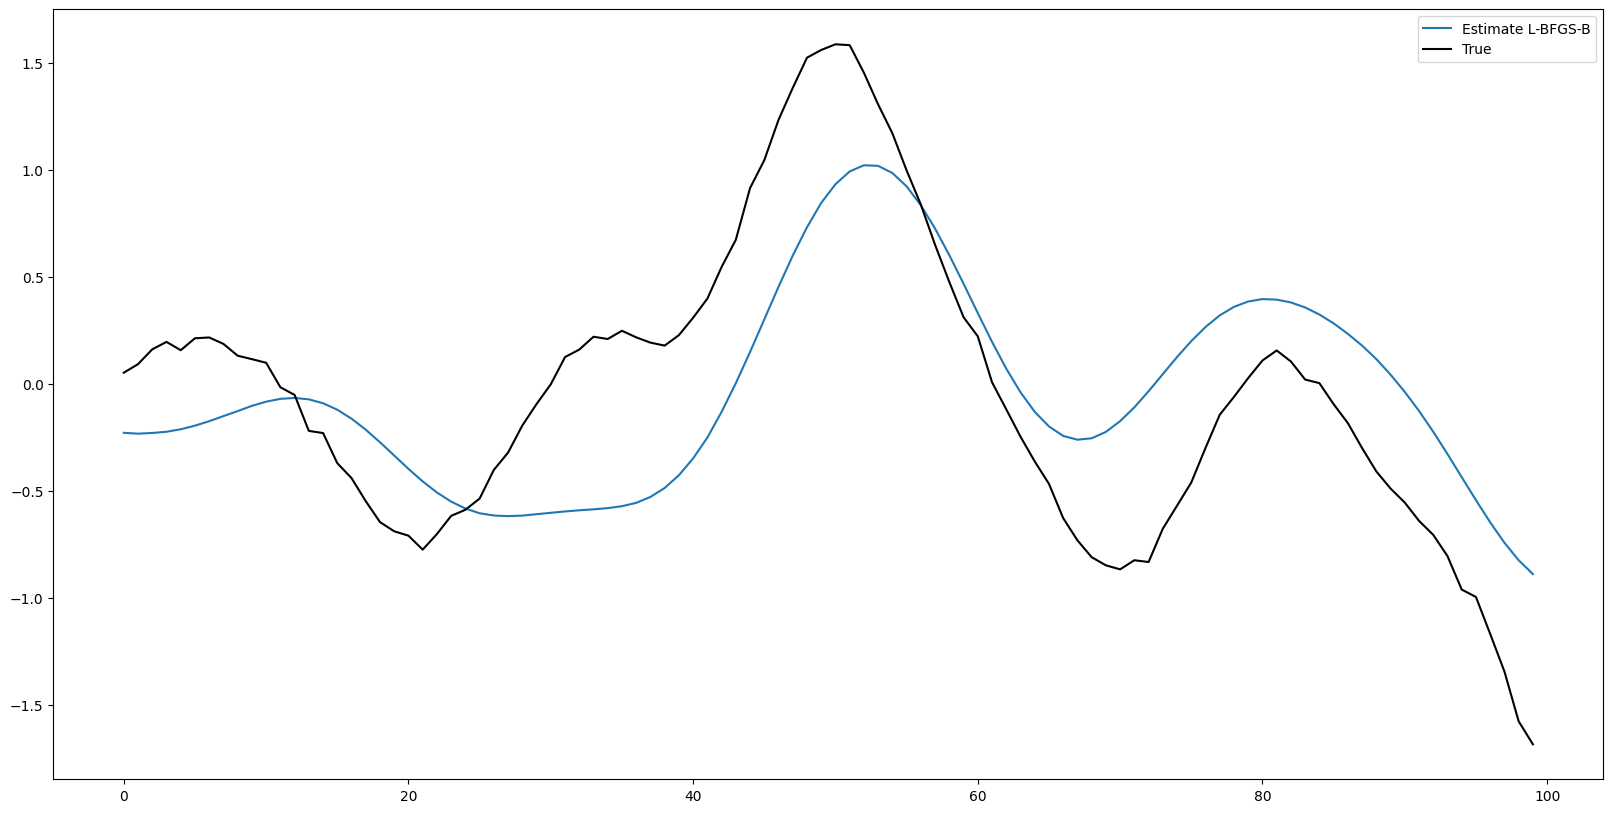

In [6]:
K_inv = np.linalg.inv(K)

d = y.shape[1]
n = X.shape[0]
Y_tilde = np.vstack((y, np.zeros((n,d))))

r = H.shape[1]
iteration = 0
v = np.ones(n)
m = np.ones(n)

for i in range(n):
    v[i] = (1+np.dot(F_true[i].T, B_true.T).dot(psi_inv).dot(B_true).dot(F_true[i])) ** (-1)
    m[i] = v[i]*np.dot((y[i]-np.dot(A_true, F_true[i])).T,psi_inv).dot(B_true).dot(F_true[i])

#F_est = F_with_mean_cov_optim(y, n,r,B_true,A_true, m,v,psi_inv, K_inv, H, omega)
F_est_with_grad = F_with_mean_cov_optim_with_grad(y, n,r,B_true,A_true, m,v,psi_inv, K_inv, H, omega)
#F_est_ls = F_ls(y, A_true, psi_inv)
#F_est_ls_kron = F_ls(y, A_true, psi_inv)
#F_est_ls_reg = F_ls_reg(y, A_true, psi_inv, K, H, omega, 1, 'Tikanov')
#F_est_cov_no_graph = F_cov_no_graph(y, B_true, m,v,psi_inv)
#F_est_cov_reg = F_cov_reg(y, B_true, m,v, psi_inv, K, H, omega, 10, 'Tikanov' )
#F_est_direct = F_direct(y, n,r,B_true, A_true, m,v,psi_inv, K_inv, H, omega, 0, 'Tikanov' )

fig, ax = plt.subplots(1,1, figsize = (20,10))
ax.plot(F_est_with_grad[:,0], label = 'Estimate L-BFGS-B')
#ax.plot(F_est_ls[:,0], label = 'Estimate LS')
#ax.plot(F_est_ls_kron[:,0], label = 'Estimate LS kron', linestyle = '--')
#ax.plot(F_est_ls_reg[:,0], label = 'Estimate LS with graph')
#ax.plot(F_est_cov_no_graph[:,0], label = 'Estimate only cov no graph')
#ax.plot(F_est_cov_reg[:,0], label = 'Estimate only cov')
#ax.plot(F_est_direct[:,0], label = 'Estimate direct', linestyle = '--')
ax.plot(F_true[:,0], label = 'True', color ='black')
ax.legend()
fig.canvas.draw()
#ax.set_ylim((-5,5))


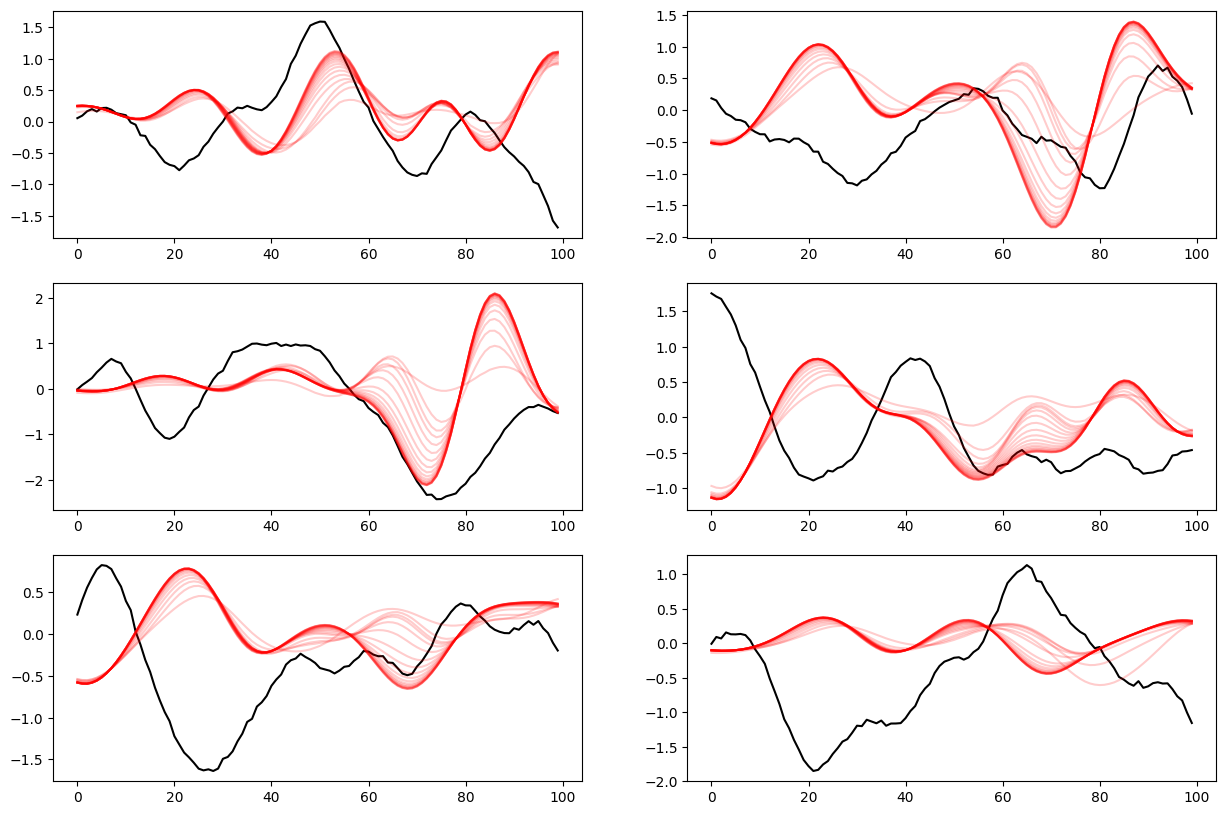

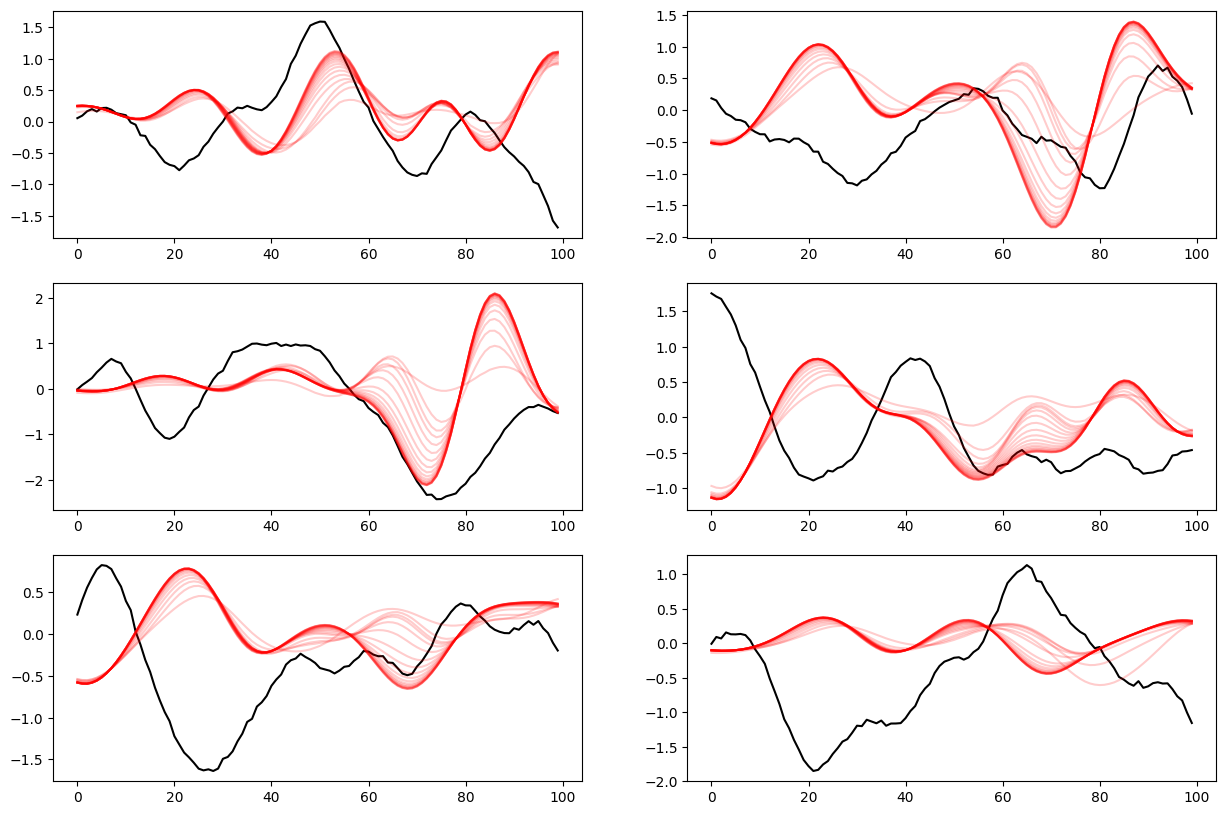

In [9]:
import time
from IPython import display
import pylab as pl
fig, ax = plt.subplots(3,2, figsize = (15,10))
ax[0,0].plot(F_true[:,0], label = 'True', color = 'black')
ax[0,1].plot(F_true[:,1], label = 'True', color = 'black')
ax[1,0].plot(F_true[:,2], label = 'True', color = 'black')
ax[1,1].plot(F_true[:,3], label = 'True', color = 'black')
ax[2,0].plot(F_true[:,4], label = 'True', color = 'black')
ax[2,1].plot(F_true[:,5], label = 'True', color = 'black')



#F_est = F_true.copy()
F_est_ls = F_ls_reg(y, A_true, psi_inv, K, H, omega, 1, 'Tikanov')
F_tmp = np.random.multivariate_normal(mean = F_est_ls.flatten(), cov = 1*np.identity(y.shape[0]*F_est_ls.shape[1]))
F_est = np.reshape(F_tmp,(n,r))
v = np.zeros(n)
m = np.zeros(n)
for j in range(20):
    for i in range(n):
        v[i] = (1+np.dot(F_est[i].T, B_true.T).dot(psi_inv).dot(B_true).dot(F_est[i])) ** (-1)
        m[i] = v[i]*np.dot((y[i]-np.dot(A_true, F_est[i])).T,psi_inv).dot(B_true).dot(F_est[i])

    #F_est = F_with_mean_cov_optim(y, n,r,B_true, A_true, m,v,psi_inv, K_inv, H, omega)
    F_est = F_with_mean_cov_optim_with_grad(y, n,r,B_true,A_true, m,v,psi_inv, K_inv, H, omega)
    # F_est = F_direct(y, n,r,B_true, A_true, m,v,psi_inv, K_inv, H, omega, 1, 'Tikanov' )
    F_est = F_est


    ax[0,0].plot(F_est[:,0], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    ax[0,1].plot(F_est[:,1], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    ax[1,0].plot(F_est[:,2], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    ax[1,1].plot(F_est[:,3], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    ax[2,0].plot(F_est[:,4], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    ax[2,1].plot(F_est[:,5], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    # ax.legend()
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.1)
    #ax.set_ylim((-5,5))


EM everything unknown

In [13]:
def I(r,d):
    A = []
    for _ in range(r):
        i = np.random.random_integers(0, d-1)
        A.append([1 if j == i else 0 for j in range(d)])
    return np.array(A)

I(d,r)

C:\Users\User\AppData\Local\Temp\ipykernel_18468\1383062069.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 5 + 1) instead
  i = np.random.random_integers(0, d-1)


array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

In [12]:

def C_secant(Y, F,d,r, m,v,psi_inv):



    Y_tilde = np.vstack((Y, np.zeros((n,d))))
    F_tilde =  np.vstack((np.hstack((F, m[:,np.newaxis]*F)),np.hstack((np.zeros((n, r)),v[:,np.newaxis]*F))))
    def objective(param, r, d, Y_tilde, psi_inv, F_tilde):

        C = np.reshape(param,(d,2*r), order='F')


        obj = 0.5*np.trace(np.dot((Y_tilde-np.dot(F_tilde, C.T)).T, (Y_tilde-np.dot(F_tilde, C.T))).dot(psi_inv)) 
        
        grad = np.dot(psi_inv, (Y_tilde.T - np.dot(C, F_tilde.T))).dot(F_tilde).flatten(order='F')

        return obj, grad
    

    out = minimize(objective, np.ones(d*r*2), args = (r, d, Y_tilde, psi_inv, F_tilde), jac=True, method= 'L-BFGS-B', bounds = [(-1, 1)]*(d*r*2))


    return np.reshape(out.x,(d,2*r), order='F')

In [1288]:
A_est = np.ones((d, r))# I(d,r)#np.zeros((d, r)) #A_true.copy()#np.random.uniform(size = (d, r))#
B_est = np.ones((d,r))*0#B_true.copy()#np.zeros((d, r)) #np.random.uniform(size = (d, r))#
psi_est = np.cov(y.T)


row_sums = A_est.sum(axis=1)
A_est = A_est / row_sums[:, np.newaxis]
A_est

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]])

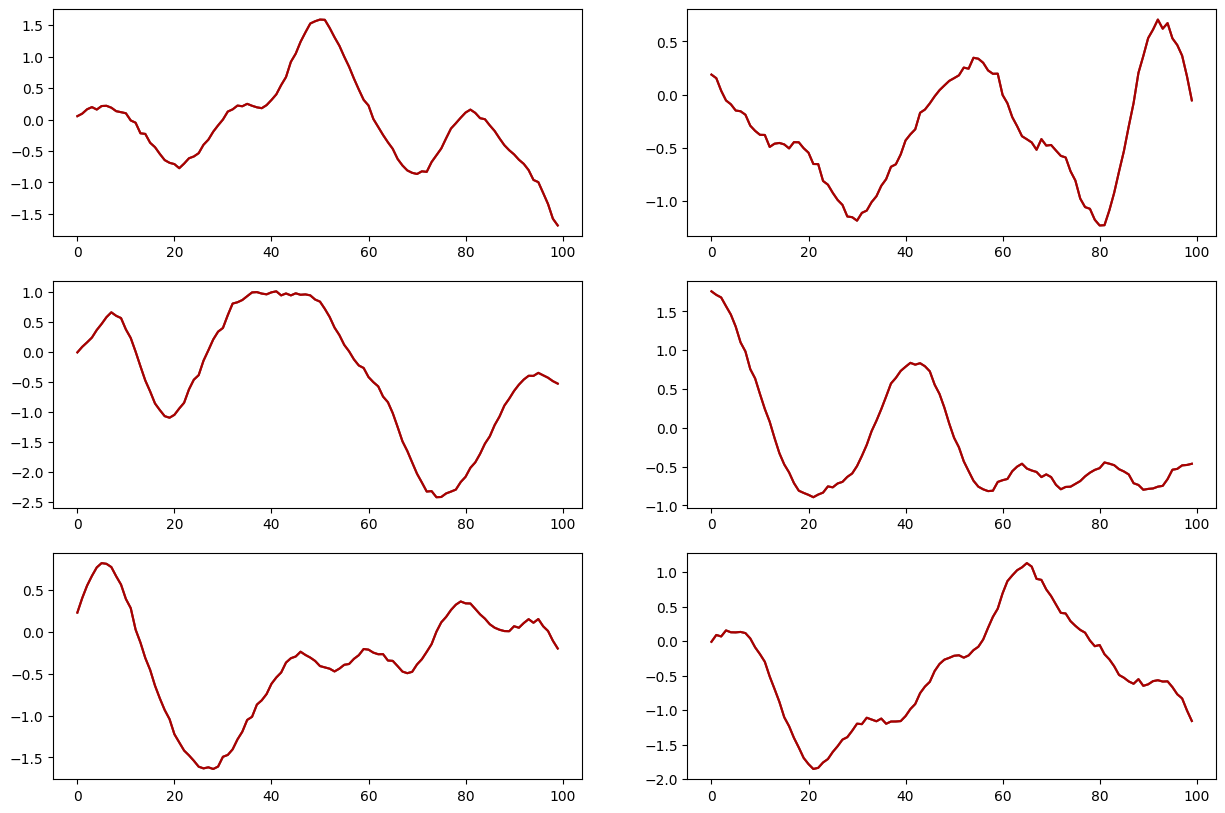

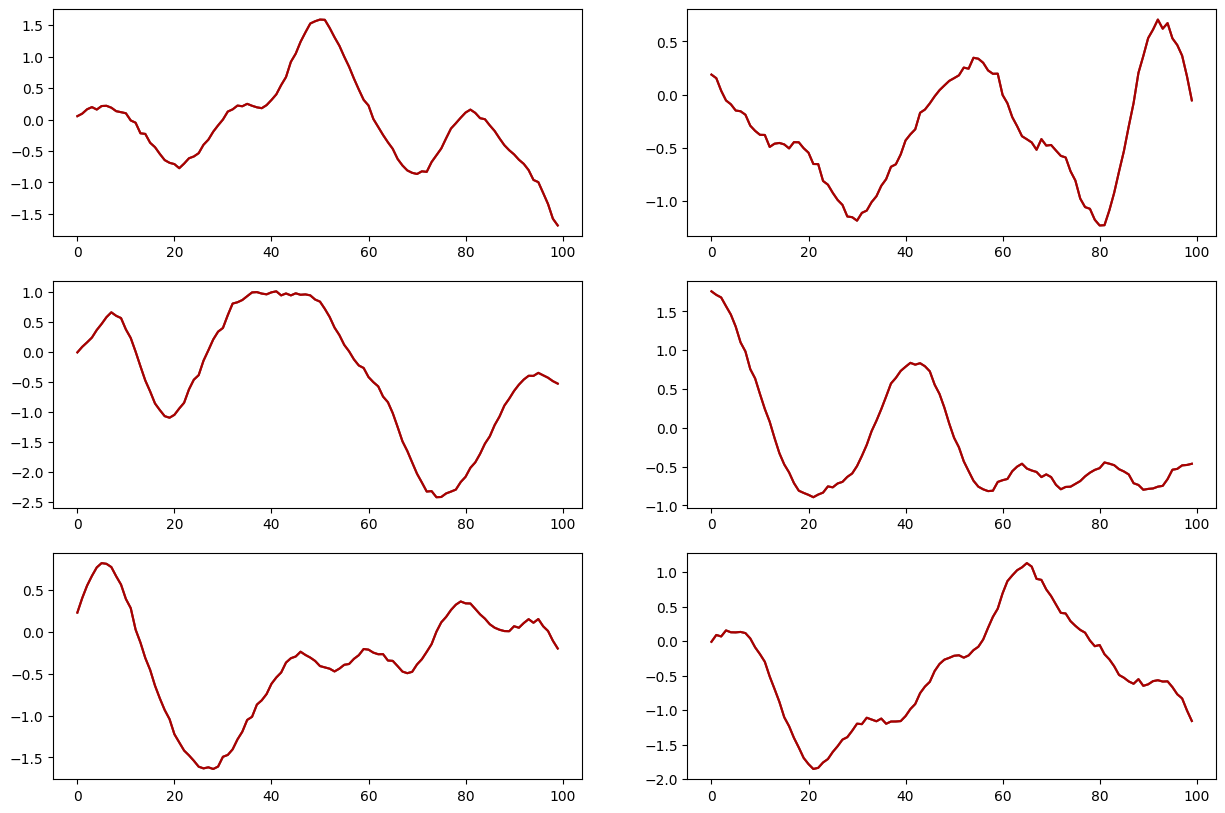

In [14]:
import time
from IPython import display
import pylab as pl
fig, ax = plt.subplots(3,2, figsize = (15,10))
ax[0,0].plot(F_true[:,0], label = 'True', color = 'black')
ax[0,1].plot(F_true[:,1], label = 'True', color = 'black')
ax[1,0].plot(F_true[:,2], label = 'True', color = 'black')
ax[1,1].plot(F_true[:,3], label = 'True', color = 'black')
ax[2,0].plot(F_true[:,4], label = 'True', color = 'black')
ax[2,1].plot(F_true[:,5], label = 'True', color = 'black')

A_est = I(d,r)#np.ones((d, r))# I(d,r)#np.zeros((d, r)) #A_true.copy()#np.random.uniform(size = (d, r))#
B_est = I(d,r)#np.ones((d,r))#B_true.copy()#np.zeros((d, r)) #np.random.uniform(size = (d, r))#
psi_est = np.identity(d)#np.cov(y.T)


# row_sums = A_est.sum(axis=1)
# A_est = A_est / row_sums[:, np.newaxis]
# print(A_est)

# row_sums = B_est.sum(axis=1)
# B_est = B_est / row_sums[:, np.newaxis]
# print(B_est)



F_est = F_true.copy()#np.random.uniform(size = (n,r))#F.copy()
#F_est = F_ls_reg(y, A_true, psi_inv, K, H, omega, 1, 'Tikanov')
v = np.zeros(n)
m = np.zeros(n)
for j in range(5):
    psi_inv_est = np.linalg.inv(psi_est)
    for i in range(n):
        v[i] = (1+np.dot(F_est[i].T, B_est.T).dot(psi_inv).dot(B_est).dot(F_est[i])) ** (-1)
        m[i] = v[i]*np.dot((y[i]-np.dot(A_est, F_est[i])).T,psi_inv_est).dot(B_est).dot(F_est[i])



    #F_est = F_with_mean_cov_optim(y, n,r,B_true, A_true, m,v,psi_inv, K_inv, H, omega)
    #F_est = F_with_mean_cov_optim_with_grad(y, n,r,B_est,A_est, m,v,psi_inv_est, K_inv, H, omega)
    #F_est = F_direct(y, n,r,B_est, A_est, m,v,psi_inv_est, K_inv, H, omega, 3, 'Tikanov' )
    #F_est = F_direct(y, n,r,B_est, A_est, m,v,psi_inv_est, K_inv, H, omega, 1, 'Tikanov' )
    #F_est = F_est
    ##print(F_est)

    Y_tilde = np.vstack((y, np.zeros((n,d))))
    F_tilde =  np.vstack((np.hstack((F_est, m[:,np.newaxis]*F_est)),np.hstack((np.zeros((n, r)),v[:,np.newaxis]*F_est))))

    C = np.dot(Y_tilde.T, F_tilde).dot(np.linalg.inv(np.dot(F_tilde.T,F_tilde) + 0.0000001*np.identity(2*r)))
    #C = C_secant(y, F_est, d,r,m,v, psi_inv_est)
    #C =C/np.max(np.abs(C))
    A_est = C[:,:r]
    B_est = C[:,r:]

    psi_est = np.dot((Y_tilde - np.dot(F_tilde, C.T)).T, (Y_tilde - np.dot(F_tilde, C.T)))/n


    ax[0,0].plot(F_est[:,0], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    ax[0,1].plot(F_est[:,1], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    ax[1,0].plot(F_est[:,2], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    ax[1,1].plot(F_est[:,3], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    ax[2,0].plot(F_est[:,4], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    ax[2,1].plot(F_est[:,5], label = f'Estimate {j}', color = 'red', alpha = 0.2)
    # ax.legend()
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.1)
    #ax.set_ylim((-5,5))


In [15]:
psi_est + np.dot(B_est, np.outer(F_est[0],F_est[0])).dot(B_est.T)

array([[ 0.02094947,  0.00913611, -0.00291106],
       [ 0.00913611,  0.02368095, -0.00406012],
       [-0.00291106, -0.00406012,  0.01860807]])

In [16]:
psi + np.dot(B_true, np.outer(F_true[0],F_true[0])).dot(B_true.T)

array([[0.10548134, 0.01072774, 0.06057169],
       [0.01072774, 0.12099565, 0.11854706],
       [0.06057169, 0.11854706, 0.76934854]])

In [17]:
B_est

array([[ 0.05344165,  0.01163352, -0.03572292,  0.00118432,  0.00109418,
         0.00206564],
       [ 0.05253158,  0.04229591, -0.01471733,  0.00909922,  0.00227334,
         0.00213352],
       [-0.08956142, -0.00743436,  0.03139772,  0.0334905 ,  0.02609569,
        -0.00558202]])

In [18]:
B_true

array([[ 0.53007637, -0.        , -0.41595844,  0.        ,  0.1769119 ,
         0.        ],
       [ 0.43455698,  0.36474352, -0.        ,  0.        ,  0.23045416,
        -0.        ],
       [-0.76414741,  0.07214025,  0.27733413,  0.48288559, -0.        ,
        -0.        ]])

In [1268]:
np.dot(A_est,F_est[0])

array([ 0.82690311, -4.91524068,  7.09320366])

In [1269]:
A_true

array([[ 0.        , -0.        , -0.67485485, -0.43894822, -0.09308087,
        -0.10620171],
       [ 0.4040253 , -0.82651001, -0.11830038,  0.        , -0.31311624,
         0.        ],
       [ 0.23618231,  0.        , -0.83501564,  0.39319177,  0.        ,
        -0.        ]])

In [1270]:
A_est

array([[ -4.09858835,   2.62984767,   0.03929446,   1.30799057,
         -4.03575283,   5.86178968],
       [  2.44721319,   4.5696127 ,  -0.20465251,  -5.38395345,
         -2.31705755,   6.38098971],
       [-13.63448194,   0.52560613,  -0.16796417,  12.2088669 ,
         -6.50113149,   6.90354924]])

new formula

3.170856280387483e-10
0.08531514741185019


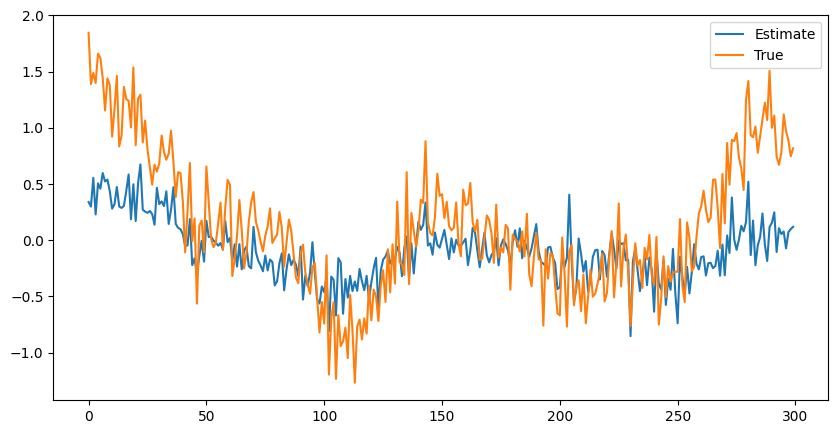

In [85]:
I_n = np.identity(n)
I_r = np.identity(r)
psi_inv = np.linalg.inv(psi)
Gamma = np.diag(gamma)
Gamma_inv = np.diag(1/gamma)
B_quad = np.dot(B_true.T, psi_inv).dot(B_true)

v,u = np.linalg.eigh(B_quad)

#v[v<0.01] = 99999999999

#F_est = np.dot(Gamma_inv, y).dot(B_true).dot(np.dot(u, np.diag(1/v)).dot(u.T))

F_est = np.dot(Gamma_inv + 0*I_n, y).dot(psi_inv).dot(B_true).dot(np.linalg.inv(B_quad + 0.0001*I_r))

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(F_est[:,0], label = 'Estimate')
ax.plot(F[:,0], label = 'True')
ax.legend()

m_est = gamma[:, np.newaxis]*np.dot(F_est, B_true.T)
m_true = gamma[:, np.newaxis]*np.dot(F, B_true.T)
print(np.trace(np.dot((y-m_est).T,(y-m_est))))
print(np.trace(np.dot((y-m_true).T,(y-m_true))))

Estimate everything known

9347.917099514454
0.08531514741185019


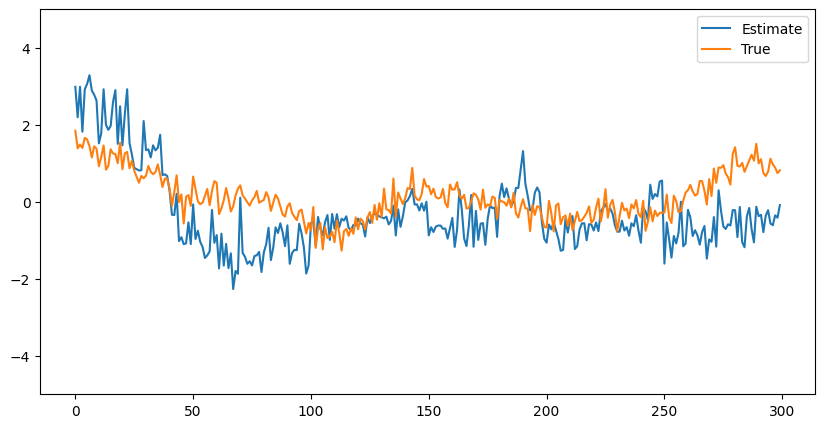

In [86]:

I_n = np.identity(n)
I_r = np.identity(r)
psi_inv = np.linalg.inv(psi)

Gamma = np.diag(gamma)
Gamma_inv = np.diag(1/gamma)
A = np.dot(Gamma_inv**2,np.linalg.inv(K))

H_sq = np.dot(H,H)
B_quad = np.dot(B_true.T, psi_inv).dot(B_true)

C = np.dot(B_quad, H_sq)/omega

D = np.dot(Gamma_inv,y).dot(psi_inv).dot(B_true).dot(H_sq).flatten()/omega

inv_mat = np.linalg.inv(np.kron(I_r, A)+ np.kron(C.T, I_n) + 100*np.identity(n*r))
#print(np.linalg.cond(inv_mat))
F_vec = np.dot(inv_mat, D)
F_est = np.array(np.reshape(F_vec, (n, r)))

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(F_est[:,0], label = 'Estimate')
ax.plot(F[:,0], label = 'True')
ax.legend()
ax.set_ylim((-5,5))

m_est = gamma[:, np.newaxis]*np.dot(F_est, B_true.T)
m_true = gamma[:, np.newaxis]*np.dot(F, B_true.T)
print(np.trace(np.dot((y-m_est).T,(y-m_est))))
print(np.trace(np.dot((y-m_true).T,(y-m_true))))

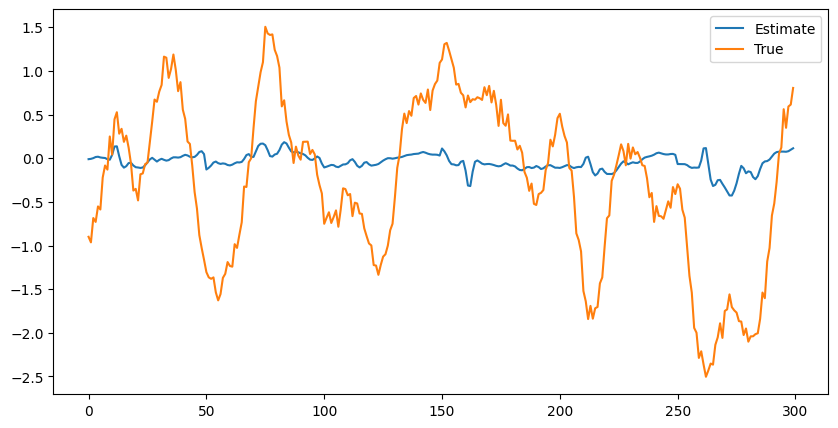

In [31]:

I_n = np.identity(n)
I_r = np.identity(r)

Gamma = np.diag(gamma)
A = np.dot(K,Gamma**2)

H_sq_inv = np.linalg.inv(np.dot(H,H))
B_quad = np.dot(B_true.T, psi_inv).dot(B_true)
B_quad_pinv = np.linalg.inv(B_quad + 1*I_r)
C = omega*np.dot(H_sq_inv, B_quad_pinv)

D = np.dot(K,Gamma).dot(y).dot(psi_inv).dot(B_true).dot(B_quad_pinv).flatten()

inv_mat = np.linalg.inv(np.kron(I_r, A)+ np.kron(C.T, I_n) +20*np.identity(n*r))
F_vec = np.dot(inv_mat, D)
F_est = np.array(np.reshape(F_vec, (n, r)))

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(F_est[:,0], label = 'Estimate')
ax.plot(F[:,0], label = 'True')
ax.legend()

Estimate after one EM iteration with correct F

In [43]:
B_true

array([[ 0.        ,  0.        ,  0.        , -0.80784422,  0.        ,
         0.        ],
       [ 0.        ,  1.81803889,  1.51879864, -0.        , -0.        ,
         0.92011794],
       [-0.        ,  0.56036163,  0.18153436, -0.        , -0.4781876 ,
         0.        ]])

3289.2032499985285


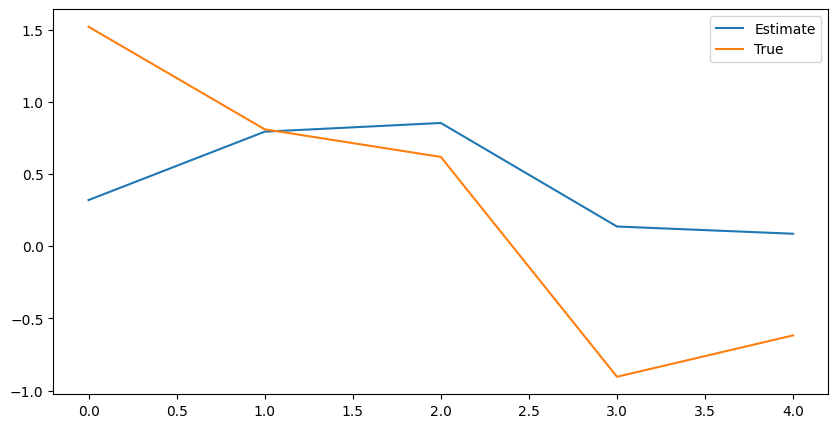

In [71]:
K_inv = np.linalg.inv(K)

d = y.shape[1]
n = X.shape[0]
Y_tilde = np.vstack((y, np.zeros((n,d))))

r = H.shape[1]
iteration = 0
v = np.ones(n)
m = np.ones(n)

for i in range(n):
    v[i] = (1+np.dot(F[i].T, B_true.T).dot(psi_inv).dot(B_true).dot(F[i])) ** (-1)
    m[i] = v[i]*np.dot((y[i]-0).T,psi_inv).dot(B_true).dot(F[i])


#F_est = F_via_woodbury(n,r,B_true, m,v,psi, K_inv, H, omega, n1 = 3, n2=8, smooth = False)
F_est, MS, B_quad = F_direct(n,r,B_true, m,v,psi, K_inv, H, 300, omega, smooth = False)
#F_est = F_via_woodbury2(n,r,B_true, m,v,psi, K, H, omega, n1 = 0, n2=0, smooth = False)
#F_est = F_via_direct_smart(n,r,B_true, m,v,psi, K, H, omega, smooth = False)
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(F_est[:,0], label = 'Estimate')
ax.plot(F[:,0], label = 'True')
ax.legend()
#ax.set_ylim((-5,5))





<AxesSubplot: >

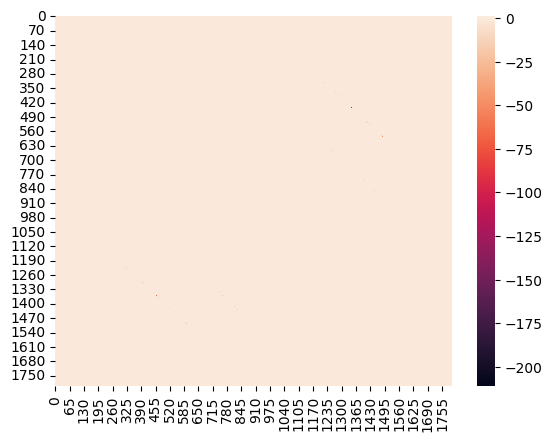

In [56]:
import seaborn as sns
sns.heatmap(np.kron(B_quad, MS))

In [57]:
np.trace(np.kron(B_quad, MS))

216277.6744764099

In [5]:
from scipy.signal import savgol_filter
from scipy.optimize import least_squares
from scipy import ndimage
result = savgol_filter(F_est[:,0], 13, 2)
result_median = ndimage.median_filter(F_est[:,0], size=13)
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(F_est[:,0], label = 'Estimate')
ax.plot(F[:,0], label = 'True')
ax.plot(result, label = 'Smoothed')
ax.plot(result_median, label = 'Smoothed median')
ax.legend()
ax.set_ylim((-5,5))

NameError: name 'F_est' is not defined

In [331]:
def em_F_all_known(K, y, H, B_true,psi_inv, omega, F_start, max_itr = 1, n1 = 2, n2=8, smooth = True, reg = 1000):

    K_inv = np.linalg.inv(K)

    d = y.shape[1]
    n = y.shape[0]
    Y_tilde = np.vstack((y, np.zeros((n,d))))

    r = H.shape[1]
    v = np.ones(n)
    m = np.ones(n)

    F_est = F_start

    for iteration in range(max_itr):

        for i in range(n):
            v[i] = (1+np.dot(F_est[i].T, B_true.T).dot(psi_inv).dot(B_true).dot(F_est[i])) ** (-1)
            m[i] = v[i]*np.dot((y[i]-0).T,psi_inv).dot(B_true).dot(F_est[i])



        F_est = F_via_woodbury(n,r,B_true, m,v,psi, K_inv, H, omega, n1 = n1, n2=n2, smooth = smooth)
        #F_est = F_direct(n,r,B_true, m,v,psi, K_inv, H, reg, omega, smooth = smooth)

    return F_est

In [335]:
F_est = em_F_all_known(K, y, H, B_true, psi_inv, omega, F_start = F, max_itr =10, n1 = 2, n2=8, smooth = False, reg = 500)

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(F_est[:,0], label = 'Estimate')
ax.plot(F[:,0], label = 'True')
ax.legend()
ax.set_ylim((-5,5))

c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\sklearn\utils\extmath.py:370: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


2.1013511325806173
2.2297938552289165
2.2303622312426965
2.230375501375013
2.182768852837626
239677.8645728836


C:\Users\User\AppData\Local\Temp\ipykernel_11912\1800418675.py:12: RuntimeWarning: divide by zero encountered in divide
  M_inv = np.diag(1/m)
C:\Users\User\AppData\Local\Temp\ipykernel_11912\1800418675.py:14: RuntimeWarning: divide by zero encountered in divide
  S_inv = np.diag(1/v)
C:\Users\User\AppData\Local\Temp\ipykernel_11912\1800418675.py:15: RuntimeWarning: divide by zero encountered in divide
  MS_inv = np.diag(1/(m**2+v**2))


ValueError: array must not contain infs or NaNs

In [80]:

def F_via_woodbury(n,r,B_true, m,v,psi, K_inv, n1 = 2, n2=5):
    
    I_n = np.identity(n)
    I_r = np.identity(r)
    psi_inv = np.linalg.inv(psi)
    B_quad = np.dot(B_true.T, psi_inv).dot(B_true)
    B_quad_pinv = np.linalg.pinv(B_quad)
    #l_b, u_b = eigsh(B_quad,6)
    #B_quad_pinv = np.dot(u_b, np.diag(l_b)).dot(u_b.T)

    M = np.diag(m)
    M_inv = np.diag(1/m)
    S = np.diag(v)
    S_inv = np.diag(1/v)
    MS_inv = np.diag(1/(m**2+v**2))


    H_sq = np.dot(H,H)
    H_sq_inv = np.linalg.inv(H_sq)

    D = np.dot(M,y).dot(psi_inv).dot(B_true).flatten()
    A1 = np.dot(B_quad, H_sq_inv*omega)
    u1, l1, v1t = randomized_svd(A1, n_components =n1)

    A2 = np.dot(K_inv, MS_inv)
    u2, l2, v2t = randomized_svd(A2, n_components =n2)


    im1 = np.kron(np.diag(np.reciprocal(l1)), np.diag(np.reciprocal(l2)))
    im2 = np.linalg.inv(im1 + np.matmul(np.kron(v1t, v2t),np.kron(u1, u2))) 
    left = np.kron(MS_inv, B_quad_pinv)
    right = np.dot(np.kron(u1,u2), im2).dot(np.kron(v1t,v2t))
    inv_mat = left + np.dot(np.kron(MS_inv,I_r), right).dot(np.kron(I_n,B_quad_pinv))



    F_vec = np.dot(inv_mat, D)
    F_est = np.array(np.reshape(F_vec, (n, r)))

    return F_est


def cov_regression_ggp(K, Y, H, B_pre, alpha, Psi, F, omega, max_itr = 100, tol = 1e-5, reg = 10):
    H_sq_inv = np.linalg.inv(np.dot(H,H))
    K_inv = np.linalg.inv(K)
    
    d = Y.shape[1]
    n = X.shape[0]
    Y_tilde = np.vstack((Y, np.zeros((n,d))))

    r = X.shape[1]
    alpha = n*alpha
    iteration = 0
    Psi_pre = Psi#np.identity(d)
    v = np.ones(n)
    m = np.ones(n)
    # The solution is evry sensitive to the inital matrix, the l2 regularization for B_pre effects alpha
    #B_pre = np.ones((d,r))#np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T, X_tilde) + alpha*np.identity(r)))
    F_pre = F# np.zeros((n,r))# matrix_normal.rvs(np.zeros((n,r)), rowcov = K, colcov = np.dot(H,H)*(1/omega))




    def fun(param, X, Y,Psi_inv, d,r, alpha):
        
        B = np.reshape(param[:r*d]-param[r*d:],(d,r))
        obj =  np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T)))) + alpha*param.sum() #np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T))).dot(Psi_inv)) + alpha*param.sum()
        t_0 = Y.T-np.dot(B,X.T)
        grad = (-0.5*np.dot(t_0,X)).flatten()# (-0.5*np.dot(Psi_inv,t_0).dot(X) ).flatten() #  0.5*alpha*param[:r*d] 
        return obj, np.concatenate((grad + alpha , - grad + alpha ), axis=None) # np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T))).dot(Psi_inv)) + alpha*np.sum(np.abs(B))

    #B_tmp = B_pre.flatten()
    #B_vec = np.zeros(2*r*d)
    #B_vec[:r*d] = np.abs(B_tmp) * (B_tmp>0)
    #B_vec[r*d:] = np.abs(B_tmp) * (B_tmp<0)
    # B_pre = np.zeros((r,d))
    while iteration <max_itr:
        #print(max_itr)
        print(iteration)
        # print(F_pre.shape)
        Psi_pre_inv = np.linalg.inv(Psi_pre)
        # print(np.linalg.cond(Psi_pre_inv))
        # E-step
        for i in range(n):
            v[i] = (1+np.dot(F_pre[i].T, B_pre.T).dot(Psi_pre_inv).dot(B_pre).dot(F_pre[i])) ** (-1)
            m[i] = v[i]*np.dot((Y[i]-0).T,Psi_pre_inv).dot(B_pre).dot(F_pre[i])

        if np.all(m<= 0):
            m = np.ones(n)


        # M = np.diag(m)
        # M_inv = np.diag(1/m)
        # S = np.diag(v)
        # S_inv = np.diag(1/v)

        # MS_inv = np.diag(1/(m**2+v**2))


        # I_n = np.identity(n)
        # I_r = np.identity(r)

        # print("cond MS_inv")
        # print(np.linalg.cond(MS_inv+10*I_n))


        #X_tilde =  np.vstack((m[:,np.newaxis]*F_pre,v[:,np.newaxis]*F_pre))
        # M-step
        # Estiamte B
        #out = minimize(fun, B_vec, args = (X_tilde, Y_tilde, Psi_pre_inv,d,r, alpha), method='L-BFGS-B', jac=True, bounds = [(0.0,None)]*(2*r*d))
        #B_vec = out.x
        #B = np.reshape(out.x[:r*d] - out.x[r*d:], (d,r))
        #inv_m = np.linalg.inv(np.dot(X_tilde.T, X_tilde))
        #B = np.dot(Y_tilde.T,X_tilde).dot(inv_m)

        # Estimate F
        # A = np.dot(MS_inv, K_inv)

        # H_sq = np.dot(H,H)
        # B_quad = np.dot(B_true.T, Psi_pre_inv).dot(B_true)

        # C = np.dot(B_quad, H_sq)/omega

        # D = np.dot(MS_inv,M).dot(y).dot(psi_inv).dot(B_true).dot(H_sq).flatten()/omega

        
        
        # inv_mat = np.linalg.inv(np.kron(I_r, A)+ np.kron(C.T, I_n) + reg*np.identity(n*r))
        # c_number = np.linalg.cond(inv_mat)
        # print(c_number)
        # if c_number>500:
        #     reg *=1.5
    
        # F_vec = np.dot(inv_mat, D)
        #F = np.array(np.reshape(F_vec, (n, r)))
        F = F_via_woodbury(n,r,B_true, m,v,psi, K_inv, n1 = 1, n2=1)

        # Psi = np.cov((Y-np.dot(X,B.T)).T)*(n-1)/n
        
        print(np.linalg.norm(F-F_pre))
        if np.linalg.norm(F-F_pre)<tol:
            break

        F_pre = F.copy()
        #print(F_pre[0].shape)

        # Psi_pre = Psi.copy()
        #B_pre = B.copy()
        
        #print(scipy.linalg.norm(B_pre-B_true))
        iteration+=1

    return F

In [78]:
F_est = cov_regression_ggp(K, y, H, B_true, 0.1, psi, F, max_itr = 1, tol = 1e-5, reg = 50)

0
857.0629587448601


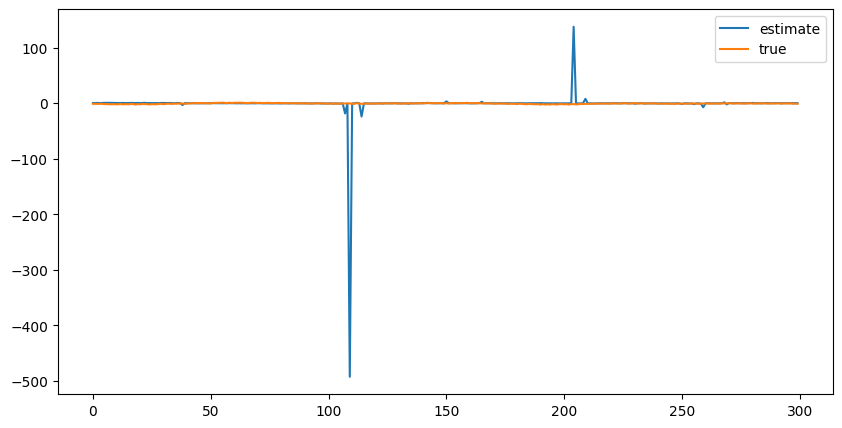

In [81]:
fig, ax = plt.subplots(1,1,figsize = (10, 5))
ax.plot(F_est[:,0], label = 'estimate')
ax.plot(F[:,1], label = 'true')
ax.legend()

In [ ]:
# Estimate, Assume everything except F known

def cov_regression(X, Y, alpha, max_itr = 100, tol = 1e-5):
    
    d = Y.shape[1]
    n = X.shape[0]
    Y_tilde = np.vstack((Y, np.zeros((n,d))))

    r = X.shape[1]
    alpha = n*alpha
    iteration = 0
    max_itr = 100

    Psi_pre = np.identity(d)
    v = np.ones(n)
    m = np.ones(n)
    X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
    # The solution is evry sensitive to the inital matrix, the l2 regularization for B_pre effects alpha
    B_pre = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T, X_tilde) + alpha*np.identity(r)))




    def fun(param, X, Y,Psi_inv, d,r, alpha):
        
        B = np.reshape(param[:r*d]-param[r*d:],(d,r))
        obj =  np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T)))) + alpha*param.sum() #np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T))).dot(Psi_inv)) + alpha*param.sum()
        t_0 = Y.T-np.dot(B,X.T)
        grad = (-0.5*np.dot(t_0,X)).flatten()# (-0.5*np.dot(Psi_inv,t_0).dot(X) ).flatten() #  0.5*alpha*param[:r*d] 
        return obj, np.concatenate((grad + alpha , - grad + alpha ), axis=None) # np.trace(np.dot((Y- np.dot(X,B.T)).T,(Y- np.dot(X,B.T))).dot(Psi_inv)) + alpha*np.sum(np.abs(B))

    B_tmp = B_pre.flatten()
    B_vec = np.zeros(2*r*d)
    B_vec[:r*d] = np.abs(B_tmp) * (B_tmp>0)
    B_vec[r*d:] = np.abs(B_tmp) * (B_tmp<0)
    # B_pre = np.zeros((r,d))
    while iteration <max_itr:
        Psi_pre_inv = np.linalg.inv(Psi_pre)
        # print(np.linalg.cond(Psi_pre_inv))
        # E-step
        for i in range(n):
            v[i] = (1+np.dot(X[i].T, B_pre.T).dot(Psi_pre_inv).dot(B_pre).dot(X[i])) ** (-1)
            m[i] = v[i]*np.dot((Y[i]-0).T,Psi_pre_inv).dot(B_pre).dot(X[i])

        X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
        # M-step
        out = minimize(fun, B_vec, args = (X_tilde, Y_tilde, Psi_pre_inv,d,r, alpha), method='L-BFGS-B', jac=True, bounds = [(0.0,None)]*(2*r*d))
        B_vec = out.x
        B = np.reshape(out.x[:r*d] - out.x[r*d:], (d,r))
        #inv_m = np.linalg.inv(np.dot(X_tilde.T, X_tilde))
        #B = np.dot(Y_tilde.T,X_tilde).dot(inv_m)


        Psi = np.cov((Y-np.dot(X,B.T)).T)*(n-1)/n
        

        if np.linalg.norm(B-B_pre)<tol:
            break

        Psi_pre = Psi.copy()
        B_pre = B.copy()
        
        #print(scipy.linalg.norm(B_pre-B_true))
        iteration+=1

    return B, Psi





A = 2*np.dot(y, B_true).dot()


# Test Code

In [309]:
n = 500
d = 5
r = 6
X = np.random.normal(loc = 0, scale = 1, size = (n,r))
gamma = np.random.normal(loc = 0, scale = 1, size = (n))
epsilon=np.random.normal(loc = 0, scale = 0.1, size = (n,d))
B_true = np.random.normal(loc = 0, scale = 1, size = (d,r))
B_true = B_true*(np.random.uniform(size = (d,r) ) <0.3)

y = gamma[:, np.newaxis]*np.dot(X, B_true.T) + epsilon

Y_tilde = np.vstack((y, np.zeros((n,d))))
print(Y_tilde.shape)


(1000, 5)


In [62]:
B_true = np.random.normal(loc = 0, scale = 1, size = (d,r))
B_true

array([[-0.91260296, -0.2341362 ,  0.01393238,  0.16368234,  0.16604981,
        -0.58403101],
       [-0.89004669,  0.45387865,  0.37950731, -0.26523894, -1.0563074 ,
         0.32144051],
       [-0.1018554 ,  1.41178661,  0.72326929,  1.00050162, -0.02256872,
         0.18033654],
       [ 1.92205876, -1.13933992,  0.92415547, -0.38521209,  1.29238209,
        -1.26638042],
       [ 0.55760962, -0.20928178,  0.69793466,  0.53200213,  0.17176122,
         0.28610141]])

In [63]:
B_true*(np.random.uniform(size = (d,r) ) <0.3)

array([[-0.91260296, -0.        ,  0.        ,  0.        ,  0.        ,
        -0.        ],
       [-0.        ,  0.45387865,  0.        , -0.        , -1.0563074 ,
         0.32144051],
       [-0.1018554 ,  0.        ,  0.72326929,  0.        , -0.        ,
         0.18033654],
       [ 0.        , -0.        ,  0.92415547, -0.38521209,  0.        ,
        -0.        ],
       [ 0.55760962, -0.        ,  0.        ,  0.        ,  0.17176122,
         0.        ]])

In [39]:
np.exp(-np.linspace(7,2,30))

array([0.00091188, 0.00108347, 0.00128735, 0.00152959, 0.00181741,
       0.00215939, 0.00256572, 0.00304851, 0.00362214, 0.00430372,
       0.00511355, 0.00607576, 0.00721903, 0.00857743, 0.01019144,
       0.01210916, 0.01438773, 0.01709506, 0.02031183, 0.0241339 ,
       0.02867516, 0.03407094, 0.04048205, 0.04809954, 0.0571504 ,
       0.06790435, 0.08068187, 0.09586373, 0.11390235, 0.13533528])

In [6]:
# Generate data
n = 1000
d = 50
r = 50
X = np.random.normal(loc = 0, scale = 1, size = (n,r))
gamma = np.random.normal(loc = 0, scale = 1, size = (n))
epsilon = np.random.normal(loc = 0, scale = 1, size = (n,d))
B_true = np.random.normal(loc = 0, scale = 1, size = (d,r))
B_true =B_true*(np.random.uniform(size = (d,r) ) <0.3)


Y = gamma[:, np.newaxis]*np.dot(X, B_true.T) + epsilon


Y_tilde = np.vstack((Y, np.zeros((n,d))))
print(np.round(B_true,2))

[[ 0.   -0.    0.   ... -0.   -2.23  0.  ]
 [ 0.    0.84  0.   ... -0.   -1.1  -0.  ]
 [ 0.   -1.48  0.   ...  1.54 -0.    0.  ]
 ...
 [-0.    0.    0.   ... -0.   -0.48  1.12]
 [-0.   -0.   -0.   ...  0.05 -0.    0.  ]
 [-0.    0.   -0.   ... -0.75 -0.    1.49]]


In [14]:
B, Psi = cov_regression(X,Y, 0.001,10)
print(np.round(B,2))

[[ 0.02 -0.01  0.01 ...  0.    0.   -0.  ]
 [ 0.02 -0.16  0.   ... -0.02  0.   -0.02]
 [ 0.    0.    0.   ...  0.    0.17  0.18]
 ...
 [-0.01  0.7   0.   ...  0.48  0.   -0.01]
 [ 0.    0.03 -0.04 ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.   -0.01]]


In [7]:
Bs, Psis = dynamic_cov_regression(X,Y,100, 0.01, 0.1,1000, 50 )
print(np.round(Bs[0],2))
print(np.round(Bs[1],2))

ValueError: operands could not be broadcast together with shapes (7,5) (7,7) 

In [39]:
B, Psi = cov_regression(X,Y, 0.001,1)
print(np.round(B,2))


[[ 0.04 -0.92  0.01 ...  0.02  0.02  0.04]
 [ 0.    0.    0.03 ...  0.    0.88 -0.01]
 [-0.02 -1.06 -0.87 ...  0.    0.    0.  ]
 ...
 [-0.01  0.    0.   ... -0.08  0.    0.31]
 [ 0.33  0.18  0.01 ... -0.03  0.   -1.12]
 [ 0.    1.12  0.   ... -0.47  0.    0.03]]


In [22]:
print(np.round(B_true,2))

[[-0.    0.    0.   ...  0.19 -0.78  0.  ]
 [ 0.   -0.   -0.   ...  0.   -0.    1.38]
 [ 0.    0.   -0.   ...  0.    0.    0.  ]
 ...
 [-0.   -0.    0.   ... -0.   -0.    0.  ]
 [-0.    0.09  0.   ...  0.   -0.   -0.  ]
 [-0.    0.85  0.64 ...  0.94 -1.37 -0.  ]]


value function

$ Y = B\Sigma B^T$

$ Y = (-B)\Sigma (-B)^T$

$ Y = (-1)^2B\Sigma B^T$ 

$ Y = B\Sigma B^T$

invariance robustness


$ Sh^{ij} = [B\Sigma B^T]_{ij}$


O(d^2)

In [8]:
# True shapleys
# Generate data
d = 7
r = 5

B_true = np.random.normal(loc = 0, scale = 1, size = (d,r))
B_true = B_true*(np.random.uniform(size = (d,r) ) <0.3)

val_y_true = np.dot(B_true, np.identity(r)).dot(B_true.T)


In [6]:

ns = [50, 100, 500, 1000, 10000]
rs = [5, 10, 15, 30, 50, 100, 200]
ds = [5, 10, 15, 30, 50, 100, 200]
alphas = np.exp(-np.linspace(7,2,80))

B_dict = dict()
B_dict_true = dict()
Psi_dict = dict()
Xs_dict = dict()
val_y_true = dict()
value_function_dict = {str(r) + '_'+str(d): dict() for r in rs for d in ds}
pbar = tqdm.tqdm(total = len(alphas)*len(ns)*len(ds)*len(rs))
for r in rs:
    for d in ds:

            
        B_true = np.random.normal(loc = 0, scale = 1, size = (d,r))
        B_true = B_true*(np.random.uniform(size = (d,r) ) <0.3)
        B_dict_true[str(r) + '_'+str(d)] = B_true
        for i in range(d):
            for j in range(i,d):
                value_function_dict[str(r) + '_'+str(d)][str(i)+','+ str(j)] = np.zeros(shape = (len(ns), len(alphas), r))
        
        Bs = np.zeros(shape = (len(ns), len(alphas), d, r))
        Psis = np.zeros(shape = (len(ns), len(alphas), d, d))

        val_y_true[str(r) + '_'+str(d)] = np.dot(B_true, np.identity(r)).dot(B_true.T)


        for n_cnt, n in enumerate(ns):
            X = np.random.normal(loc = 0, scale = 1, size = (n,r))
            gamma = np.random.normal(loc = 0, scale = 1, size = (n))
            epsilon = np.random.normal(loc = 0, scale = 1, size = (n,d))
            Y = gamma[:, np.newaxis]*np.dot(X, B_true.T) + epsilon
            for alpha_cnt, alpha in enumerate(alphas):
                B, Psi = cov_regression(X,Y, alpha, 100 )
                Bs[n_cnt, alpha_cnt] = B.copy()
                Psis[n_cnt, alpha_cnt] = Psi.copy()
                
                shapleys = calc_shapley_value(B,X)
                for i in range(d):
                    for j in range(i,d):
                        value_function_dict[str(r) + '_'+str(d)][str(i)+','+ str(j)][n_cnt, alpha_cnt] = shapleys[str(i)+','+ str(j)]

                B_dict[str(r) + '_'+str(d)] = Bs
                Psi_dict[str(r) + '_'+str(d)] = Bs
                pbar.update()

        out_dict = {'alphas':alphas, 'ns':ns, 'rs':rs, 'ds':ds, 'value_function_dict':value_function_dict, 'r': r, 'd':d, 
                    'B_true':B_true, 'B_dict':B_dict, 'B_dict_true':B_dict_true, 'Psi_dict':Psi_dict,'val_y_true':val_y_true}
        import pickle
        with open(f'../data/Shapley/shapley2.pkl', 'wb') as handle:
            pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


                
pbar.close()

  1%|▏         | 253/19600 [00:42<3:00:41,  1.78it/s]

In [129]:
# out_dict = {'alphas':alphas, 'ns':ns, 'value_function':value_function, 'r': r, 'd':d, 'B_true':B_true, 'Bs':Bs}
# import pickle
# with open(f'../data/Shapley/shapley.pkl', 'wb') as handle:
#     pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analyze Script Data

In [5]:
import pickle
with open(f'../data/Shapley/shapley7_ones_start.pkl', 'rb') as handle:
    out_dict = pickle.load(handle)

out_dict.keys()

dict_keys(['alphas', 'ns', 'rs', 'ds', 'value_function_dict', 'Xs_dict', 'Ys_dict', 'B_dict', 'B_dict_true', 'Psi_dict', 'val_y_true'])

In [6]:
alphas = out_dict['alphas']
ns = out_dict['ns']
rs = out_dict['rs']
ds = out_dict['ds']
value_function_dict = out_dict['value_function_dict']
B_dict = out_dict['B_dict']
B_dict_true = out_dict['B_dict_true']
B_dict = out_dict['B_dict']
B_dict_true = out_dict['B_dict_true']
val_y_true = out_dict['val_y_true']
Psi_dict = out_dict['Psi_dict']
Xs_dict = out_dict['Xs_dict']
Ys_dict = out_dict['Ys_dict']

colors = ['blue', 'orange', 'red', 'green', 'purple']  # colors for number of observation distiction

In [59]:
B_dict_true.keys()

dict_keys(['5_5', '5_10', '5_50', '10_5', '10_10', '10_50', '50_5', '50_10', '50_50', '100_5', '100_10', '100_50'])

Test cov regression

In [267]:
B, Psi = cov_regression_lasso(Xs_dict['100'][2],Ys_dict['100_100'][2],0.0000005)
np.round(B,2)

c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e+00, tolerance: 2.215e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.780e+00, tolerance: 1.782e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

array([[ -5.84,   9.47,  -4.07, ...,   0.53,   1.27,  -8.75],
       [ -2.5 ,  -0.09,  -4.81, ...,   2.29,  -4.51,  -2.64],
       [ -2.38,   3.66,   0.25, ...,  -1.62,  -1.12,   7.21],
       ...,
       [ -5.47,  -9.56,  -0.21, ...,  -2.86,  -6.3 ,  -0.19],
       [  2.11,   1.73,  -2.12, ...,   0.61,   2.12,   0.92],
       [ 10.1 ,   3.2 , -10.  , ...,   1.01,   0.  ,   2.06]])

In [238]:
B, Psi, it, tol, B_pre, out, grad = cov_regression(Xs_dict['5'][4],Ys_dict['5_5'][4],0.1)
B

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Plot loss

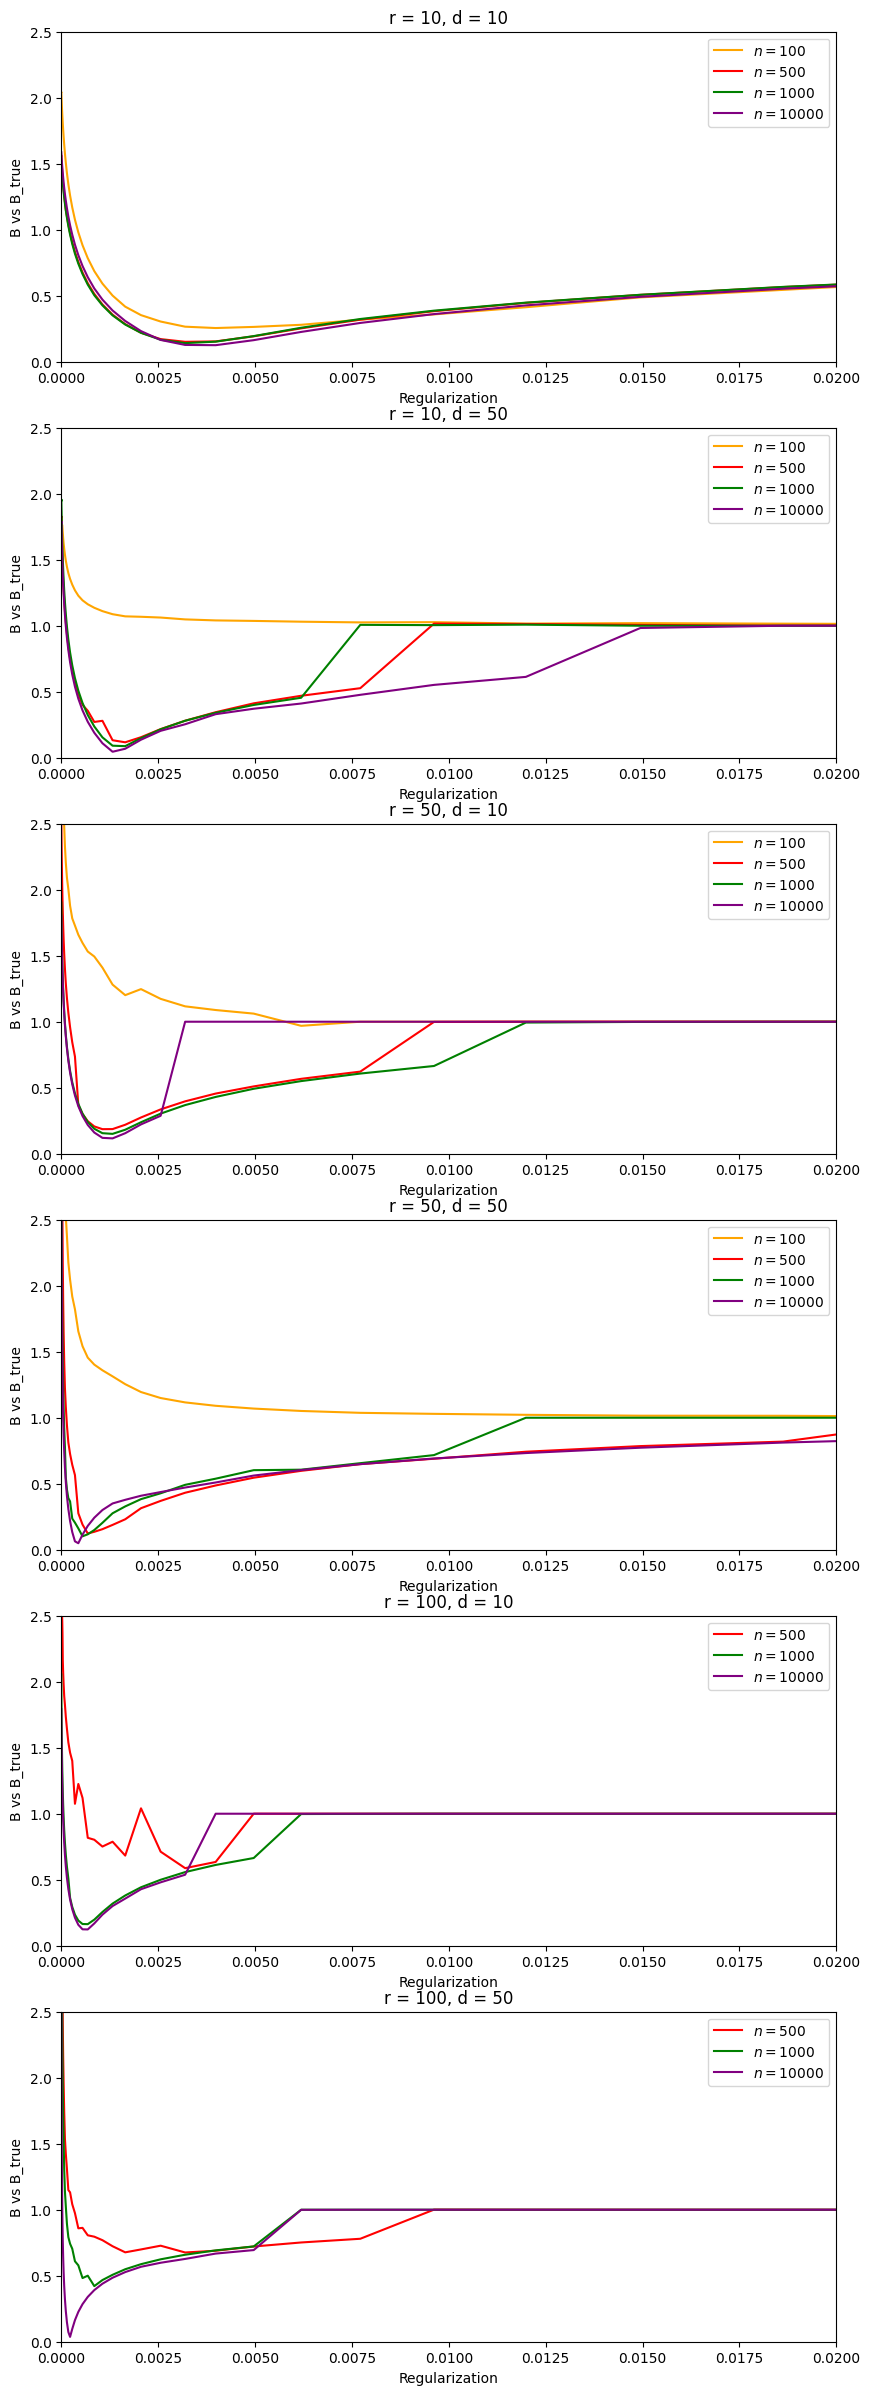

In [7]:
fig, ax = plt.subplots(6,1, figsize = (10,30))

cnt = 0
for r in [10, 50, 100]:
    for d in [10, 50]:
        for k in range(len(ns)):

            if r >5 or d > 5:
                if np.isin(k,[0]):
                    continue
            if r >50 or d > 50:
                if np.isin(k,[0,1]):
                    continue
            if r >100 or d > 100:
                if np.isin(k,[0,1,2]):
                    continue
            ax[cnt].plot(alphas, [np.sum(np.abs(np.abs(B_dict_true[str(r) + '_'+str(d)]) - np.abs(B_dict[str(r) + '_'+str(d)][k,i])))/np.sum(np.abs(B_dict_true[str(r) + '_'+str(d)])) for i in range(B_dict[str(r) + '_'+str(d)].shape[1])], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
        ax[cnt].legend()
        ax[cnt].set_ylabel("B vs B_true")
        ax[cnt].set_xlabel("Regularization")
        ax[cnt].set_title(f'r = {r}, d = {d}')
        ax[cnt].set_ylim((0,2.5))
        ax[cnt].set_xlim((0,0.02))
        cnt+=1

Plot value function

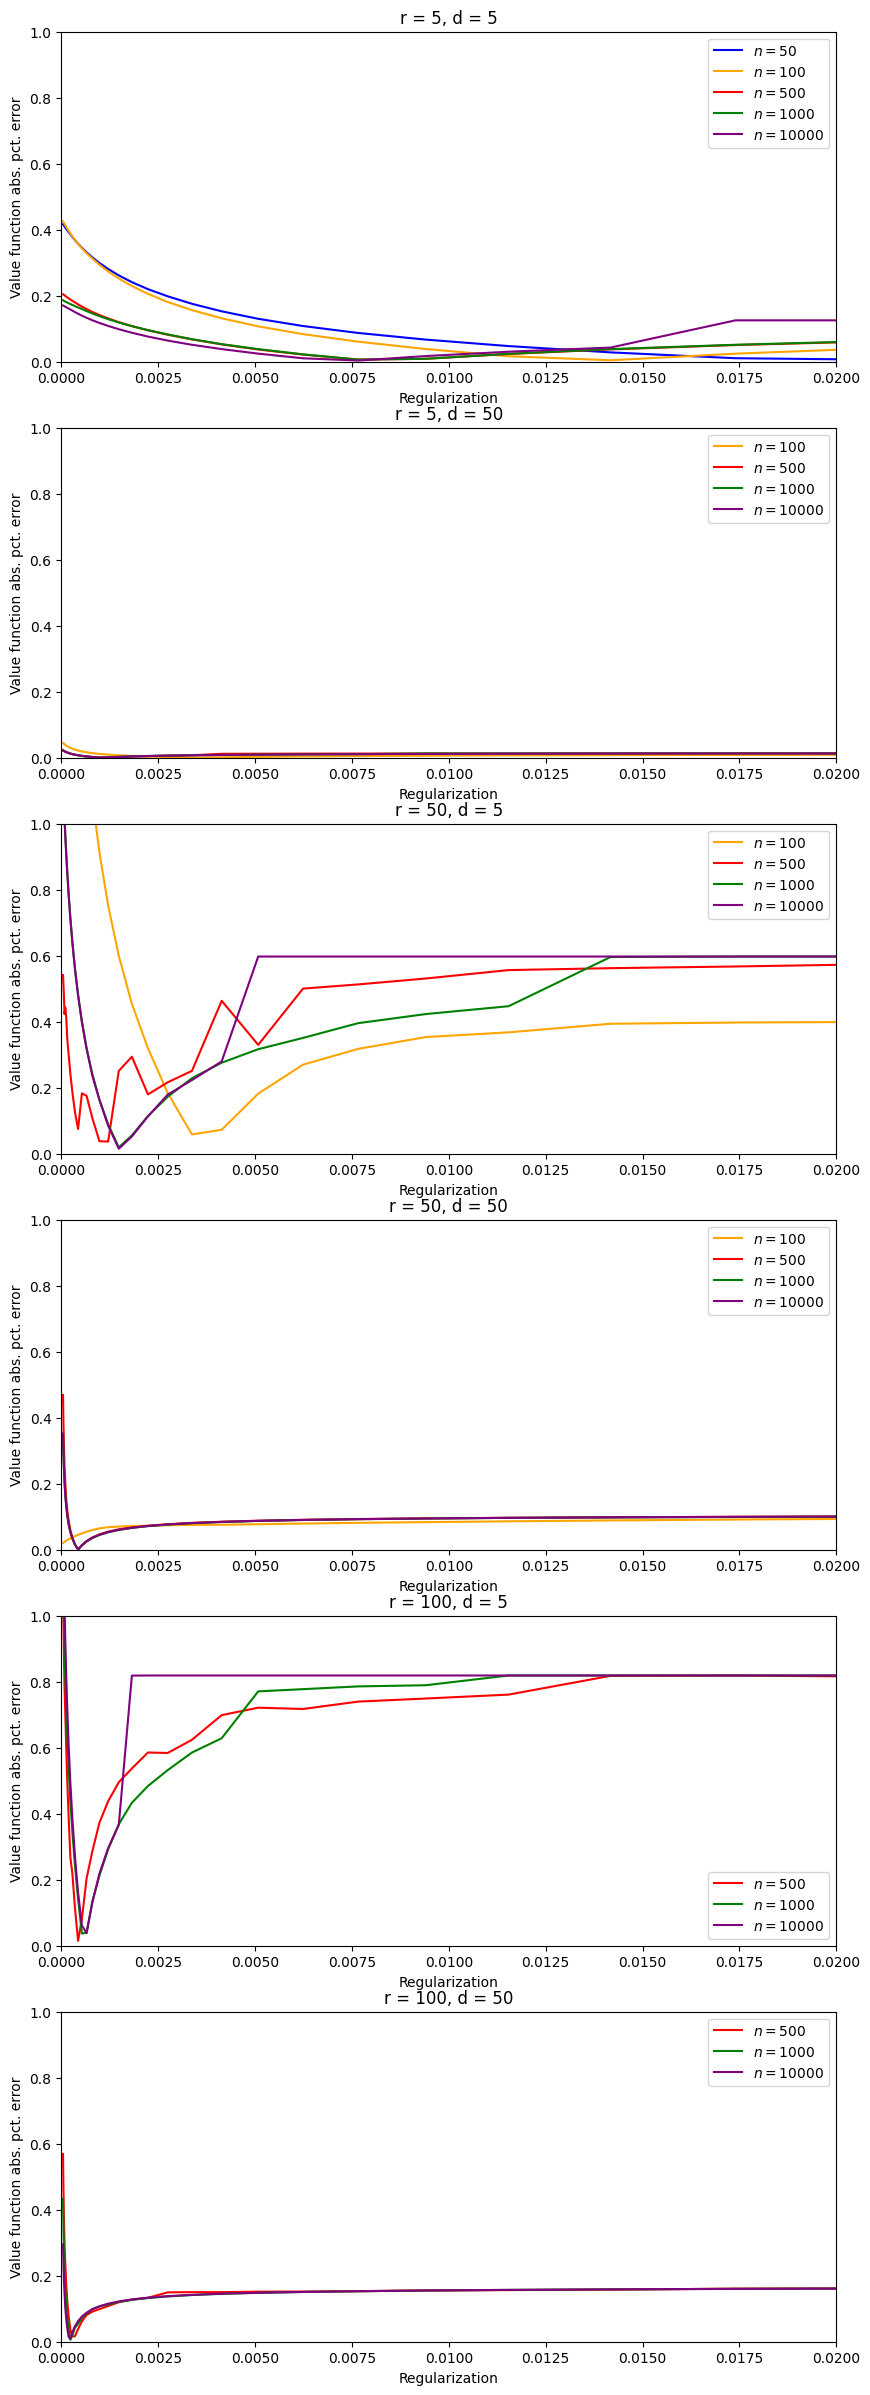

In [51]:
fig, ax = plt.subplots(6,1, figsize = (10,30))

cnt = 0
for r in [5, 50, 100]:
    for d in [5, 50]:
        for k in range(len(ns)):

            if r >5 or d > 5:
                if np.isin(k,[0]):
                    continue
            if r >50 or d > 50:
                if np.isin(k,[0,1]):
                    continue
            if r >100 or d > 100:
                if np.isin(k,[0,1,2]):
                    continue
            ax[cnt].plot(alphas, [np.sum(np.abs(np.sum(val_y_true[str(r) + '_'+str(d)]) - np.sum(value_function_dict[str(r) + '_'+str(d)][:,:,k,i])))/np.sum(np.abs(val_y_true[str(r) + '_'+str(d)])) for i in range(B_dict[str(r) + '_'+str(d)].shape[1])], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
        ax[cnt].legend()
        ax[cnt].set_ylabel("Value function abs. pct. error")
        ax[cnt].set_xlabel("Regularization")
        ax[cnt].set_title(f'r = {r}, d = {d}')
        ax[cnt].set_ylim((0,1))
        ax[cnt].set_xlim((0,0.02))
        cnt+=1

Plot shapley value of some edges

In [61]:
True_shap_dict = dict()
True_shap_dict = {str(r)+'_'+ str(d): np.zeros(shape = (d,d,len(ns), r)) for r in rs for d in ds}
for r in [5, 50, 100]:
    for d in [5, 50]:
        for k in range(len(ns)):
            B = B_dict_true[str(r)+'_'+ str(d)]
            X = Xs_dict[str(r)][k].copy()
            shapleys = calc_shapley_value(B,X)
            for i in range(d):
                for j in range(i,d):
                    True_shap_dict[str(r) + '_'+str(d)][i,j,k] = shapleys[str(i)+','+ str(j)]

NameError: name 'calc_shapley_value' is not defined

In [68]:
True_shap_dict[str(r)+'_'+ str(d)][i,j,0]/val_y_true[str(r)+'_'+ str(d)][i,j]

array([ 1.12444859,  0.03556521, -0.12178354, -0.13395331,  0.04220171])

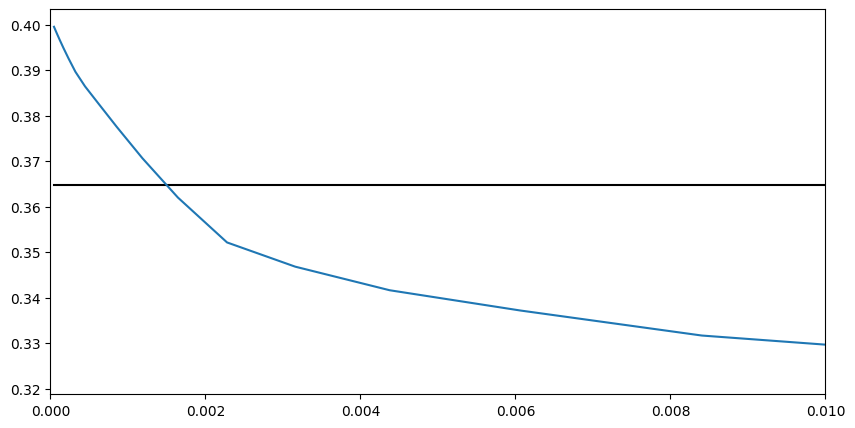

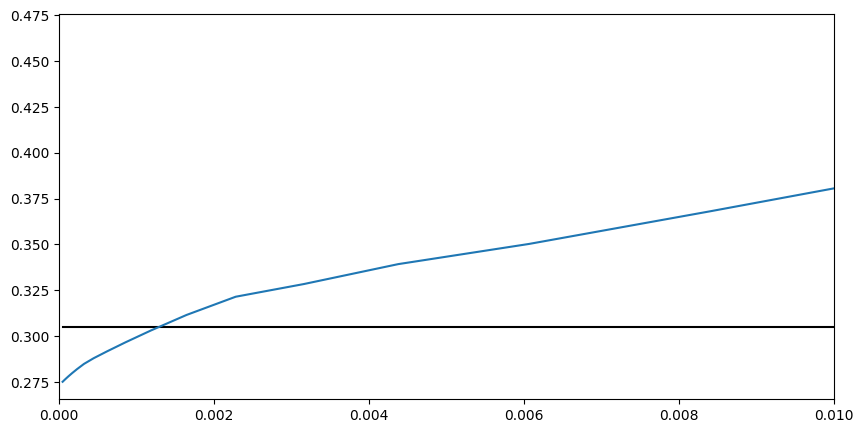

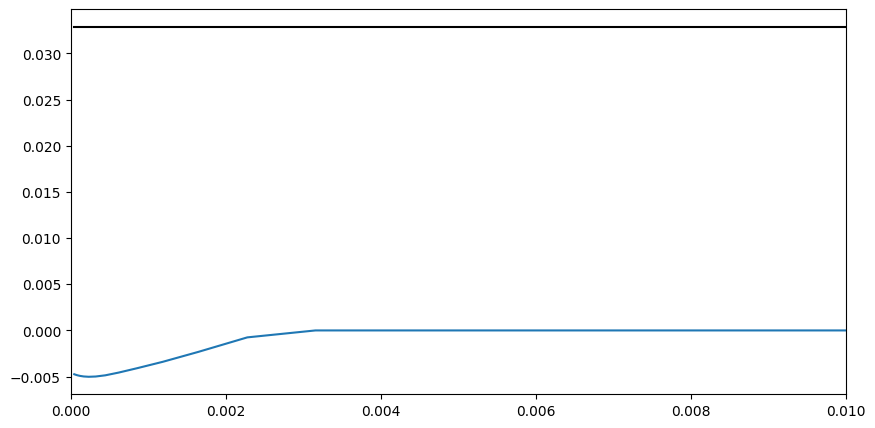

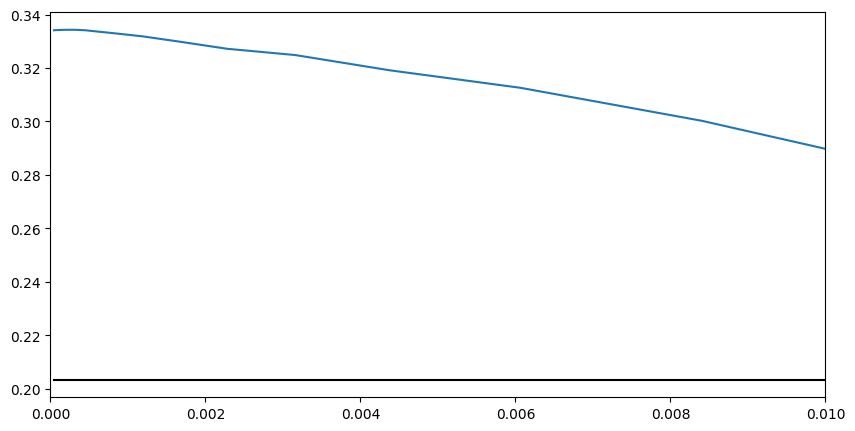

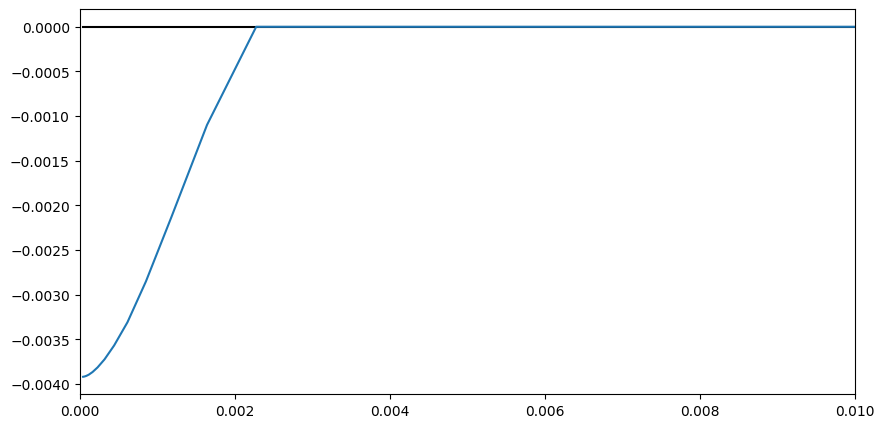

In [10]:
r = 5
d = 5

i = 0
j = 0
for s in range(r):
    fig, ax = plt.subplots(1,1, figsize = (10,5))
    ax.plot(alphas, [True_shap_dict[str(r)+'_'+ str(d)][i,j,0,s]/val_y_true[str(r)+'_'+ str(d)][i,j]]*len(alphas), label = 'True', color = 'black')
    ax.plot(alphas, value_function_dict[str(r)+'_'+ str(d)][i,j,0,:,s]/np.sum(value_function_dict[str(r)+'_'+ str(d)][i,j,0,:], axis=1), label = f'Estimated {s}')
    ax.set_xlim((0,0.01))
    #ax.set_ylim((-3,3))


In [66]:
val_y_true[str(r)+'_'+ str(d)][i,j]

-0.7785330797381689

In [76]:
value_function_dict[str(r)+'_'+ str(d)][i,j][k,:].shape

(60, 5)

In [78]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
for r in [5, 50, 100]:
    for d in [5, 50]:
        value_function_dict
        

        for i in range(d):
            for j in range(i,d):
                fig, ax = plt.subplots(1,1, figsize = (10,5))
                for k in range(len(ns)):
                    if k == 0:
                        continue
                    ax.plot(alphas, np.sum(value_function_dict[str(r)+'_'+ str(d)][i,j][k,:],axis = 1), label = f'{r"$n = $"}{ns[k]}')
                ax.plot(alphas, [val_y_true[str(r)+'_'+ str(d)][i,j]]*len(alphas), color = 'black', label = 'True Shapley')
                ax.set_title(str(i)+','+ str(j))
                ax.legend()
                ax.set_xlabel('Regularization')

C:\Users\User\AppData\Local\Temp\ipykernel_23212\992529805.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1, figsize = (10,5))


KeyboardInterrupt: 

Plot AIC, BIC, EBIC

In [62]:

cnt = 0
pbar = tqdm.tqdm(total = len(rs)*len(ds)*len(ns) )
AIC = {str(r) + '_'+str(d):np.zeros((len(ns), len(alphas))) for r in rs for d in ds}
BIC = {str(r) + '_'+str(d):np.zeros((len(ns), len(alphas))) for r in rs for d in ds}
EBIC = {str(r) + '_'+str(d):np.zeros((len(ns), len(alphas))) for r in rs for d in ds}
LIK = {str(r) + '_'+str(d):np.zeros((len(ns), len(alphas))) for r in rs for d in ds}
NRPARAM = {str(r) + '_'+str(d):np.zeros((len(ns), len(alphas))) for r in rs for d in ds}
for r in [5, 50, 100]:
    for d in [5, 50]:
        for k in range(len(ns)):
            pbar.update()

            if r >5 or d > 5:
                if np.isin(k,[0]):
                    continue
            if r >50 or d > 50:
                if np.isin(k,[0,1]):
                    continue
            if r >100 or d > 100:
                if np.isin(k,[0,1,2]):
                    continue

            X = Xs_dict[str(r)][k]
            n = X.shape[0]
            v = np.ones(n)
            m = np.ones(n)
            for i in range(B_dict[str(r) + '_'+str(d)].shape[1]):
                B_est = B_dict[str(r) + '_'+str(d)][k,i]
                Psi_est = Psi_dict[str(r) + '_'+str(d)][k,i]
                Y = Ys_dict[str(r) + '_'+str(d)][k]

                # E-step
                for j in range(n):
                    v[j] = (1+np.dot(X[j].T, B_est.T).dot(Psi_est).dot(B_est).dot(X[j])) ** (-1)
                    m[j] = v[j]*np.dot((Y[j]-0).T,Psi_est).dot(B_est).dot(X[j])

                X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
                Y_tilde = np.vstack((Y, np.zeros((n,d))))
                #L = -0.5*X.shape[0]*np.log(np.linalg.det(Psi_est))-0.5*np.trace(np.dot((Y_tilde- np.dot(X_tilde,B_est.T)).T,(Y_tilde- np.dot(X_tilde,B_est.T))).dot(np.linalg.inv(Psi_est)))
                L = -0.5*np.trace(np.dot((Y_tilde- np.dot(X_tilde,B_est.T)).T,(Y_tilde- np.dot(X_tilde,B_est.T))))
                
                
                # L = 0.0
                # for j in range(n):
                #     tmp = np.dot(B_est, X[j])
                #     cov = Psi_est + np.outer(tmp, tmp)
                #     L += -0.5*np.log(np.linalg.det(cov)) - 0.5*np.trace(np.dot(np.linalg.inv(cov), np.outer(Y[j],Y[j])))

                
                
                B_est_tmp = B_est.copy()
                B_est_tmp[np.abs(B_est_tmp)<1e-5] = 0
                nr_params = np.sum(B_est_tmp != 0)

                AIC[str(r) + '_'+str(d)][k,i] = 2*nr_params - 2*L
                BIC[str(r) + '_'+str(d)][k,i] = 2*nr_params*np.log(n) - 2*L
                EBIC[str(r) + '_'+str(d)][k,i] = 2*nr_params*np.log(n) + 8*0.5*nr_params*np.log(d*r) - 2*L
                LIK[str(r) + '_'+str(d)][k,i] = L
                NRPARAM[str(r) + '_'+str(d)][k,i] = nr_params
pbar.close()


 50%|█████     | 30/60 [00:50<00:50,  1.69s/it]


C:\Users\User\AppData\Local\Temp\ipykernel_23212\396591682.py:16: RuntimeWarning: invalid value encountered in divide
  ax[cnt,0].plot(alphas,(AIC[str(r) + '_'+str(d)]/ np.abs(np.min(AIC[str(r) + '_'+str(d)], axis=1))[:,np.newaxis])[k], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
C:\Users\User\AppData\Local\Temp\ipykernel_23212\396591682.py:17: RuntimeWarning: invalid value encountered in divide
  ax[cnt,1].plot(alphas,(BIC[str(r) + '_'+str(d)]/ np.abs(np.min(BIC[str(r) + '_'+str(d)], axis=1))[:,np.newaxis])[k], label = f'{r"$n = $"}{ns[k]}', color = colors[k]) #(AIC[str(r) + '_'+str(d)]/ np.min(AIC[str(r) + '_'+str(d)], axis=1)[:,np.newaxis])[k]
C:\Users\User\AppData\Local\Temp\ipykernel_23212\396591682.py:18: RuntimeWarning: invalid value encountered in divide
  ax[cnt,2].plot(alphas,(EBIC[str(r) + '_'+str(d)]/ np.abs(np.min(EBIC[str(r) + '_'+str(d)], axis=1))[:,np.newaxis])[k], label = f'{r"$n = $"}{ns[k]}', color = colors[k])


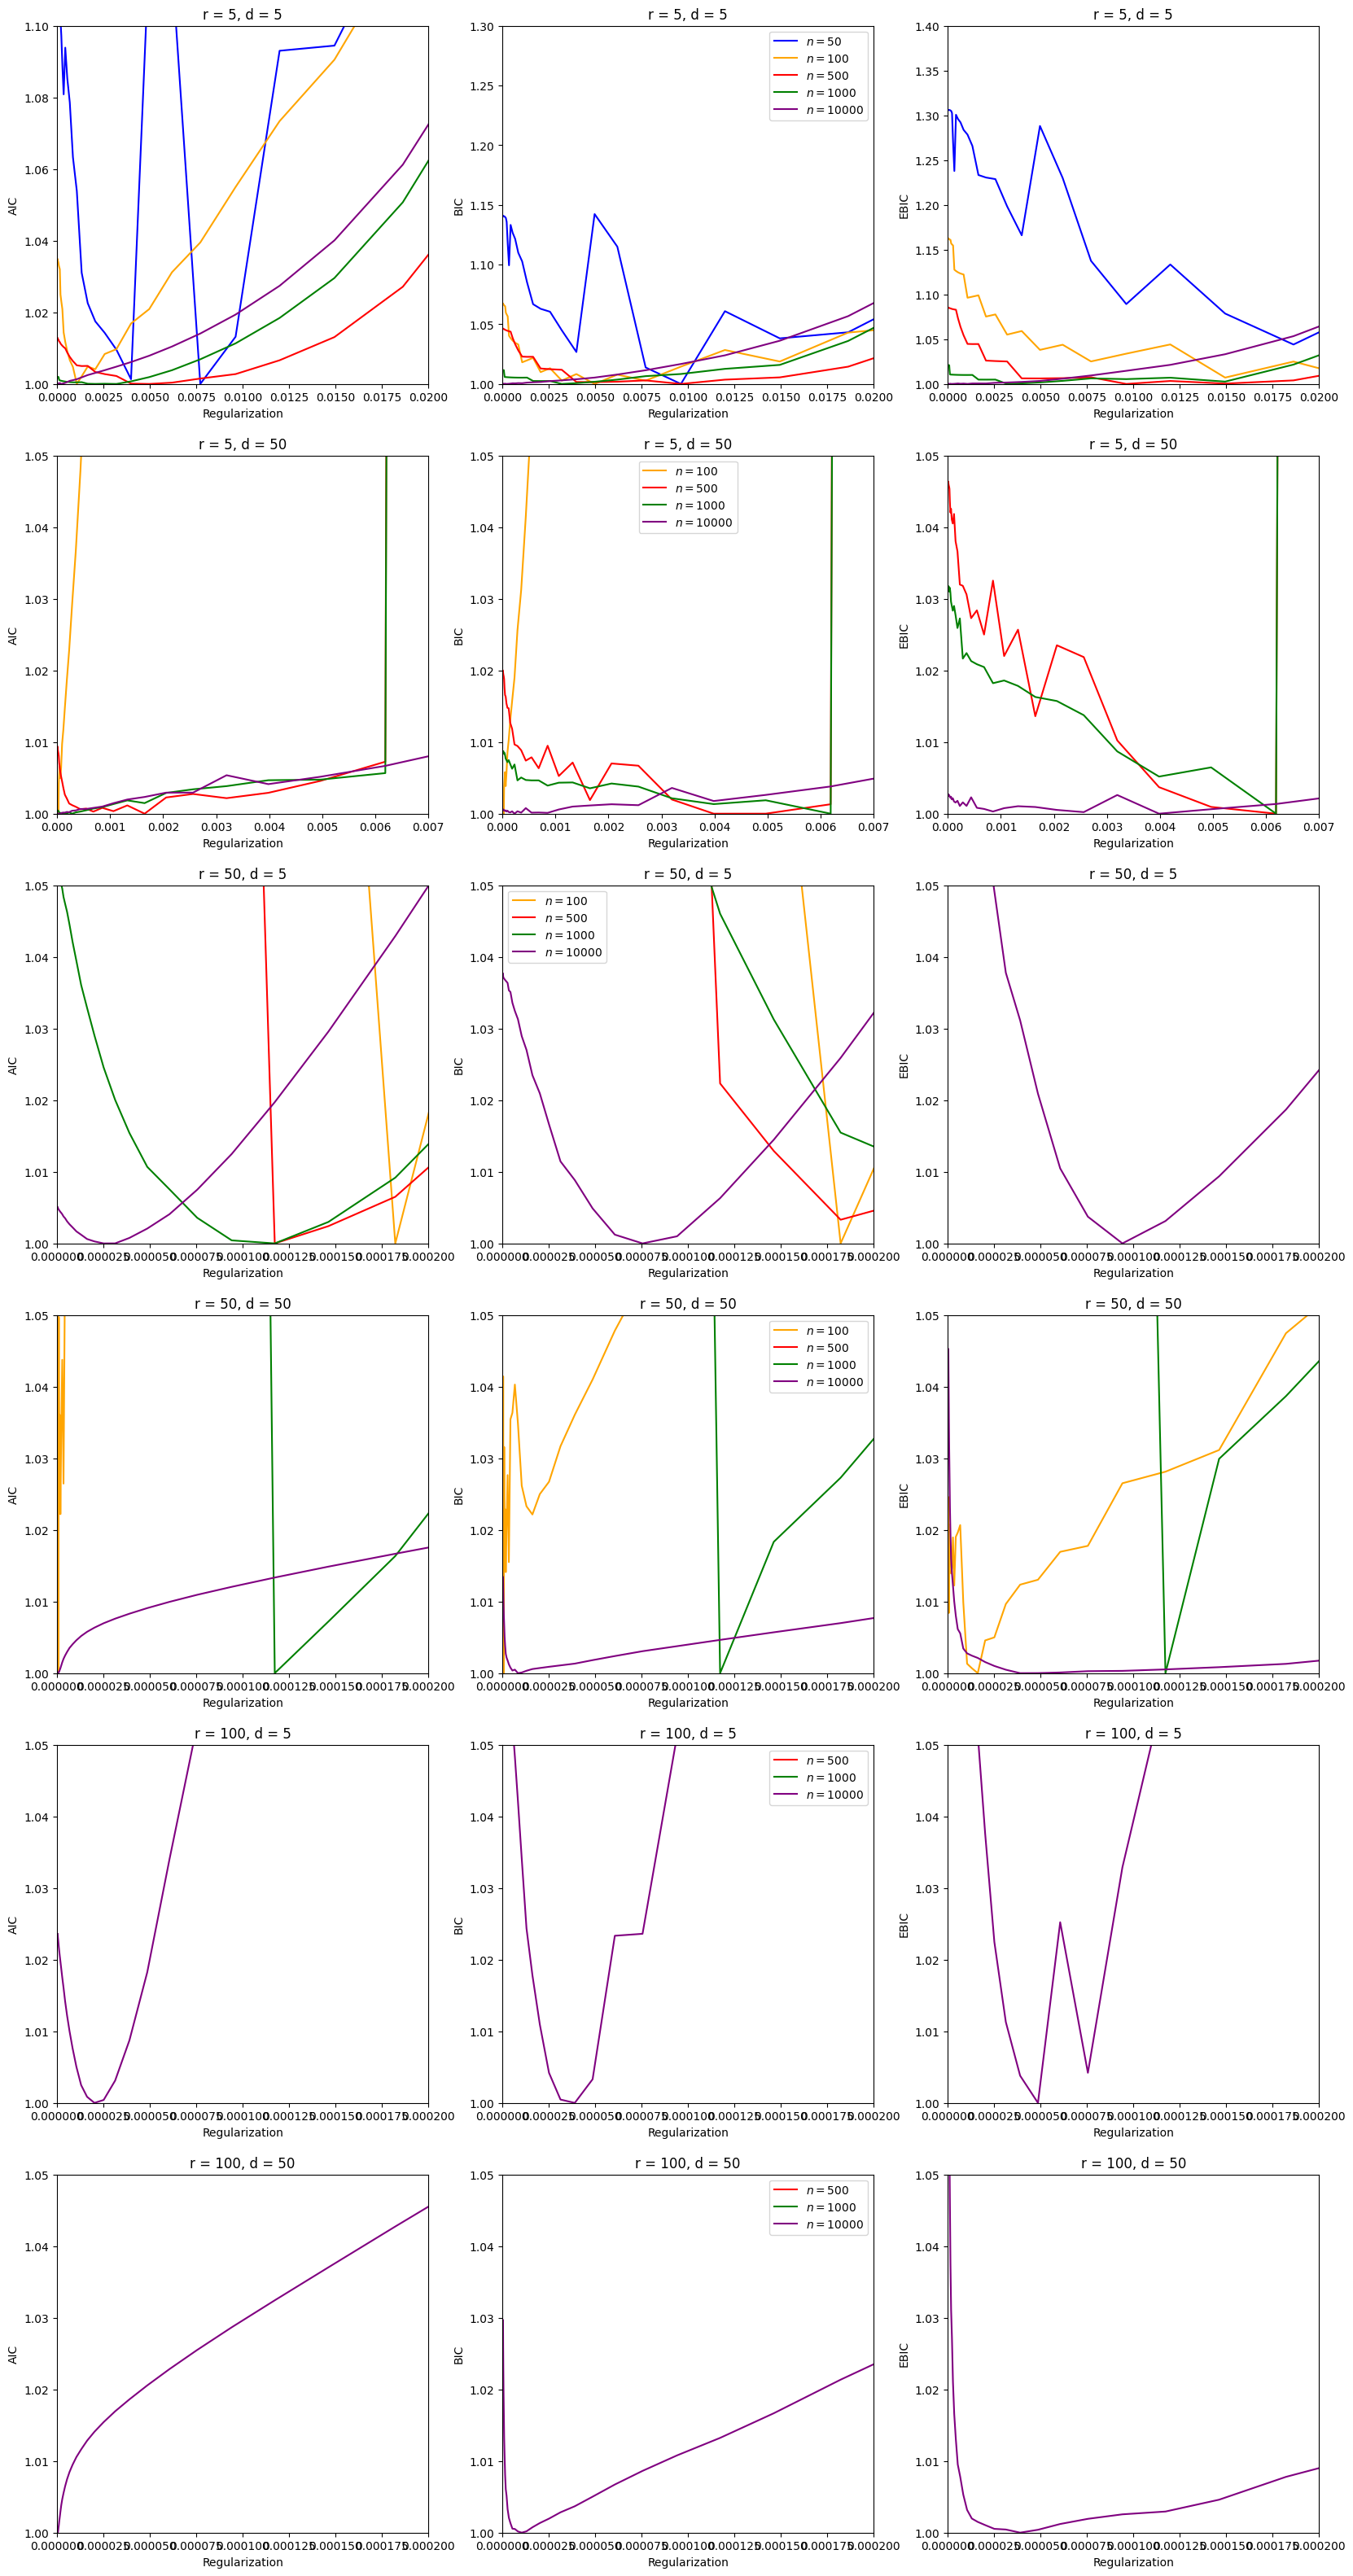

In [63]:
fig, ax = plt.subplots(6,3, figsize = (20,40))

cnt = 0
for r in [5, 50, 100]:
    for d in [5, 50]:
        for k in range(len(ns)):
            if r >5 or d > 5:
                if np.isin(k,[0]):
                    continue
            if r >50 or d > 50:
                if np.isin(k,[0,1]):
                    continue
            if r >100 or d > 100:
                if np.isin(k,[0,1,2]):
                    continue
            ax[cnt,0].plot(alphas,(AIC[str(r) + '_'+str(d)]/ np.abs(np.min(AIC[str(r) + '_'+str(d)], axis=1))[:,np.newaxis])[k], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
            ax[cnt,1].plot(alphas,(BIC[str(r) + '_'+str(d)]/ np.abs(np.min(BIC[str(r) + '_'+str(d)], axis=1))[:,np.newaxis])[k], label = f'{r"$n = $"}{ns[k]}', color = colors[k]) #(AIC[str(r) + '_'+str(d)]/ np.min(AIC[str(r) + '_'+str(d)], axis=1)[:,np.newaxis])[k]
            ax[cnt,2].plot(alphas,(EBIC[str(r) + '_'+str(d)]/ np.abs(np.min(EBIC[str(r) + '_'+str(d)], axis=1))[:,np.newaxis])[k], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
        ax[cnt,1].legend()
        ax[cnt,0].set_ylabel("AIC")
        ax[cnt,1].set_ylabel("BIC")
        ax[cnt,2].set_ylabel("EBIC")
        ax[cnt,0].set_xlabel("Regularization")
        ax[cnt,1].set_xlabel("Regularization")
        ax[cnt,2].set_xlabel("Regularization")
        ax[cnt,0].set_title(f'r = {r}, d = {d}')
        ax[cnt,1].set_title(f'r = {r}, d = {d}')
        ax[cnt,2].set_title(f'r = {r}, d = {d}')
        ax[cnt,0].set_ylim((1,1.1))
        ax[cnt,1].set_ylim((1,1.3))
        ax[cnt,2].set_ylim((1,1.4))
        cnt+=1



        ax[0,0].set_xlim((0,0.02))
        ax[0,1].set_xlim((0,0.02))
        ax[0,2].set_xlim((0,0.02))
        ax[0,0].set_ylim((1,1.1))
        ax[0,1].set_ylim((1,1.3))
        ax[0,2].set_ylim((1,1.4))

        ax[1,0].set_xlim((0,0.007))
        ax[1,1].set_xlim((0,0.007))
        ax[1,2].set_xlim((0,0.007))
        ax[1,0].set_ylim((1,1.05))
        ax[1,1].set_ylim((1,1.05))
        ax[1,2].set_ylim((1,1.05))

        ax[2,0].set_xlim((0,0.0002))
        ax[2,1].set_xlim((0,0.0002))
        ax[2,2].set_xlim((0,0.0002))
        ax[2,0].set_ylim((1,1.05))
        ax[2,1].set_ylim((1,1.05))
        ax[2,2].set_ylim((1,1.05))


        for j in [3,4,5]:
            ax[j,0].set_xlim((0,0.0002))
            ax[j,1].set_xlim((0,0.0002))
            ax[j,2].set_xlim((0,0.0002))
            ax[j,0].set_ylim((1,1.05))
            ax[j,1].set_ylim((1,1.05))
            ax[j,2].set_ylim((1,1.05))



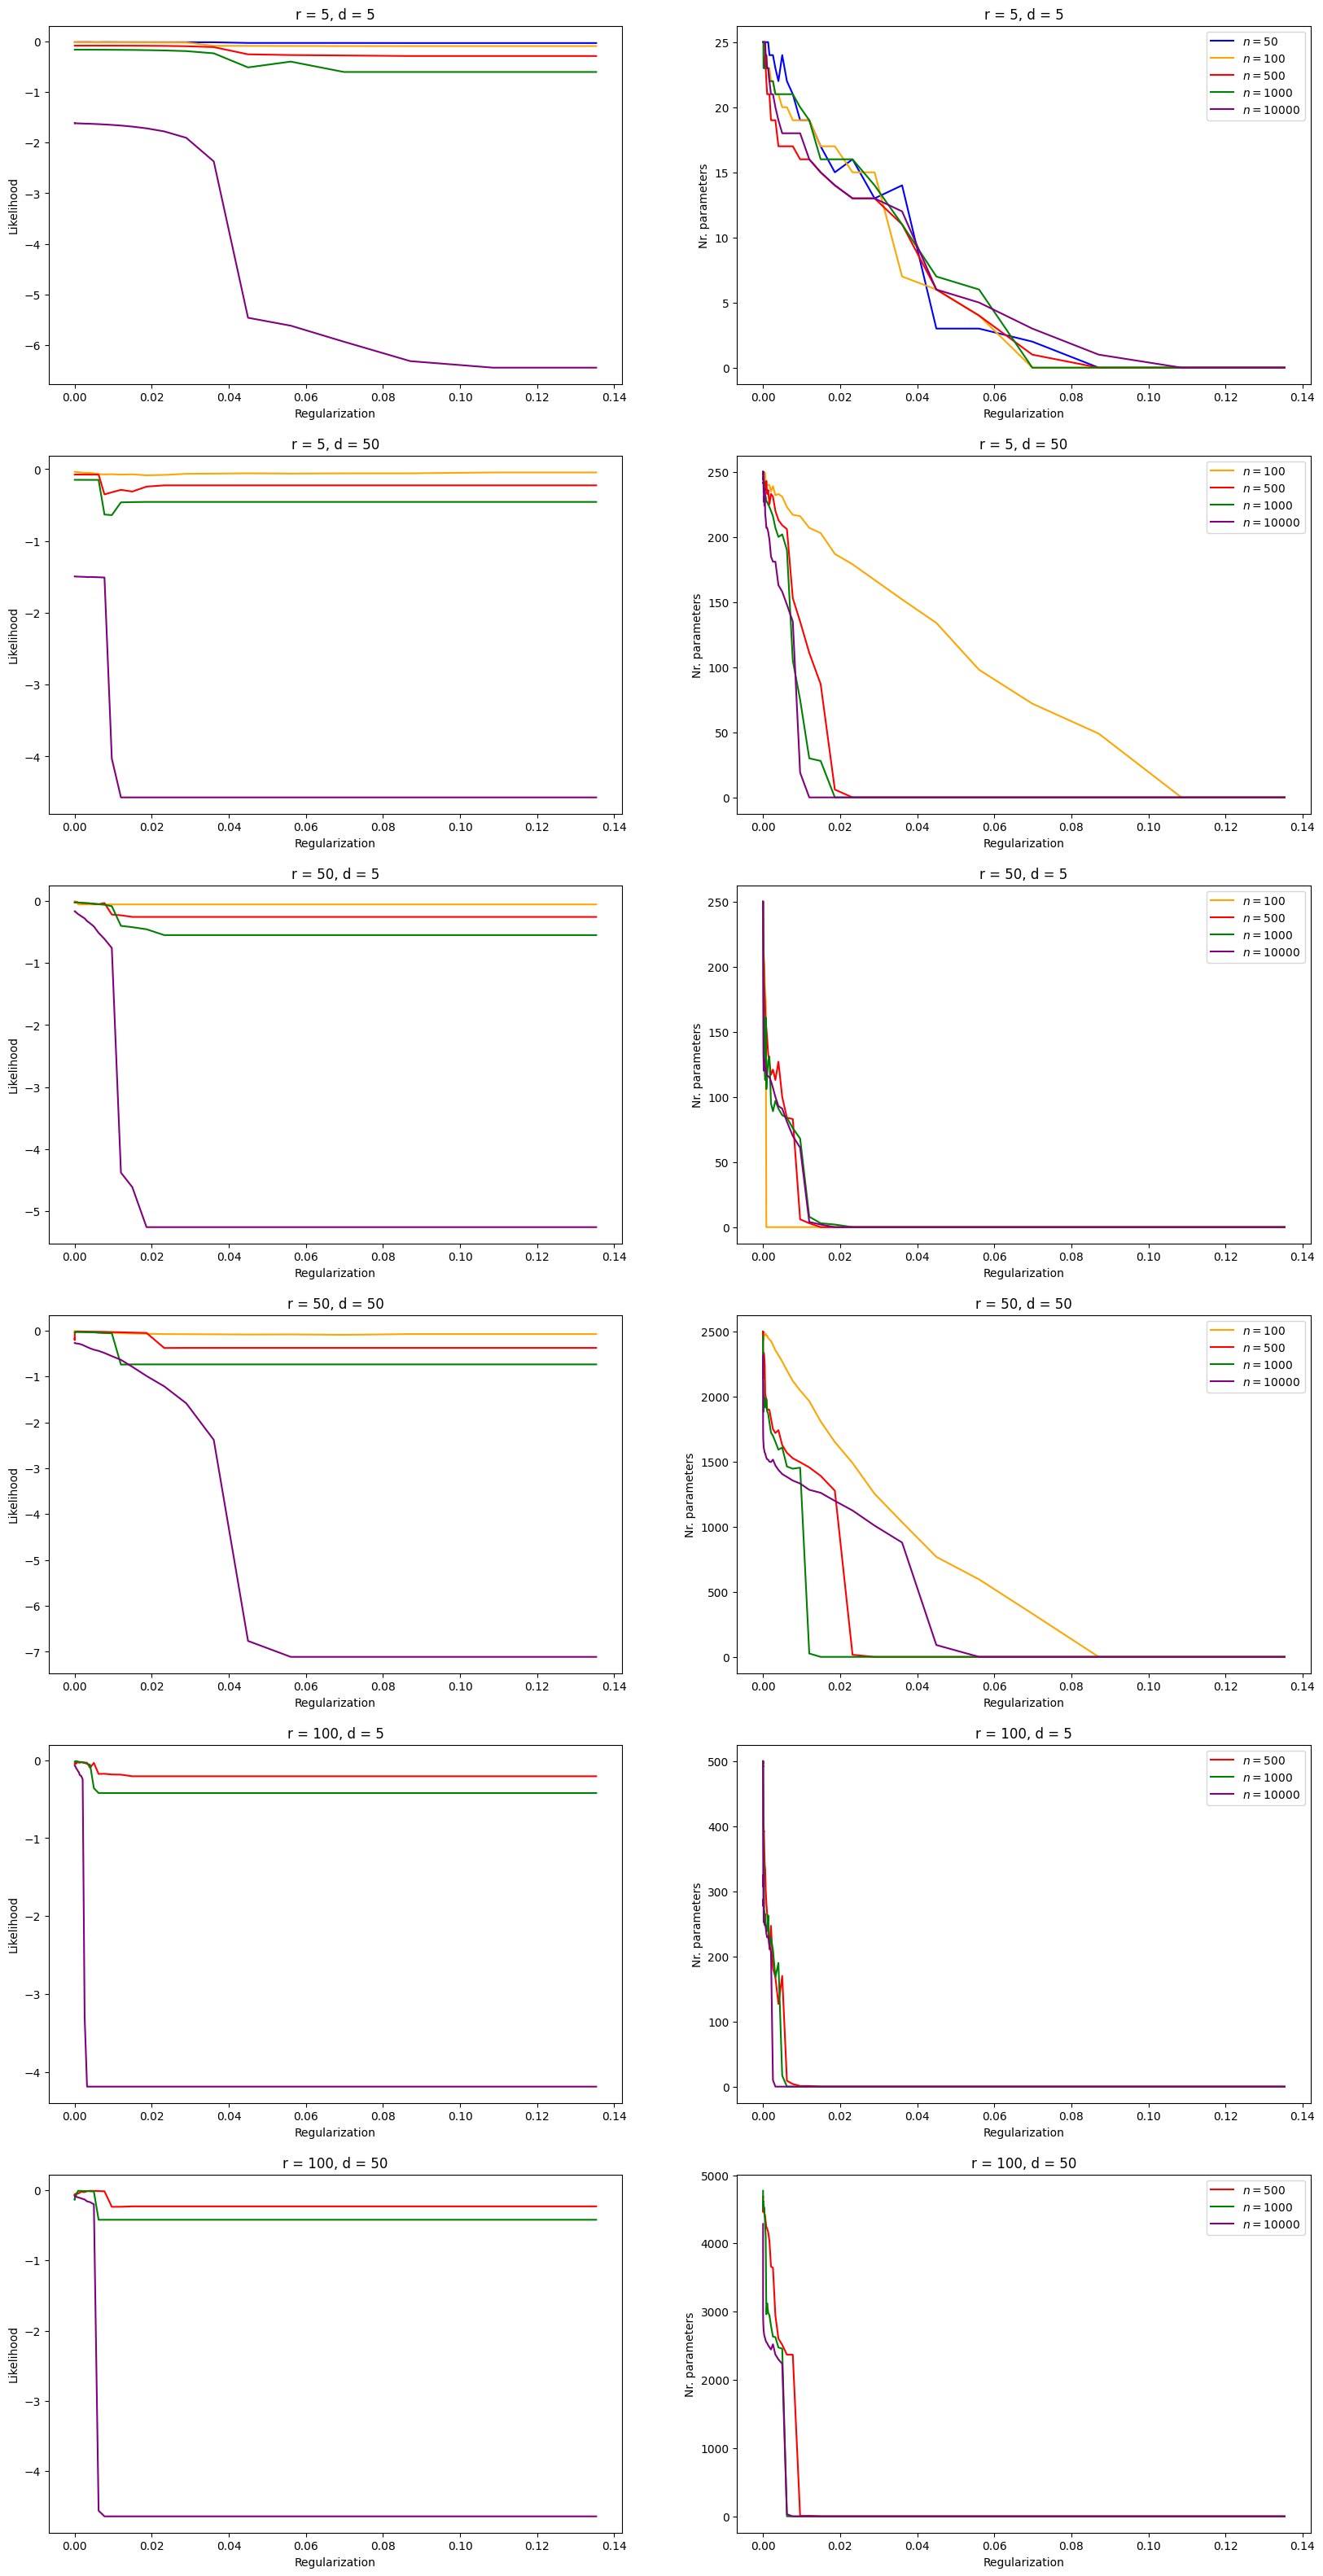

In [33]:
fig, ax = plt.subplots(6,2, figsize = (20,40))

cnt = 0
for r in [5, 50, 100]:
    for d in [5, 50]:
        for k in range(len(ns)):
            if r >5 or d > 5:
                if np.isin(k,[0]):
                    continue
            if r >50 or d > 50:
                if np.isin(k,[0,1]):
                    continue
            if r >100 or d > 100:
                if np.isin(k,[0,1,2]):
                    continue
            ax[cnt,0].plot(alphas, LIK[str(r) + '_'+str(d)][k]/np.std(LIK[str(r) + '_'+str(d)]), label = f'{r"$n = $"}{ns[k]}', color = colors[k])
            ax[cnt,1].plot(alphas, NRPARAM[str(r) + '_'+str(d)][k], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
        ax[cnt,1].legend()
        ax[cnt,0].set_ylabel("Likelihood")
        ax[cnt,1].set_ylabel("Nr. parameters")
        ax[cnt,0].set_xlabel("Regularization")
        ax[cnt,1].set_xlabel("Regularization")
        ax[cnt,0].set_title(f'r = {r}, d = {d}')
        ax[cnt,1].set_title(f'r = {r}, d = {d}')

        cnt+=1

plot value function and BIC on same plot

C:\Users\User\AppData\Local\Temp\ipykernel_23212\2530685608.py:8: RuntimeWarning: invalid value encountered in divide
  ax[cnt].plot(alphas,(EBIC[str(r) + '_'+str(d)]/ np.abs(np.min(EBIC[str(r) + '_'+str(d)], axis=1))[:,np.newaxis])[k]-1, label = f'{r"$n = $"}{ns[k]}', color = colors[k], linestyle = 'dashed')


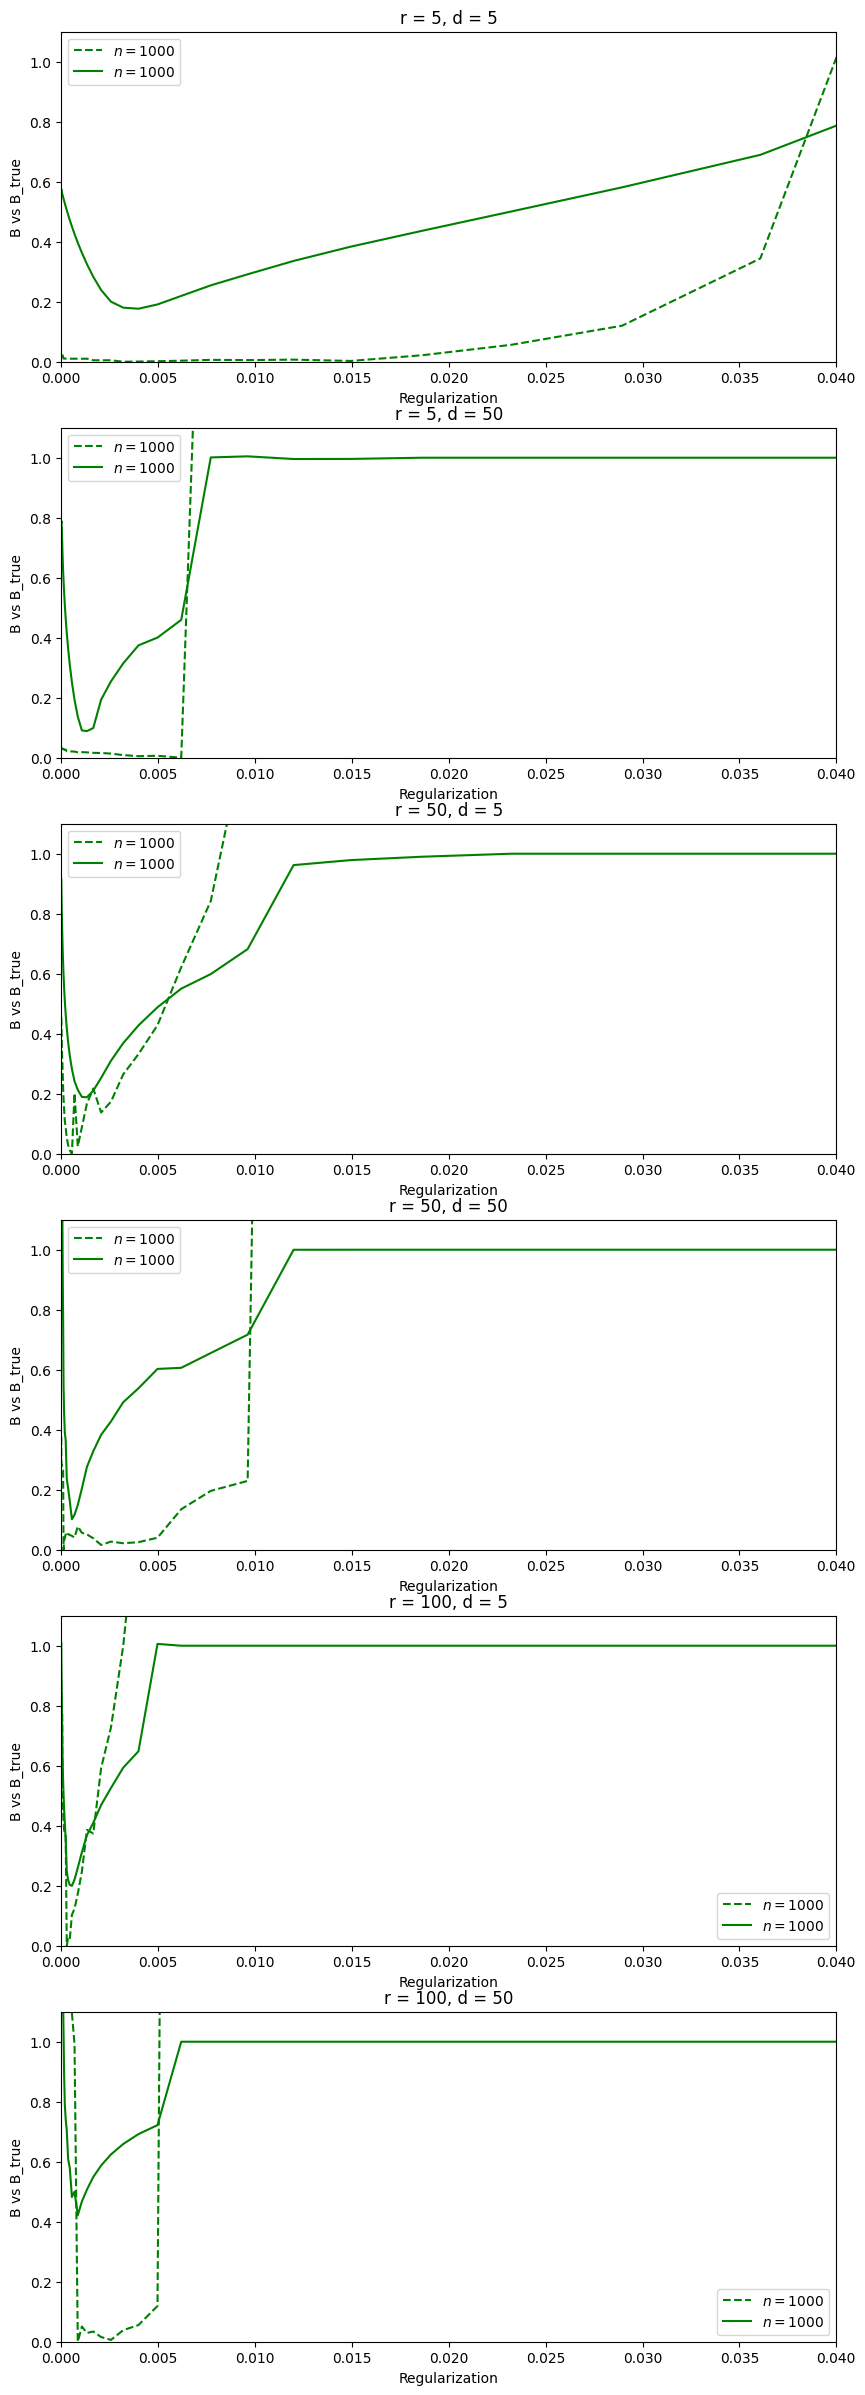

In [64]:
fig, ax = plt.subplots(6,1, figsize = (10,30))

cnt = 0
k = 3
for r in [5, 50, 100]:
    for d in [5, 50]:

        ax[cnt].plot(alphas,(EBIC[str(r) + '_'+str(d)]/ np.abs(np.min(EBIC[str(r) + '_'+str(d)], axis=1))[:,np.newaxis])[k]-1, label = f'BIC {r"$n = $"}{ns[k]}', color = colors[k], linestyle = 'dashed')
        ax[cnt].plot(alphas, [np.sum(np.abs(np.abs(B_dict_true[str(r) + '_'+str(d)]) - np.abs(B_dict[str(r) + '_'+str(d)][k,i])))/np.sum(np.abs(B_dict_true[str(r) + '_'+str(d)])) for i in range(B_dict[str(r) + '_'+str(d)].shape[1])], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
        ax[cnt].legend()
        ax[cnt].set_ylabel("B vs B_true")
        ax[cnt].set_xlabel("Regularization")
        ax[cnt].set_title(f'r = {r}, d = {d}')
        ax[cnt].set_ylim((0,1.1))
        ax[cnt].set_xlim((0,0.04))
        cnt+=1

In [69]:
value_function_dict['5_5'].shape

(5, 5, 5, 60, 5)

KeyError: '0,0'

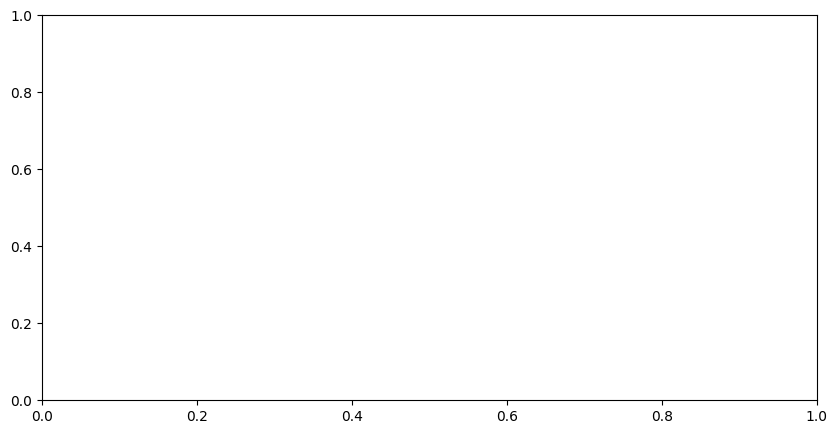

In [65]:


for i in range(d):
    for j in range(i,d):
        fig, ax = plt.subplots(1,1, figsize = (10,5))
        for k in range(len(ns)):
            if k == 0:
                continue
            ax.plot(alphas, np.sum(value_function[str(i)+','+ str(j)][k,:],axis = 1), label = f'{r"$n = $"}{ns[k]}')
        ax.plot(alphas, [val_y_true[i,j]]*len(alphas), color = 'black', label = 'True Shapley')
        ax.set_title(str(i)+','+ str(j))
        ax.legend()
        ax.set_xlabel('Regularization')

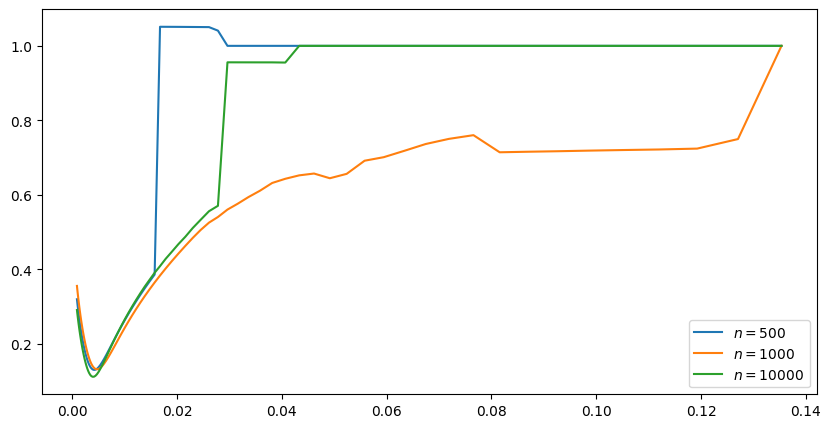

In [41]:

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in range(len(ns)):
    if np.isin(k,[0,1,2]):
        continue
    ax.plot(alphas, [np.linalg.norm(out_dict['B_true'] - out_dict['Bs'][k,i])/np.linalg.norm(out_dict['B_true']) for i in range(out_dict['Bs'].shape[1])], label = f'{r"$n = $"}{ns[k]}')
ax.legend()

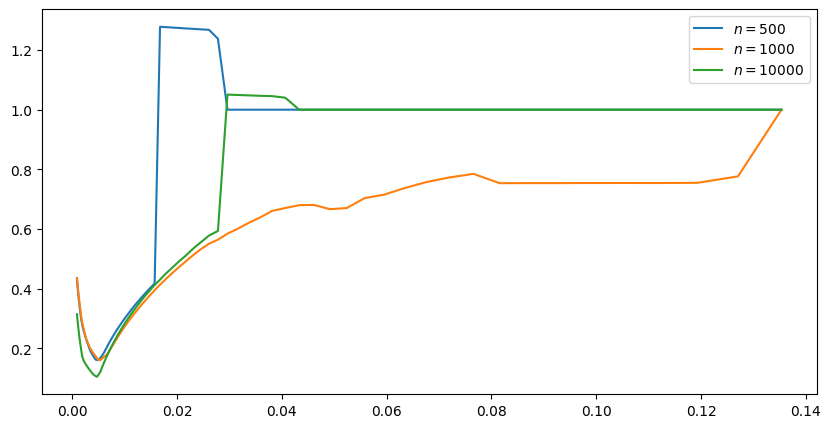

In [42]:

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in range(len(ns)):
    if np.isin(k,[0,1,2]):
        continue
    ax.plot(alphas, [np.sum(np.abs(out_dict['B_true'] - out_dict['Bs'][k,i]))/np.sum(np.abs(out_dict['B_true'])) for i in range(out_dict['Bs'].shape[1])], label = f'{r"$n = $"}{ns[k]}')
ax.legend()
ax.set_ylabel("B vs B_true")
ax.set_xlabel("Regularization")

With non-linear x

In [85]:
# Generate data
n = 1000
d = 5
r = 5
X = np.random.normal(loc = 0, scale = 1, size = (n,r))
gamma = np.random.normal(loc = 0, scale = 1, size = (n))
epsilon = np.random.normal(loc = 0, scale = 1, size = (n,d))


X_new = np.hstack((X,X **2, X[:,:3]**3))
r= X_new.shape[1]
B_true = np.random.normal(loc = 0, scale = 1, size = (d,r))
B_true = B_true*(np.random.uniform(size = (d,r) ) <0.3)

Y = gamma[:, np.newaxis]*np.dot(X_new, B_true.T) + epsilon
Y_tilde = np.vstack((Y, np.zeros((n,d))))

groups =np.concatenate((np.arange(5), np.arange(5), np.arange(3)))

Fit model

In [86]:
B, Psi = cov_regression(X_new,Y, 0.0005, 20 )
print(np.round(B,1))
print(np.round(B_true,1))

[[ 0.5 -1.3  0.   0.   0.7 -1.8  0.   0.1  0.2  0.1 -0.1 -0.2  0.1]
 [-0.1  0.   1.  -0.   0.   0.7 -0.  -0.2 -2.2  0.1  0.1 -0.  -1.4]
 [ 0.   0.2  0.2  1.2 -0.8 -0.1  0.   0.1  0.6  0.  -0.   0.  -0. ]
 [-0.6  0.   0.1 -0.1  0.   1.5 -0.2 -0.1  1.  -0.2  0.1 -0.1 -0. ]
 [ 0.  -0.1  2.2  0.1 -0.   0.3 -0.   0.  -0.1  0.   0.   0.   0.4]]
[[ 0.   1.5 -0.1  0.  -0.5 -0.  -0.  -0.   0.   0.  -0.7 -0.  -0. ]
 [-0.   0.  -0.1 -0.  -0.   0.  -0.  -0.   1.4  0.   0.2  0.   0.6]
 [-0.  -0.1 -0.  -0.9  0.7 -0.   0.   0.  -0.4 -0.  -0.  -0.   0. ]
 [-0.   0.   0.  -0.  -0.  -0.   0.   0.  -0.7  0.   0.5 -0.  -0. ]
 [ 0.  -0.1 -2.4 -0.  -0.  -0.   0.   0.   0.  -0.   0.  -0.  -0. ]]


$b_1 x + b_2 x^2 +b_3x^3$

In [87]:
B

array([[ 0.50612663, -1.26975731,  0.        ,  0.        ,  0.73587229,
        -1.77236307,  0.        ,  0.10802141,  0.17735847,  0.07959923,
        -0.05535678, -0.24749757,  0.05400866],
       [-0.09386396,  0.        ,  1.00863926, -0.0189206 ,  0.        ,
         0.65669681, -0.01629742, -0.16687313, -2.204449  ,  0.08175949,
         0.11543786, -0.01023984, -1.36320235],
       [ 0.        ,  0.18472553,  0.17021791,  1.17716435, -0.79933457,
        -0.13249177,  0.01049658,  0.06056548,  0.61454114,  0.03020619,
        -0.0243457 ,  0.        , -0.01220091],
       [-0.59938393,  0.        ,  0.10334504, -0.07891952,  0.        ,
         1.53912403, -0.16619032, -0.1334188 ,  0.95937789, -0.16824961,
         0.08841274, -0.09154642, -0.04369191],
       [ 0.        , -0.0612596 ,  2.22209174,  0.11094796, -0.00289702,
         0.25515147, -0.04719519,  0.        , -0.12273766,  0.01883685,
         0.04956543,  0.0025589 ,  0.4438456 ]])

Compute shapley

In [95]:
Sigma = np.cov(X_new.T)
val_y = np.dot(B, Sigma).dot(B.T)
#Sigma
shapleys = []

i = 2
j = 3

index = np.arange(X_new.shape[1])
for g in np.unique(groups):
    terms = np.where(g == groups)[0]
    shap = 0.0
    for k in terms:
        t1 = B[i,k]*B[j,k]*Sigma[k,k]
        t2 = 0.5*np.sum(B[i,index != k]*B[j,k]*Sigma[k,index != k])
        t3 = 0.5*np.sum(B[j,index != k]*B[i,k]*Sigma[k,index != k])
        shap += t1+t2+t3
    shapleys.append(shap)


print(np.sum(shapleys))
print(val_y[i,j])

0.7409137366211117
0.7409137366211116


In [89]:
Psi_pre = np.identity(d)
v = np.zeros(n)
m = np.zeros(n)
v = np.ones(n)
m = np.ones(n)
X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
B_pre = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T, X_tilde) + 0.1*np.identity(r)))

iteration = 0
max_itr = 100
alpha = 0.0005
while iteration <max_itr:
    Psi_pre_inv = np.linalg.inv(Psi_pre)
    # print(np.linalg.cond(Psi_pre_inv))
    # E-step
    for i in range(n):
        v[i] = (1+np.dot(X[i].T, B_pre.T).dot(Psi_pre_inv).dot(B_pre).dot(X[i])) ** (-1)
        m[i] = v[i]*np.dot((Y[i]-0).T,Psi_pre_inv).dot(B_true).dot(X[i])

    X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
    # M-step

    B=B_pre.copy()
    for sub_step in range(1,100):
        B = B - (1e-4/sub_step)* (-0.5*np.dot(Psi_pre_inv, Y_tilde.T -np.dot(B,X_tilde.T)).dot(X_tilde))
        B = soft_threshold_odd(B,alpha)


    Psi = np.cov((Y-np.dot(X,B.T)).T)*(n-1)/n
        

    Psi_pre = Psi.copy()
    B_pre = B.copy()

    iteration+=1

np.round(B,2)

ValueError: operands could not be broadcast together with shapes (5,5) (13,13) 

In [6]:
B_est,_= cov_regression(X, Y, 0.05, max_itr = 100)
np.round(B_est,2)

array([[-0.49, -0.01,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.85, -0.04,  0.04,  0.74],
       [ 0.6 , -0.11, -0.28,  0.81,  0.  ],
       [ 0.  ,  0.75,  0.1 ,  0.72,  0.  ],
       [ 0.  ,  0.  , -0.73,  0.  , -1.21]])

In [14]:
B_est,_= cov_regression_subgrad(X, Y,0.01, max_itr = 100, step_size=1e-5)
np.round(B_est,2)

array([[ 0.2 ,  0.03,  0.01, -0.02,  0.  ],
       [-0.  , -0.37,  0.03, -0.15, -0.3 ],
       [-0.23,  0.05,  0.16, -0.36,  0.  ],
       [ 0.01, -0.32, -0.04, -0.38,  0.02],
       [-0.01, -0.01,  0.33,  0.07,  0.49]])

In [13]:
B_est,_= cov_regression_gen_grad(X, Y,0.00, max_itr = 100, step_size=1e-8)
np.round(B_est,2)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [15]:
# Generate data
from scipy.stats import t
n = 100
d = 5
r = 5
X = np.random.normal(loc = 0, scale = 1, size = (n,r))
gamma = np.random.normal(loc = 0, scale = 1, size = (n))
epsilon = t.rvs(loc = 0, scale = 1, size = (n,d),df = 4)
B_true = np.random.normal(loc = 0, scale = 1, size = (d,r))
B_true = B_true*(np.random.uniform(size = (d,r) ) <0.7)


Y = gamma[:, np.newaxis]*np.dot(X, B_true.T) + epsilon


Y_tilde = np.vstack((Y, np.zeros((n,d))))

B_est_n,_= cov_regression_t(X, Y, 0.1, nu = 30, max_itr = 100)
print(np.round(B_est_n,2))
print("")
B_est_t,_= cov_regression_t(X, Y, 0.05, nu = 4, max_itr = 100)
print(np.round(B_est_t,2))
print("")
print(np.round(B_true,2))
print("")
print(scipy.linalg.norm(np.abs(B_true) - np.abs(B_est_n)))
print(scipy.linalg.norm(np.abs(B_true) - np.abs(B_est_t)))

[[-0.04  0.   -0.08 -0.07 -0.22]
 [ 0.23  0.01  0.19  0.    0.1 ]
 [ 0.02  0.    0.    0.16  0.  ]
 [ 0.41  0.23 -0.09  0.    0.06]
 [ 0.    0.   -0.19  0.14 -0.04]]

[[-0.04 -0.1   0.   -0.08 -0.44]
 [ 0.39  0.    0.4   0.    0.1 ]
 [ 0.   -0.1   0.    0.46  0.  ]
 [ 0.7   0.47  0.    0.    0.  ]
 [ 0.    0.03 -0.31  0.2  -0.2 ]]

[[ 0.   -0.   -0.66 -0.69 -1.83]
 [ 1.15  0.72  1.06 -0.02  0.59]
 [-0.   -1.19 -0.2   1.04 -0.  ]
 [ 1.43  0.8   0.   -0.   -0.9 ]
 [-0.    0.21 -0.87  0.31 -0.96]]

3.377598610555667
2.915790078655746


In [16]:
print(scipy.linalg.norm(np.abs(B_true) - np.abs(B_est_n)))
print(scipy.linalg.norm(np.abs(B_true) - np.abs(B_est_t)))

3.377598610555667
2.915790078655746


In [17]:
# Generate data
n = 100
d = 5
r = 20
X = np.random.normal(loc = 0, scale = 1, size = (n,r))
gamma = np.random.normal(loc = 0, scale = 1, size = (n))
epsilon = np.random.normal(loc = 0, scale = 1, size = (n,d))
B_true = np.random.normal(loc = 0, scale = 1, size = (d,r))
B_true = B_true*(np.random.uniform(size = (d,r) ) <0.3)


Y = gamma[:, np.newaxis]*np.dot(X, B_true.T) + epsilon


Y_tilde = np.vstack((Y, np.zeros((n,d))))
print(np.round(B_true,2))

[[-0.   -0.    0.   -0.    0.31 -0.   -0.76  0.   -0.85 -1.01 -0.79  0.
  -0.   -0.    0.   -0.14  0.   -0.61 -0.    0.16]
 [-0.44  0.   -0.    0.    0.   -0.   -0.    0.   -0.    0.   -0.   -0.
  -0.   -0.    1.34 -0.    0.    0.    0.   -0.  ]
 [-0.   -0.    0.51 -0.   -0.   -0.59 -0.17  0.    0.   -0.11  0.02 -0.
   0.    0.   -0.18  0.45 -0.37 -0.53  0.   -0.  ]
 [ 0.   -0.   -0.   -0.    0.   -1.66 -1.33 -1.55  0.   -0.   -0.   -0.
  -0.   -0.   -0.   -0.    0.    0.    0.16  0.  ]
 [ 0.    0.   -0.    0.   -0.    0.43 -0.    0.   -0.    0.   -0.   -0.
  -0.   -0.   -0.5  -0.14 -0.   -0.   -0.   -0.  ]]


In [30]:
# Perform regression with differnt alpha and store

n = 1000
d = 5
r = 20
X = np.random.normal(loc = 0, scale = 1, size = (n,r))
gamma = np.random.normal(loc = 0, scale = 1, size = (n))
epsilon = np.random.normal(loc = 0, scale = 1, size = (n,d))
B_true = np.random.normal(loc = 0, scale = 1, size = (d,r))
B_true = B_true*(np.random.uniform(size = (d,r) ) <0.7)

Y = gamma[:, np.newaxis]*np.dot(X, B_true.T) + epsilon

alphas = np.linspace(0, 0.2,100)
B_est_t = np.zeros((len(alphas), d, r))
B_est_n = np.zeros((len(alphas), d, r))
Psi_est_t = np.zeros((len(alphas), d, d))
Psi_est_n = np.zeros((len(alphas), d, d))
fro_loss_t = np.zeros(len(alphas))
fro_loss_n = np.zeros(len(alphas))
pbar = tqdm.tqdm(total = len(alphas))
for cnt, alpha in enumerate(alphas):
    B_est_n[cnt], Psi_est_n[cnt] = cov_regression(X, Y, alpha, max_itr = 100)
    B_est_t[cnt], Psi_est_t[cnt] = cov_regression_t(X, Y, alpha, max_itr = 100, nu = 30)
    fro_loss_t[cnt] = scipy.linalg.norm(np.abs(B_est_t[cnt])-np.abs(B_true))
    fro_loss_n[cnt] = scipy.linalg.norm(np.abs(B_est_n[cnt])-np.abs(B_true))
    pbar.update()
pbar.close()

100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


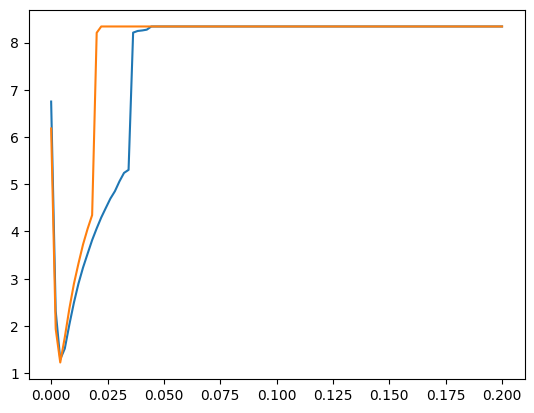

In [32]:
plt.plot(alphas, fro_loss_n)
plt.plot(alphas, fro_loss_t)

In [21]:
B_est[-1]

array([-0.01454978, -0.00951265,  0.32950572,  0.07342058,  0.48635393])

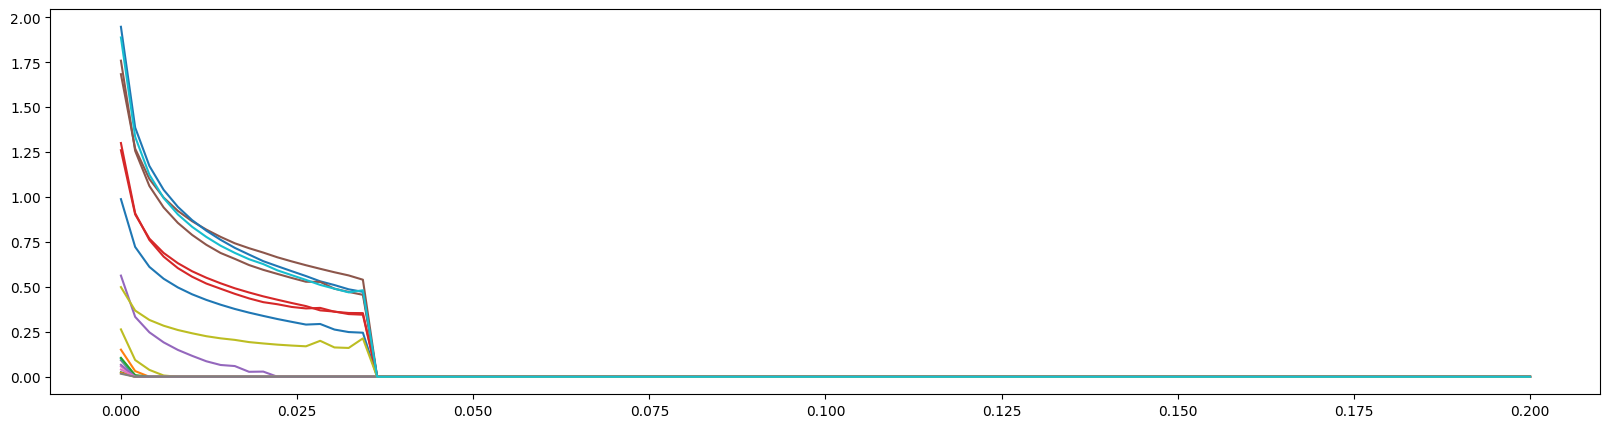

In [33]:
fig, ax = plt.subplots(1,1,figsize = (20, 5))
ax.plot(alphas,np.abs(B_est_n[:,0,:]))
#ax.plot(alphas,np.abs(B_est_n[:,1,:]))
#ax.plot(alphas,np.abs(B_est_n[:,2,:]))


TEST t

In [94]:
# Generate data
from scipy.stats import t
n = 1000
d = 5
r = 20
X = np.random.normal(loc = 0, scale = 1, size = (n,r))
gamma = np.random.normal(loc = 0, scale = 1, size = (n))
epsilon = t.rvs(loc = 0, scale = 1, size = (n,d),df = 4)
B_true = np.random.normal(loc = 0, scale = 1, size = (d,r))
B_true = B_true*(np.random.uniform(size = (d,r) ) <0.7)

Y = gamma[:, np.newaxis]*np.dot(X, B_true.T) + epsilon

alphas = np.linspace(0, 0.2,100)
B_est_t = np.zeros((len(alphas), d, r))
B_est_n = np.zeros((len(alphas), d, r))
Psi_est_t = np.zeros((len(alphas), d, d))
Psi_est_n = np.zeros((len(alphas), d, d))
fro_loss_t = np.zeros(len(alphas))
fro_loss_n = np.zeros(len(alphas))
pbar = tqdm.tqdm(total = len(alphas))
for cnt, alpha in enumerate(alphas):
    B_est_n[cnt], Psi_est_n[cnt] = cov_regression(X, Y, alpha, max_itr = 100)
    B_est_t[cnt], Psi_est_t[cnt] = cov_regression_t(X, Y, alpha, max_itr = 100, nu = 4)
    fro_loss_t[cnt] = scipy.linalg.norm(np.abs(B_est_t[cnt])-np.abs(B_true))
    fro_loss_n[cnt] = scipy.linalg.norm(np.abs(B_est_n[cnt])-np.abs(B_true))
    pbar.update()
pbar.close()



100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


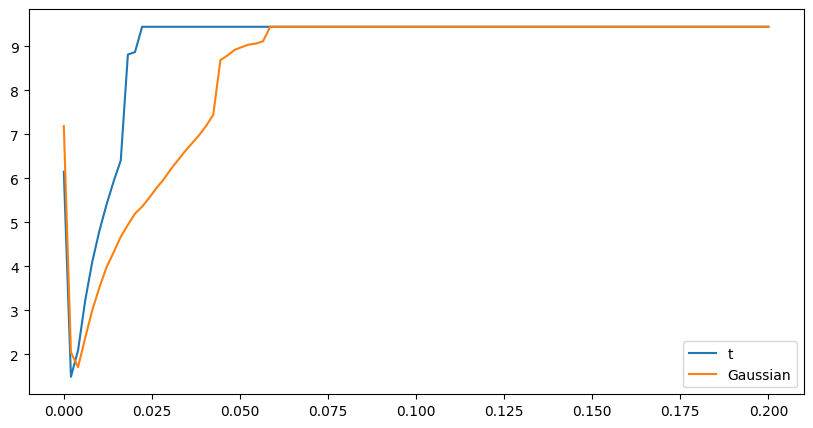

In [95]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(alphas, fro_loss_t, label = 't')
ax.plot(alphas, fro_loss_n, label = 'Gaussian')
ax.legend()

In [91]:
np.round(B_est[1],2)

array([[-0.  ,  0.38,  0.71,  0.  ,  0.  ,  0.  , -0.65, -0.43, -0.06,
         2.11,  1.09,  0.86, -0.32, -1.67,  1.89, -0.03, -0.29, -0.13,
        -0.05, -0.42],
       [-0.19, -1.42,  0.05,  0.71,  0.  , -0.29,  0.  ,  1.13,  0.  ,
         0.08, -0.24, -0.16,  1.26, -0.94, -1.03, -0.08,  0.  ,  0.  ,
         0.  , -0.46],
       [-0.32,  0.64,  0.5 , -0.1 ,  0.11,  0.  , -1.18,  0.21, -0.2 ,
         0.  ,  1.02, -0.32,  0.16,  1.02, -1.54,  0.  ,  0.2 , -0.26,
        -0.55,  0.  ],
       [ 1.55,  0.32,  0.  ,  0.47, -0.06, -0.21, -0.12,  0.15, -0.7 ,
         0.42,  0.  ,  0.  ,  0.58,  0.23, -0.55,  0.74,  0.  , -1.17,
         0.22,  0.  ],
       [ 0.11, -0.17,  0.18, -1.41,  0.  ,  0.39,  0.82,  0.34, -0.09,
         0.  , -0.9 ,  0.2 ,  0.71, -0.41,  0.16,  0.49,  0.65,  0.11,
        -0.02,  0.  ]])